<a id="home"></a>
# IEEE Fraud Detection transactions columns reference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

INPUT_DIR = 'data/'
COLS_TO_SHOW = 150

def h(content):
    display(HTML(content))

def timehist1(col):
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # clip trans amount for better view
    tr[tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    tr[tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    te.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()
    
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \
    
def desc1(col):
    d0 = _desc(tr[col], col, 'Train')
    d1 = _desc(tr.loc[tr['isFraud'] == 1, col], col, 'Train fraud')
    d2 = _desc(tr.loc[tr['isFraud'] == 0, col], col, 'Train Not fraud')
    d3 = _desc(te[col], col, 'Test')
    n_public = int(te.shape[0] * 0.2)
    d4 = _desc(te.loc[:n_public, col], col, 'Test public')
    d5 = _desc(te.loc[n_public:, col], col, 'Test private')
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    display(dd)
    
    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        d0 = tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = te[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1)
        display(dd)

def hist1(col):
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.hist(tr[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.subplot(122)
    plt.hist(te[col], bins=70);
    plt.title('Test histogram: ' + col);
    plt.show()

def corr1(col):
    N = None #10000
    num_vars = [f for f in tr.columns if tr[f].dtype != 'object']
    trx = tr.head(N) if N is not None else tr.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))
    
def numeric(col):
    timehist1(col)
    hist1(col)
    desc1(col)
    corr1(col) 
    
def categorical(col):
    desc1(col)

def proc(col):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr[col].dtype == 'object' else numeric(col)
        
tr = pd.read_csv(INPUT_DIR + 'train_transaction.csv')
te = pd.read_csv(INPUT_DIR + 'test_transaction.csv')
trid = pd.read_csv(INPUT_DIR + 'train_identity.csv')
teid = pd.read_csv(INPUT_DIR + 'test_identity.csv')

included_cols = list(tr.columns.values[:COLS_TO_SHOW])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
h('Train transactions shape: <b>' + str(tr.shape) + '</b>, identity <b>' + str(trid.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te.shape) + '</b>, identity <b>' + str(teid.shape) + '</b>')
h('Train transactions preview:')
display(tr.head(10))

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
5  555.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
6  360.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
7  490.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
8  100.0  150.0        visa  226.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
9  111.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  
5  NaN   NaN   NaN   NaN  
6  NaN   NaN   NaN   NaN  
7  NaN   NaN   NaN   NaN  
8  0.0   0.0   0.0   0.0  
9  NaN   NaN   NaN   NaN  

[10 rows x 394 columns]

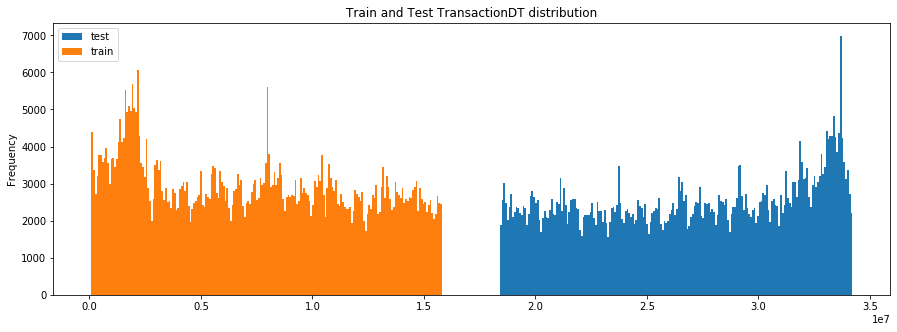

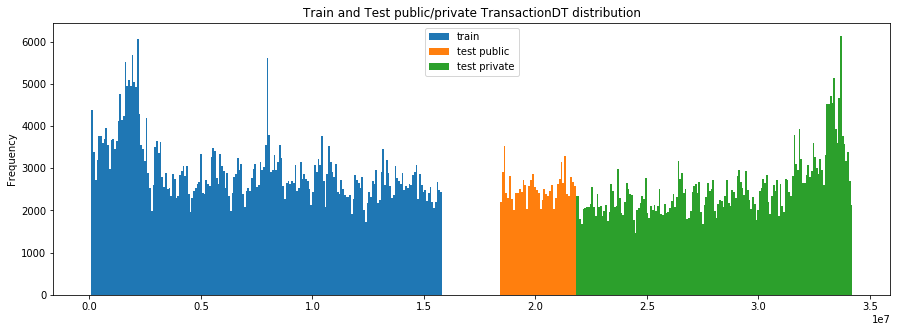

In [2]:
COL = 'TransactionDT'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')

te['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
tr['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()
tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test public/private TransactionDT distribution')
n_public = int(te.shape[0] * 0.2)
te.loc[:n_public, 'TransactionDT'].plot(kind='hist', label='test public', bins=40)
te.loc[n_public:, 'TransactionDT'].plot(kind='hist', label='test private', bins=160)
plt.legend()
plt.show()
corr1(COL)

In [3]:
COL = 'isFraud'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
h('This is target column.')
trx = tr['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
display(trx)
corr1(COL)

Value   Count    Share
0      0  569877  0.96501
1      1   20663  0.03499

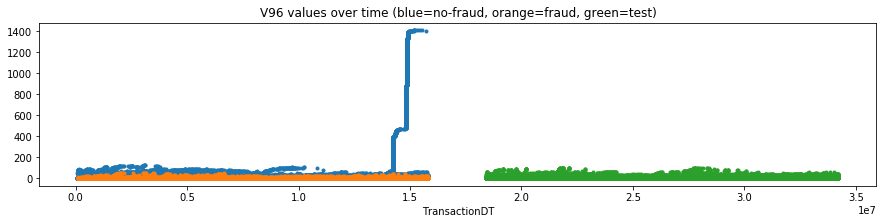

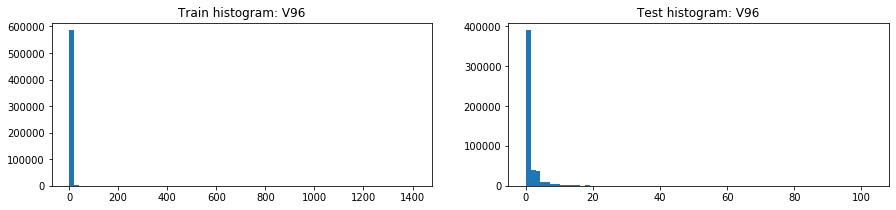

V96         Train   Train fraud  Train Not fraud           Test  \
0           count  590226.00000  20646.000000    569580.000000  506691.000000   
1            mean       3.00519      1.846023         3.047207       1.376553   
2             std      40.23949      4.449918        40.952917       3.806585   
3             min       0.00000      0.000000         0.000000       0.000000   
4             25%       0.00000      0.000000         0.000000       0.000000   
5             50%       0.00000      0.000000         0.000000       0.000000   
6             75%       1.00000      2.000000         1.000000       1.000000   
7             max    1410.00000     55.000000      1410.000000     103.000000   
8   unique values    1411.00000     57.000000      1411.000000     104.000000   
9            NaNs     314.00000     17.000000       297.000000       0.000000   
10     NaNs share       0.00050      0.000800         0.000500       0.000000   

      Test public   Test private  
0   101339.000000  405353.000000  
1        1.601831       1.320237  
2        4.519231       3.604289  
3        0.000000       0.000000  
4        0.000000       0.000000  
5        0.000000       0.000000  
6        2.000000       1.000000  
7       98.000000     103.000000  
8       99.000000     104.000000  
9        0.000000       0.000000  
10       0.000000       0.000000

V96  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 366578     0.032743       12003       308455.0
1  1.0                  95636     0.032540        3112        81462.0
2  2.0                  46607     0.035123        1637        40821.0
3  3.0                  25624     0.038050         975        22889.0
4  4.0                  15839     0.040912         648        14701.0
5  5.0                   9376     0.042875         402         8901.0
6  6.0                   6240     0.046154         288         6041.0
7  7.0                   4378     0.054134         237         4356.0
8  8.0                   3169     0.062165         197         3300.0
9  9.0                   2333     0.066009         154         2416.0

V96  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          366578     0.032743              12003         308455
1  1.0           95636     0.032540               3112          81462
2  2.0           46607     0.035123               1637          40821
3  3.0           25624     0.038050                975          22889
4  4.0           15839     0.040912                648          14701
5  5.0            9376     0.042875                402           8901
6  6.0            6240     0.046154                288           6041
7  7.0            4378     0.054134                237           4356
8  8.0            3169     0.062165                197           3300
9  9.0            2333     0.066009                154           2416

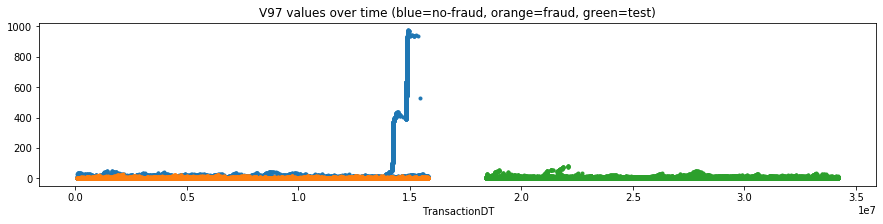

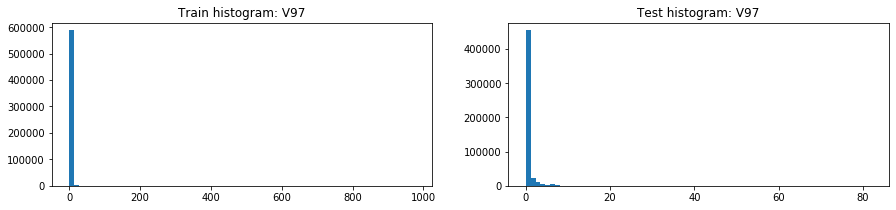

V97          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.718933      1.065582         1.742616   
2             std      27.700449      2.245991        28.194494   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     976.000000     26.000000       976.000000   
8   unique values     977.000000     28.000000       977.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.531728       0.624528       0.508527  
2        1.687563       2.113996       1.562018  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       1.000000       0.000000  
7       82.000000      62.000000      82.000000  
8       83.000000      63.000000      72.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V97  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 454213     0.028416       12907       385324.0
1  1.0                  78056     0.042495        3317        68748.0
2  2.0                  26249     0.061602        1617        24224.0
3  3.0                  11485     0.080888         929        10926.0
4  4.0                   5993     0.097447         584         5839.0
5  5.0                   3616     0.103153         373         3563.0
6  6.0                   2347     0.100128         235         2324.0
7  7.0                   1582     0.103666         164         1499.0
8  8.0                   1097     0.114859         126         1064.0
9  9.0                    798     0.116541          93          746.0

V97  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          454213     0.028416              12907         385324
1  1.0           78056     0.042495               3317          68748
2  2.0           26249     0.061602               1617          24224
3  3.0           11485     0.080888                929          10926
4  4.0            5993     0.097447                584           5839
5  5.0            3616     0.103153                373           3563
6  6.0            2347     0.100128                235           2324
7  7.0            1582     0.103666                164           1499
8  8.0            1097     0.114859                126           1064
9  9.0             798     0.116541                 93            746

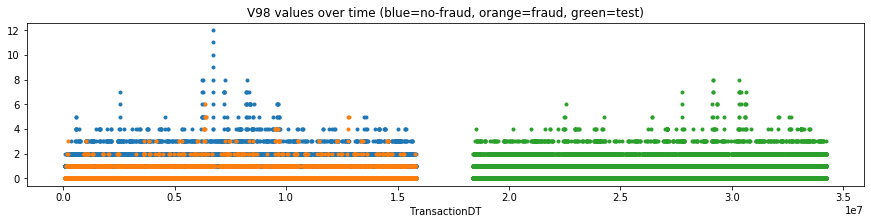

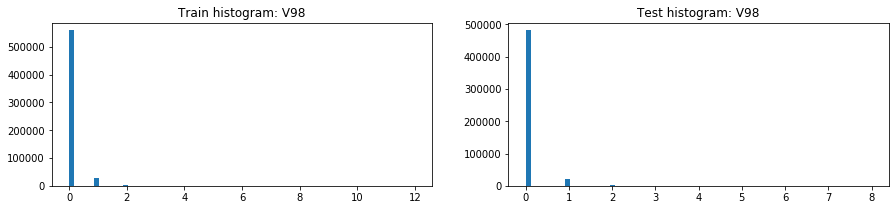

V98          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.061985      0.102877         0.060502   
2             std       0.284995      0.371254         0.281261   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      12.000000      6.000000        12.000000   
8   unique values      14.000000      8.000000        14.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.057532       0.060224       0.056859  
2        0.272315       0.270035       0.272878  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7        8.000000       4.000000       8.000000  
8        9.000000       5.000000       9.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V98  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 558622     0.033776       18868       481398.0
1    1.0                  27768     0.054847        1523        22275.0
2    2.0                   3058     0.061805         189         2400.0
3    3.0                    568     0.084507          48          473.0
4 -999.0                    314     0.054140          17            NaN
5    4.0                    135     0.088889          12          104.0
6    5.0                     33     0.151515           5           19.0
7    6.0                     21     0.047619           1           11.0
8    7.0                     12     0.000000           0            8.0
9    8.0                      5     0.000000           0            3.0

V98  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          558622     0.033776              18868       481398.0
1    1.0           27768     0.054847               1523        22275.0
2    2.0            3058     0.061805                189         2400.0
3    3.0             568     0.084507                 48          473.0
4 -999.0             314     0.054140                 17            NaN
5    4.0             135     0.088889                 12          104.0
6    5.0              33     0.151515                  5           19.0
7    6.0              21     0.047619                  1           11.0
8    7.0              12     0.000000                  0            8.0
9    8.0               5     0.000000                  0            3.0

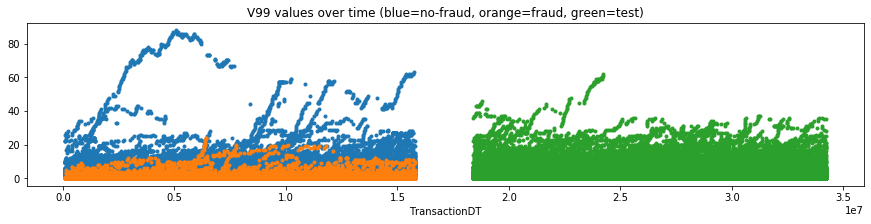

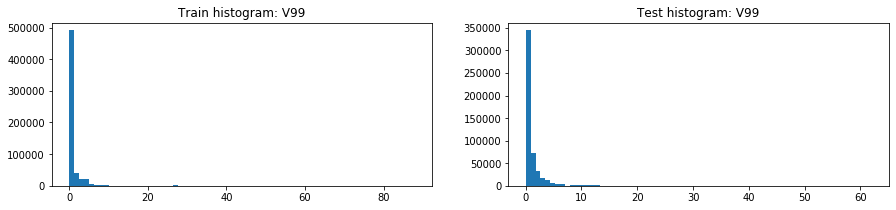

V99          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.894986      0.706529         0.901817   
2             std       2.722552      1.957960         2.746030   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max      88.000000     24.000000        88.000000   
8   unique values      90.000000     26.000000        90.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.939983       1.026308       0.918407  
2        2.425097       2.540143       2.394989  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       1.000000       1.000000  
7       62.000000      46.000000      62.000000  
8       63.000000      47.000000      63.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V99  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 403766     0.038938       15722       344117.0
1  1.0                  86901     0.025155        2186        72146.0
2  2.0                  39884     0.023618         942        33897.0
3  3.0                  21053     0.023940         504        18209.0
4  4.0                  13162     0.031606         416        12193.0
5  5.0                   7142     0.029544         211         6735.0
6  6.0                   4627     0.025935         120         4721.0
7  7.0                   3185     0.030141          96         3165.0
8  8.0                   2169     0.048409         105         2404.0
9  9.0                   1596     0.057018          91         1733.0

V99  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          403766     0.038938              15722         344117
1  1.0           86901     0.025155               2186          72146
2  2.0           39884     0.023618                942          33897
3  3.0           21053     0.023940                504          18209
4  4.0           13162     0.031606                416          12193
5  5.0            7142     0.029544                211           6735
6  6.0            4627     0.025935                120           4721
7  8.0            2169     0.048409                105           2404
8  7.0            3185     0.030141                 96           3165
9  9.0            1596     0.057018                 91           1733

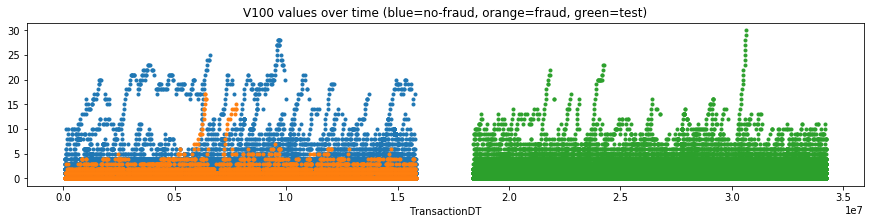

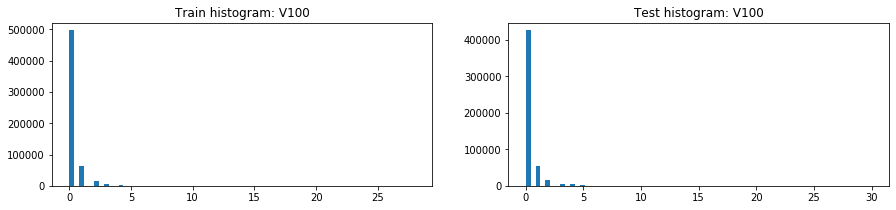

V100          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.273504      0.329652         0.271468   
2             std       0.947176      0.925890         0.947877   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      28.000000     17.000000        28.000000   
8   unique values      30.000000     19.000000        30.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.270194       0.291497       0.264868  
2        0.834316       0.845393       0.831438  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       30.000000      21.000000      30.000000  
8       31.000000      22.000000      31.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V100  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 496523     0.033775       16770       425891.0
1   1.0                  63797     0.036742        2344        52967.0
2   2.0                  16343     0.050970         833        14790.0
3   3.0                   6424     0.059153         380         6216.0
4   4.0                   3474     0.061313         213         3802.0
5   5.0                    777     0.055341          43         1219.0
6  10.0                    748     0.004011           3          104.0
7   7.0                    590     0.008475           5          387.0
8   6.0                    389     0.066838          26          697.0
9   9.0                    387     0.012920           5          146.0

V100  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          496523     0.033775              16770       425891.0
1    1.0           63797     0.036742               2344        52967.0
2    2.0           16343     0.050970                833        14790.0
3    3.0            6424     0.059153                380         6216.0
4    4.0            3474     0.061313                213         3802.0
5    5.0             777     0.055341                 43         1219.0
6    6.0             389     0.066838                 26          697.0
7 -999.0             314     0.054140                 17            NaN
8   14.0              33     0.212121                  7           20.0
9    7.0             590     0.008475                  5          387.0

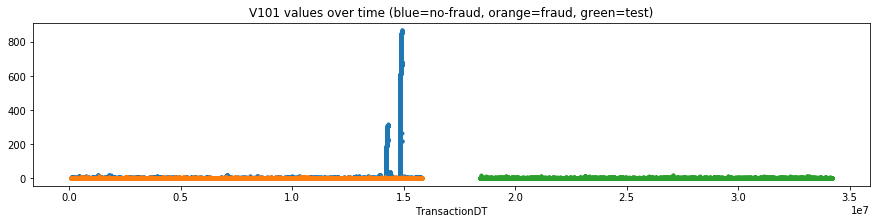

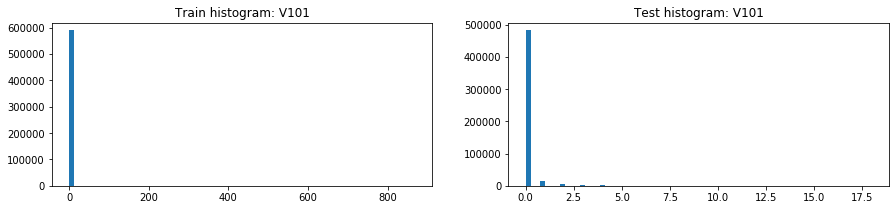

V101          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.889249      0.379831         0.907714   
2             std      20.582571      1.014770        20.951164   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max     869.000000     13.000000       869.000000   
8   unique values     871.000000     15.000000       871.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.091320       0.105211       0.087847  
2        0.516291       0.544514       0.508932  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       18.000000      17.000000      18.000000  
8       19.000000      18.000000      19.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V101  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 556214     0.029785       16567       481543.0
1    1.0                  19797     0.117442        2325        14782.0
2    2.0                   6803     0.125386         853         5523.0
3    3.0                   2995     0.139566         418         2307.0
4    4.0                   1379     0.150109         207         1177.0
5    5.0                    735     0.152381         112          594.0
6    6.0                    380     0.186842          71          301.0
7 -999.0                    314     0.054140          17            NaN
8    7.0                    227     0.180617          41          178.0
9    8.0                    141     0.198582          28          101.0

V101  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          556214     0.029785              16567       481543.0
1    1.0           19797     0.117442               2325        14782.0
2    2.0            6803     0.125386                853         5523.0
3    3.0            2995     0.139566                418         2307.0
4    4.0            1379     0.150109                207         1177.0
5    5.0             735     0.152381                112          594.0
6    6.0             380     0.186842                 71          301.0
7    7.0             227     0.180617                 41          178.0
8    8.0             141     0.198582                 28          101.0
9 -999.0             314     0.054140                 17            NaN

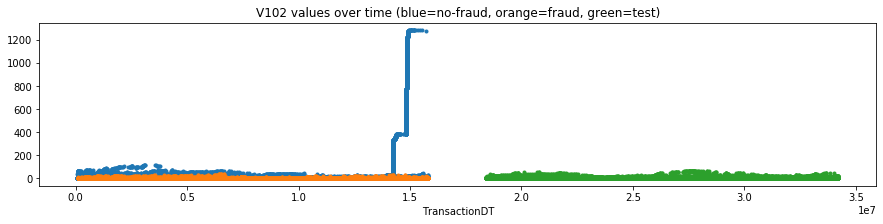

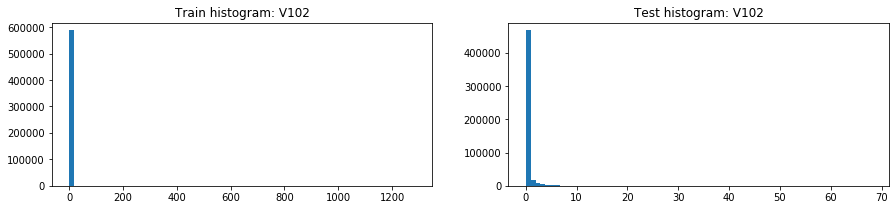

V102          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.827229      0.912429         1.860388   
2             std      35.928456      2.760635        36.569617   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max    1285.000000     41.000000      1285.000000   
8   unique values    1286.000000     43.000000      1286.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.246503       0.317351       0.228791  
2        1.639347       1.807579       1.594026  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       68.000000      56.000000      68.000000  
8       69.000000      55.000000      69.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V102  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 535961     0.028319       15178       467675.0
1   1.0                  24472     0.097417        2384        18094.0
2   2.0                  10448     0.098009        1024         8018.0
3   3.0                   5439     0.111050         604         3961.0
4   4.0                   3227     0.115277         372         2413.0
5   5.0                   2009     0.120458         242         1506.0
6   6.0                   1434     0.115063         165         1092.0
7   7.0                    992     0.126008         125          731.0
8   8.0                    661     0.107413          71          542.0
9   9.0                    522     0.130268          68          439.0

V102  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          535961     0.028319              15178         467675
1   1.0           24472     0.097417               2384          18094
2   2.0           10448     0.098009               1024           8018
3   3.0            5439     0.111050                604           3961
4   4.0            3227     0.115277                372           2413
5   5.0            2009     0.120458                242           1506
6   6.0            1434     0.115063                165           1092
7   7.0             992     0.126008                125            731
8   8.0             661     0.107413                 71            542
9   9.0             522     0.130268                 68            439

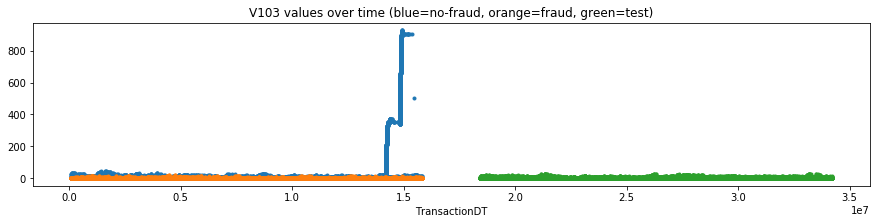

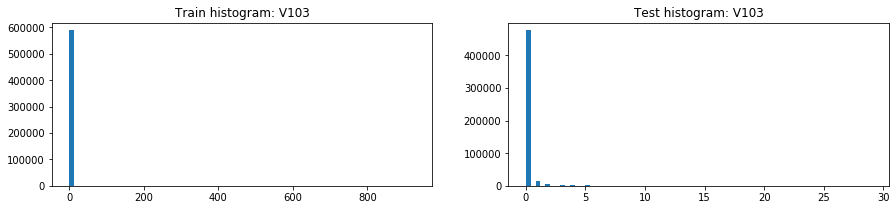

V103          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000     569580.00000   
1            mean       1.279288      0.588443          1.30433   
2             std      25.685642      1.570681         26.14497   
3             min       0.000000      0.000000          0.00000   
4             25%       0.000000      0.000000          0.00000   
5             50%       0.000000      0.000000          0.00000   
6             75%       0.000000      0.000000          0.00000   
7             max     928.000000     21.000000        928.00000   
8   unique values     929.000000     23.000000        929.00000   
9            NaNs     314.000000     17.000000        297.00000   
10     NaNs share       0.000500      0.000800          0.00050   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.145142       0.182279       0.135857  
2        0.846263       1.014076       0.798551  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       29.000000      29.000000      29.000000  
8       30.000000      30.000000      30.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V103  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 547743     0.028791       15770       475771.0
1   1.0                  21363     0.110752        2366        15794.0
2   2.0                   8399     0.117157         984         6658.0
3   3.0                   4117     0.131163         540         3165.0
4   4.0                   2268     0.145062         329         1803.0
5   5.0                   1352     0.149408         202         1052.0
6   6.0                    880     0.155682         137          689.0
7   7.0                    576     0.156250          90          466.0
8   8.0                    418     0.136364          57          324.0
9   9.0                    325     0.144615          47          217.0

V103  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          547743     0.028791              15770         475771
1   1.0           21363     0.110752               2366          15794
2   2.0            8399     0.117157                984           6658
3   3.0            4117     0.131163                540           3165
4   4.0            2268     0.145062                329           1803
5   5.0            1352     0.149408                202           1052
6   6.0             880     0.155682                137            689
7   7.0             576     0.156250                 90            466
8   8.0             418     0.136364                 57            324
9   9.0             325     0.144615                 47            217

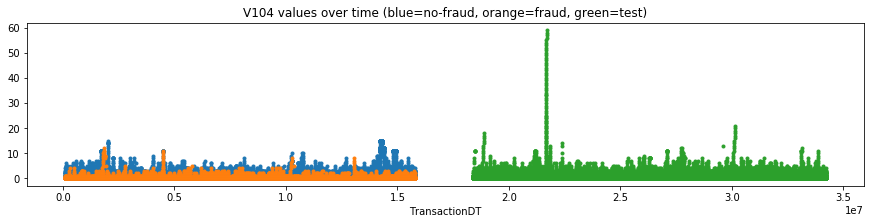

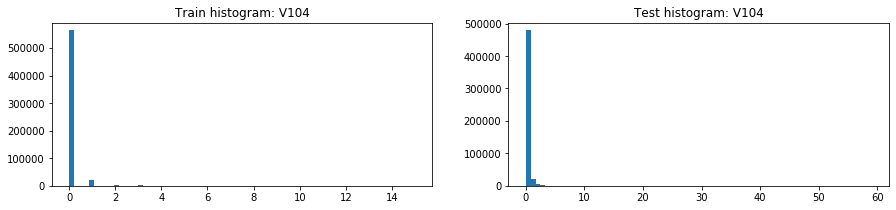

V104          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.085433      0.097307         0.085003   
2             std       0.648718      0.482461         0.653947   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      15.000000     12.000000        15.000000   
8   unique values      17.000000     14.000000        17.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.081497       0.103692       0.075949  
2        0.557815       0.972010       0.390631  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       59.000000      59.000000      21.000000  
8       60.000000      60.000000      22.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V104  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 563527     0.034220       19284       478742.0
1    1.0                  19375     0.052594        1019        21068.0
2    2.0                   4089     0.053069         217         4583.0
3    3.0                   1126     0.064831          73         1325.0
4   11.0                   1000     0.003000           3           32.0
5    4.0                    401     0.047382          19          430.0
6 -999.0                    314     0.054140          17            NaN
7   15.0                    215     0.000000           0            4.0
8    5.0                    169     0.047337           8          183.0
9    6.0                     93     0.043011           4           95.0

V104  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          563527     0.034220              19284       478742.0
1    1.0           19375     0.052594               1019        21068.0
2    2.0            4089     0.053069                217         4583.0
3    3.0            1126     0.064831                 73         1325.0
4    4.0             401     0.047382                 19          430.0
5 -999.0             314     0.054140                 17            NaN
6    5.0             169     0.047337                  8          183.0
7    9.0              23     0.260870                  6           17.0
8    8.0              39     0.128205                  5           49.0
9    6.0              93     0.043011                  4           95.0

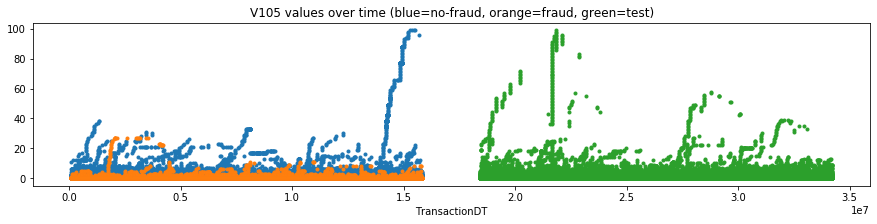

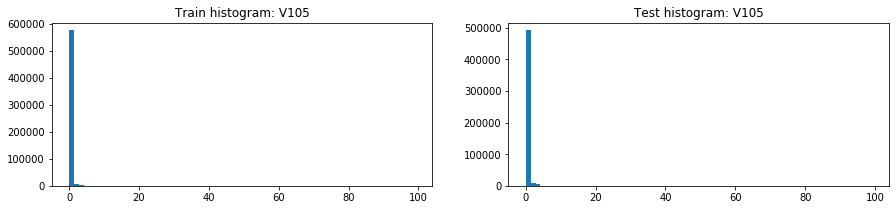

V105          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.281145      0.223917         0.283219   
2             std       3.373948      1.229567         3.426548   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      99.000000     27.000000        99.000000   
8   unique values     101.000000     29.000000       101.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.188436       0.255716       0.171616  
2        1.493119       2.254587       1.230671  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       99.000000      95.000000      99.000000  
8      100.000000      96.000000      76.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V105  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 547750     0.033855       18544       460547.0
1    1.0                  27711     0.047959        1329        30604.0
2    2.0                   7508     0.047816         359         8562.0
3    3.0                   2566     0.061185         157         3091.0
4    4.0                   1103     0.072529          80         1298.0
5   77.0                    871     0.000000           0            1.0
6    5.0                    603     0.082919          50          771.0
7    6.0                    418     0.078947          33          360.0
8 -999.0                    314     0.054140          17            NaN
9    7.0                    251     0.055777          14          270.0

V105  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          547750     0.033855              18544       460547.0
1    1.0           27711     0.047959               1329        30604.0
2    2.0            7508     0.047816                359         8562.0
3    3.0            2566     0.061185                157         3091.0
4    4.0            1103     0.072529                 80         1298.0
5    5.0             603     0.082919                 50          771.0
6    6.0             418     0.078947                 33          360.0
7    8.0             149     0.127517                 19          184.0
8 -999.0             314     0.054140                 17            NaN
9    7.0             251     0.055777                 14          270.0

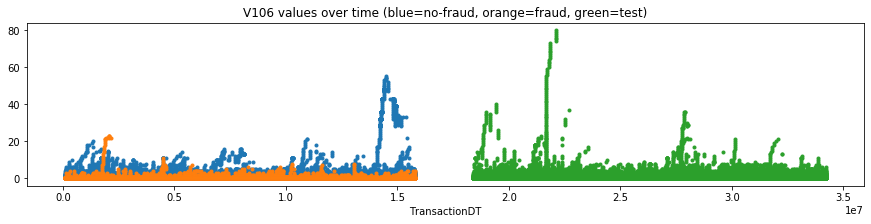

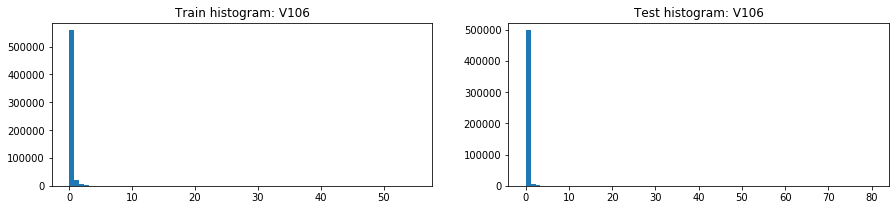

V106          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       0.164584      0.144532         0.165311   
2             std       1.825665      0.781436         1.852491   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      55.000000     23.000000        55.000000   
8   unique values      57.000000     25.000000        57.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.114971       0.148709       0.106537  
2        0.878800       1.225099       0.767977  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       80.000000      59.000000      80.000000  
8       81.000000      60.000000      59.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V106  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 558074     0.033908       18923       472971.0
1    1.0                  22306     0.053080        1184        23968.0
2    2.0                   5381     0.057796         311         5914.0
3    3.0                   1590     0.072956         116         1868.0
4    4.0                    595     0.082353          49          731.0
5   35.0                    419     0.000000           0            4.0
6    5.0                    317     0.056782          18          379.0
7 -999.0                    314     0.054140          17            NaN
8   39.0                    224     0.000000           0            2.0
9   32.0                    176     0.000000           0            5.0

V106  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          558074     0.033908              18923       472971.0
1    1.0           22306     0.053080               1184        23968.0
2    2.0            5381     0.057796                311         5914.0
3    3.0            1590     0.072956                116         1868.0
4    4.0             595     0.082353                 49          731.0
5    5.0             317     0.056782                 18          379.0
6 -999.0             314     0.054140                 17            NaN
7    6.0             140     0.071429                 10          199.0
8    7.0              79     0.088608                  7          148.0
9    8.0              73     0.054795                  4           82.0

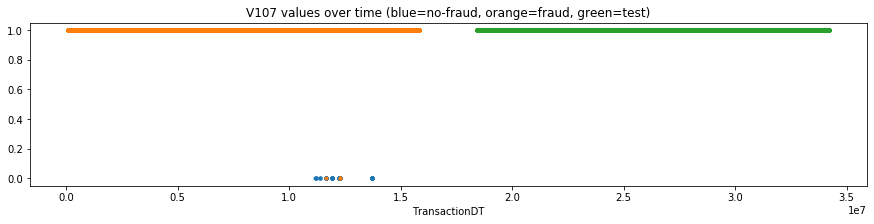

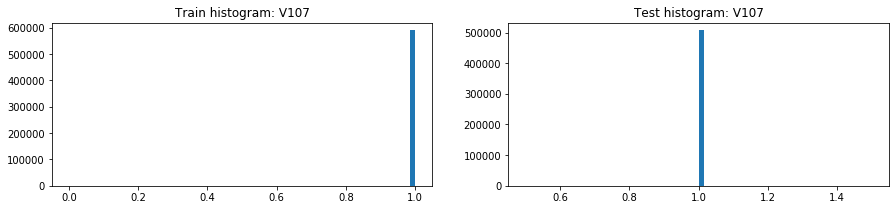

V107          Train   Train fraud  Train Not fraud      Test  \
0           count  590226.000000  20646.000000    569580.000000  506691.0   
1            mean       0.999580      0.999855         0.999570       1.0   
2             std       0.020494      0.012054         0.020735       0.0   
3             min       0.000000      0.000000         0.000000       1.0   
4             25%       1.000000      1.000000         1.000000       1.0   
5             50%       1.000000      1.000000         1.000000       1.0   
6             75%       1.000000      1.000000         1.000000       1.0   
7             max       1.000000      1.000000         1.000000       1.0   
8   unique values       3.000000      3.000000         3.000000       1.0   
9            NaNs     314.000000     17.000000       297.000000       0.0   
10     NaNs share       0.000500      0.000800         0.000500       0.0   

    Test public  Test private  
0      101339.0      405353.0  
1           1.0           1.0  
2           0.0           0.0  
3           1.0           1.0  
4           1.0           1.0  
5           1.0           1.0  
6           1.0           1.0  
7           1.0           1.0  
8           1.0           1.0  
9           0.0           0.0  
10          0.0           0.0

V107  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 589978     0.034989       20643       506691.0
1 -999.0                    314     0.054140          17            NaN
2    0.0                    248     0.012097           3            NaN

V107  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          589978     0.034989              20643       506691.0
1 -999.0             314     0.054140                 17            NaN
2    0.0             248     0.012097                  3            NaN

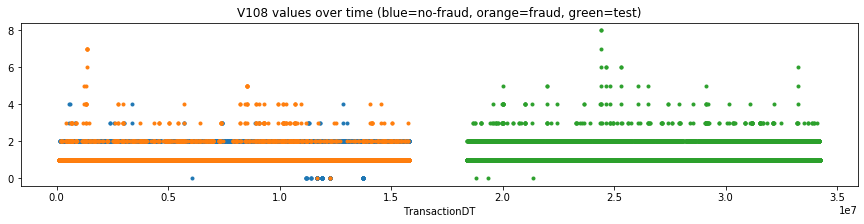

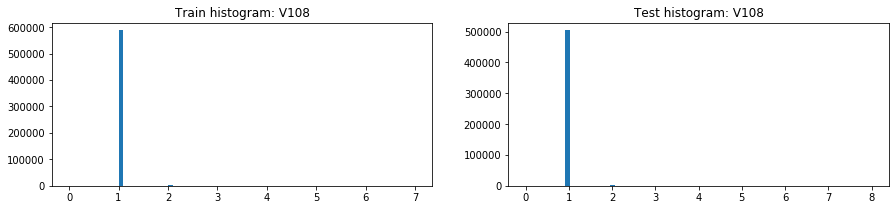

V108          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.004613      1.045868         1.003118   
2             std       0.081146      0.270586         0.064075   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      7.000000         4.000000   
8   unique values       9.000000      9.000000         6.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.006973       1.008585       1.006570  
2        0.093677       0.101428       0.091632  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        8.000000       5.000000       8.000000  
8        9.000000       6.000000       8.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V108  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 587242     0.033880       19896       503470.0
1    2.0                   2566     0.236945         608         2993.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    249     0.012048           3            3.0
4    3.0                    122     0.786885          96          166.0
5    4.0                     35     0.885714          31           39.0
6    5.0                      7     1.000000           7           11.0
7    7.0                      4     1.000000           4            1.0
8    6.0                      1     1.000000           1            6.0

V108  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          587242     0.033880              19896       503470.0
1    2.0            2566     0.236945                608         2993.0
2    3.0             122     0.786885                 96          166.0
3    4.0              35     0.885714                 31           39.0
4 -999.0             314     0.054140                 17            NaN
5    5.0               7     1.000000                  7           11.0
6    7.0               4     1.000000                  4            1.0
7    0.0             249     0.012048                  3            3.0
8    6.0               1     1.000000                  1            6.0

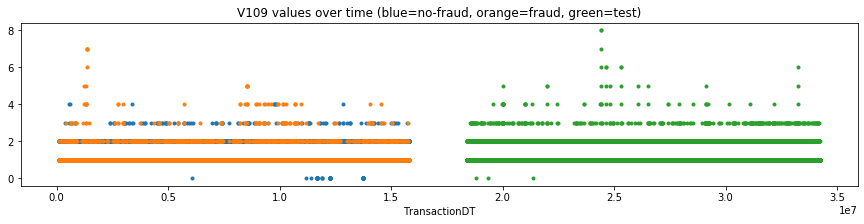

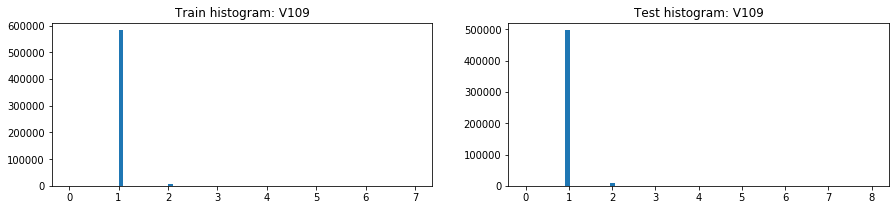

V109          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.014816      1.055749         1.013333   
2             std       0.127769      0.287870         0.117687   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      7.000000         4.000000   
8   unique values       9.000000      8.000000         6.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.020756       1.024956       1.019706  
2        0.151220       0.164670       0.147648  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        8.000000       5.000000       8.000000  
8        9.000000       6.000000       8.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V109  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 581702     0.033876       19706       496661.0
1    2.0                   8198     0.097097         796         9627.0
2 -999.0                    314     0.054140          17            NaN
3    3.0                    212     0.462264          98          341.0
4    0.0                     60     0.000000           0            3.0
5    4.0                     42     0.809524          34           39.0
6    5.0                      7     1.000000           7           11.0
7    7.0                      4     1.000000           4            1.0
8    6.0                      1     1.000000           1            6.0

V109  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          581702     0.033876              19706       496661.0
1    2.0            8198     0.097097                796         9627.0
2    3.0             212     0.462264                 98          341.0
3    4.0              42     0.809524                 34           39.0
4 -999.0             314     0.054140                 17            NaN
5    5.0               7     1.000000                  7           11.0
6    7.0               4     1.000000                  4            1.0
7    6.0               1     1.000000                  1            6.0
8    0.0              60     0.000000                  0            3.0

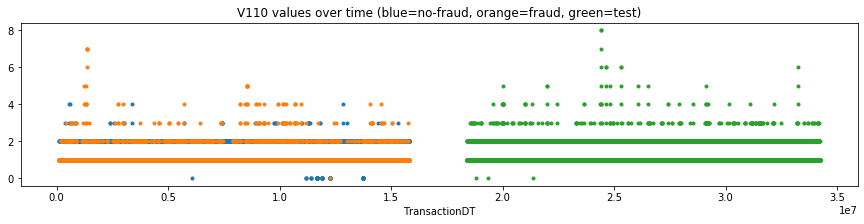

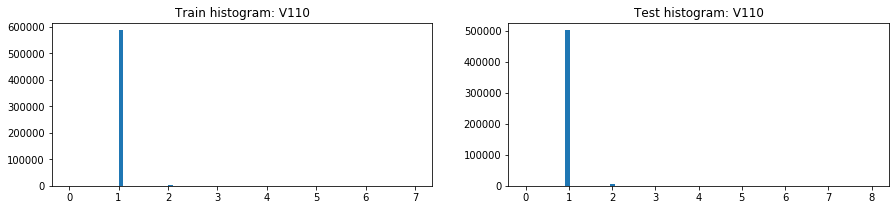

V110          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.007739      1.049453         1.006227   
2             std       0.097290      0.276163         0.083539   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      7.000000         4.000000   
8   unique values       9.000000      9.000000         6.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.010740       1.013430       1.010068  
2        0.112401       0.123942       0.109316  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        8.000000       5.000000       8.000000  
8        9.000000       6.000000       8.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V110  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 585561     0.033858       19826       501601.0
1    2.0                   4308     0.157846         680         4822.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    174     0.005747           1            3.0
4    3.0                    136     0.705882          96          206.0
5    4.0                     35     0.885714          31           39.0
6    5.0                      7     1.000000           7           11.0
7    7.0                      4     1.000000           4            1.0
8    6.0                      1     1.000000           1            6.0

V110  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          585561     0.033858              19826       501601.0
1    2.0            4308     0.157846                680         4822.0
2    3.0             136     0.705882                 96          206.0
3    4.0              35     0.885714                 31           39.0
4 -999.0             314     0.054140                 17            NaN
5    5.0               7     1.000000                  7           11.0
6    7.0               4     1.000000                  4            1.0
7    0.0             174     0.005747                  1            3.0
8    6.0               1     1.000000                  1            6.0

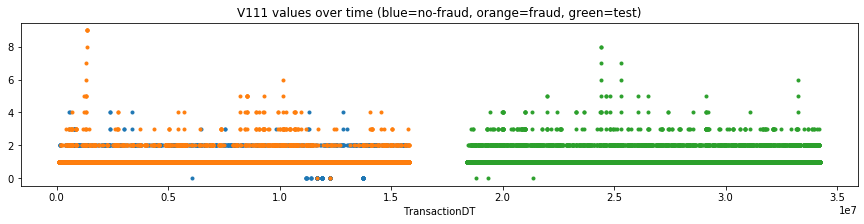

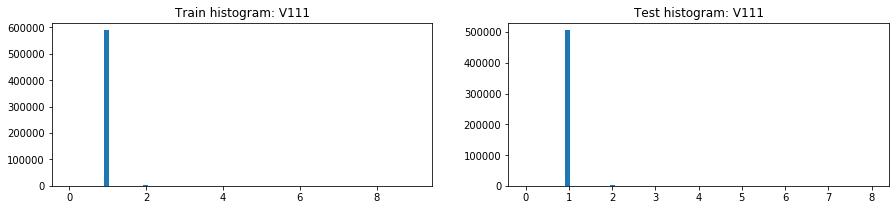

V111          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.002563      1.047806         1.000923   
2             std       0.070830      0.296407         0.044016   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       9.000000      9.000000         4.000000   
8   unique values      11.000000     11.000000         6.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.004188       1.005013       1.003982  
2        0.077498       0.082841       0.076102  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        8.000000       4.000000       8.000000  
8        9.000000       5.000000       8.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V111  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 588499     0.033817       19901       504886.0
1    2.0                   1293     0.453210         586         1566.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    249     0.012048           3            3.0
4    3.0                    129     0.829457         107          180.0
5    4.0                     36     0.805556          29           38.0
6    5.0                     12     1.000000          12           11.0
7    9.0                      4     1.000000           4            NaN
8    6.0                      2     1.000000           2            3.0
9    7.0                      1     1.000000           1            2.0

V111  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          588499     0.033817              19901       504886.0
1    2.0            1293     0.453210                586         1566.0
2    3.0             129     0.829457                107          180.0
3    4.0              36     0.805556                 29           38.0
4 -999.0             314     0.054140                 17            NaN
5    5.0              12     1.000000                 12           11.0
6    9.0               4     1.000000                  4            NaN
7    0.0             249     0.012048                  3            3.0
8    6.0               2     1.000000                  2            3.0
9    7.0               1     1.000000                  1            2.0

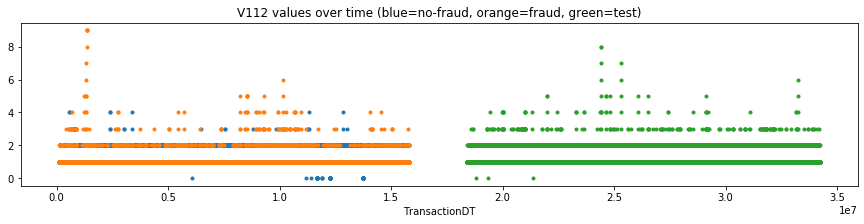

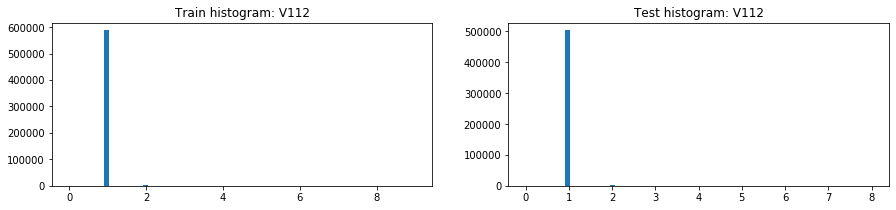

V112          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.005356      1.052117         1.003661   
2             std       0.084617      0.302562         0.063399   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       9.000000      9.000000         4.000000   
8   unique values      11.000000     10.000000         6.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.007865       1.009069       1.007564  
2        0.098856       0.104312       0.097442  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        8.000000       4.000000       8.000000  
8        9.000000       5.000000       8.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V112  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 587233     0.033750       19819       503055.0
1    2.0                   2744     0.244169         670         3367.0
2 -999.0                    314     0.054140          17            NaN
3    3.0                    133     0.812030         108          208.0
4    0.0                     60     0.000000           0            3.0
5    4.0                     36     0.805556          29           40.0
6    5.0                     12     1.000000          12           11.0
7    9.0                      4     1.000000           4            NaN
8    6.0                      2     1.000000           2            3.0
9    7.0                      1     1.000000           1            2.0

V112  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          587233     0.033750              19819       503055.0
1    2.0            2744     0.244169                670         3367.0
2    3.0             133     0.812030                108          208.0
3    4.0              36     0.805556                 29           40.0
4 -999.0             314     0.054140                 17            NaN
5    5.0              12     1.000000                 12           11.0
6    9.0               4     1.000000                  4            NaN
7    6.0               2     1.000000                  2            3.0
8    7.0               1     1.000000                  1            2.0
9    8.0               1     1.000000                  1            2.0

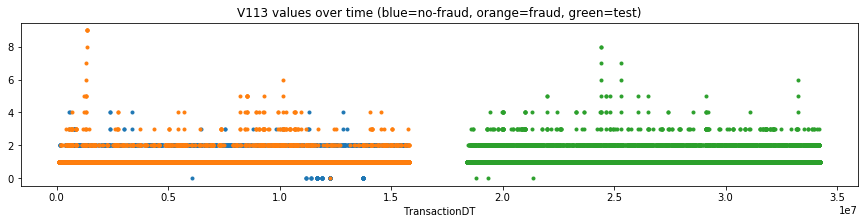

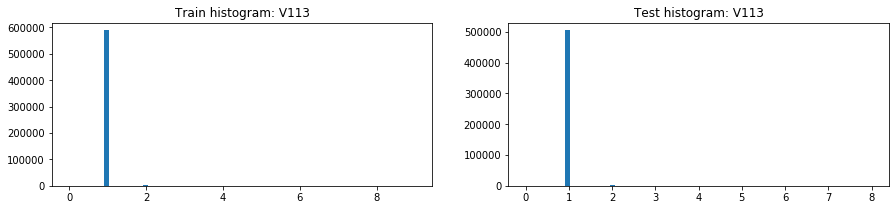

V113          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.003383      1.048920         1.001733   
2             std       0.074754      0.297938         0.049953   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       9.000000      9.000000         4.000000   
8   unique values      11.000000     11.000000         6.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.005202       1.006187       1.004956  
2        0.084060       0.089576       0.082621  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        8.000000       4.000000       8.000000  
8        9.000000       5.000000       8.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V113  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 588168     0.033805       19883       504386.0
1    2.0                   1696     0.356722         605         2052.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    174     0.005747           1            3.0
4    3.0                    132     0.818182         108          194.0
5    4.0                     36     0.805556          29           38.0
6    5.0                     12     1.000000          12           11.0
7    9.0                      4     1.000000           4            NaN
8    6.0                      2     1.000000           2            3.0
9    7.0                      1     1.000000           1            2.0

V113  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          588168     0.033805              19883       504386.0
1    2.0            1696     0.356722                605         2052.0
2    3.0             132     0.818182                108          194.0
3    4.0              36     0.805556                 29           38.0
4 -999.0             314     0.054140                 17            NaN
5    5.0              12     1.000000                 12           11.0
6    9.0               4     1.000000                  4            NaN
7    6.0               2     1.000000                  2            3.0
8    0.0             174     0.005747                  1            3.0
9    7.0               1     1.000000                  1            2.0

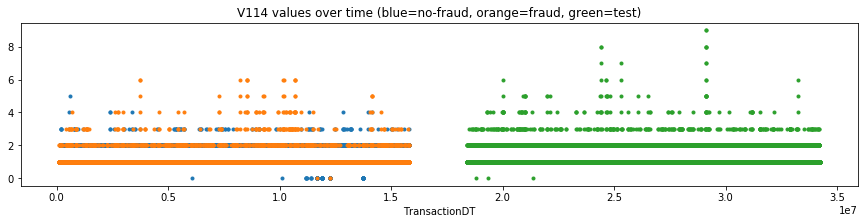

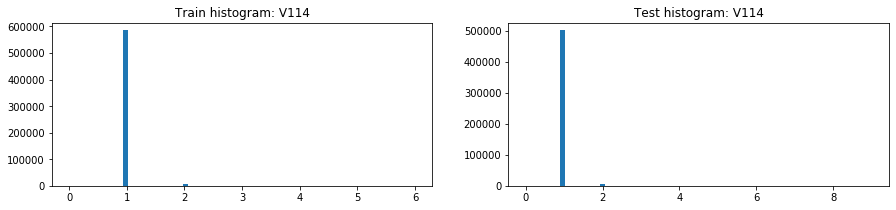

V114          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.009298      1.064904         1.007283   
2             std       0.110179      0.327406         0.092617   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         5.000000   
8   unique values       8.000000      8.000000         7.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.013608       1.016203       1.012959  
2        0.132229       0.142209       0.129605  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        9.000000       6.000000       9.000000  
8       10.000000       7.000000       9.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V114  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 584688     0.033563       19624       500456.0
1    2.0                   4954     0.161688         801         5772.0
2 -999.0                    314     0.054140          17            NaN
3    3.0                    255     0.580392         148          338.0
4    0.0                    250     0.012000           3            3.0
5    4.0                     53     0.849057          45           77.0
6    5.0                     15     0.933333          14           26.0
7    6.0                     11     1.000000          11            8.0

V114  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          584688     0.033563              19624       500456.0
1    2.0            4954     0.161688                801         5772.0
2    3.0             255     0.580392                148          338.0
3    4.0              53     0.849057                 45           77.0
4 -999.0             314     0.054140                 17            NaN
5    5.0              15     0.933333                 14           26.0
6    6.0              11     1.000000                 11            8.0
7    0.0             250     0.012000                  3            3.0

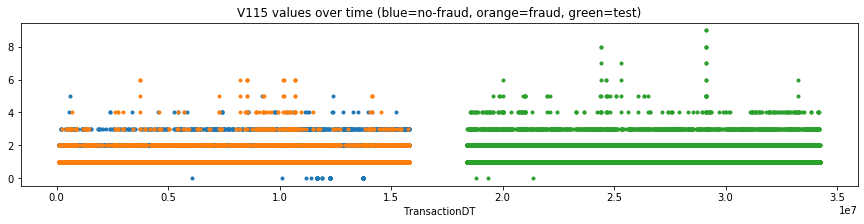

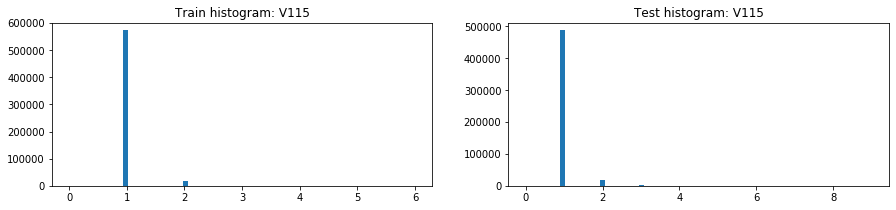

V115          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.032450      1.089557         1.030380   
2             std       0.190385      0.365993         0.180506   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         5.000000   
8   unique values       8.000000      7.000000         7.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.043129       1.049922       1.041431  
2        0.223200       0.239576       0.218882  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        9.000000       6.000000       9.000000  
8       10.000000       7.000000       9.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V115  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 572121     0.033528       19182       486514.0
1    2.0                  17024     0.069784        1188        18812.0
2    3.0                    909     0.223322         203         1133.0
3 -999.0                    314     0.054140          17            NaN
4    4.0                     83     0.578313          48          177.0
5    0.0                     61     0.000000           0            3.0
6    5.0                     17     0.823529          14           33.0
7    6.0                     11     1.000000          11            8.0

V115  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          572121     0.033528              19182       486514.0
1    2.0           17024     0.069784               1188        18812.0
2    3.0             909     0.223322                203         1133.0
3    4.0              83     0.578313                 48          177.0
4 -999.0             314     0.054140                 17            NaN
5    5.0              17     0.823529                 14           33.0
6    6.0              11     1.000000                 11            8.0
7    0.0              61     0.000000                  0            3.0

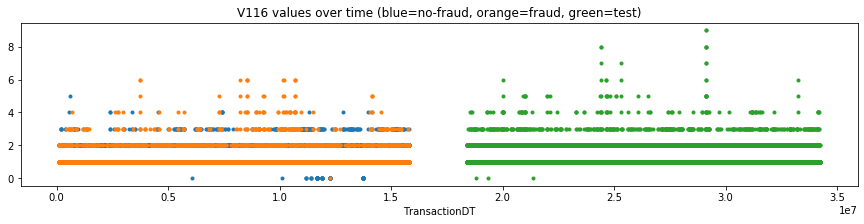

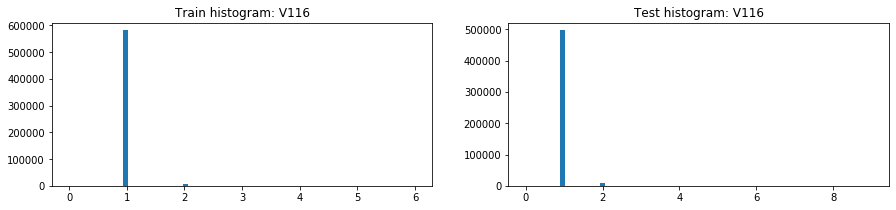

V116          Train  Train fraud  Train Not fraud           Test  \
0           count  590226.000000  20646.00000    569580.000000  506691.000000   
1            mean       1.015738      1.07367         1.013638       1.021445   
2             std       0.136770      0.34017         0.122735       0.161190   
3             min       0.000000      0.00000         0.000000       0.000000   
4             25%       1.000000      1.00000         1.000000       1.000000   
5             50%       1.000000      1.00000         1.000000       1.000000   
6             75%       1.000000      1.00000         1.000000       1.000000   
7             max       6.000000      6.00000         5.000000       9.000000   
8   unique values       8.000000      8.00000         7.000000      10.000000   
9            NaNs     314.000000     17.00000       297.000000       0.000000   
10     NaNs share       0.000500      0.00080         0.000500       0.000000   

      Test public   Test private  
0   101339.000000  405353.000000  
1        1.025203       1.020506  
2        0.172963       0.158096  
3        0.000000       1.000000  
4        1.000000       1.000000  
5        1.000000       1.000000  
6        1.000000       1.000000  
7        6.000000       9.000000  
8        7.000000       9.000000  
9        0.000000       0.000000  
10       0.000000       0.000000

V116  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 581192     0.033481       19459       496697.0
1    2.0                   8375     0.114149         956         9342.0
2    3.0                    400     0.400000         160          506.0
3 -999.0                    314     0.054140          17            NaN
4    0.0                    175     0.005714           1            3.0
5    4.0                     58     0.775862          45           96.0
6    5.0                     15     0.933333          14           28.0
7    6.0                     11     1.000000          11            8.0

V116  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          581192     0.033481              19459       496697.0
1    2.0            8375     0.114149                956         9342.0
2    3.0             400     0.400000                160          506.0
3    4.0              58     0.775862                 45           96.0
4 -999.0             314     0.054140                 17            NaN
5    5.0              15     0.933333                 14           28.0
6    6.0              11     1.000000                 11            8.0
7    0.0             175     0.005714                  1            3.0

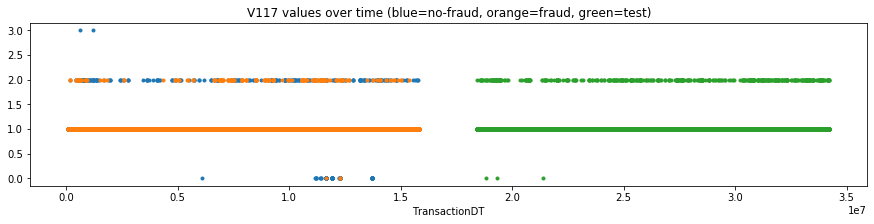

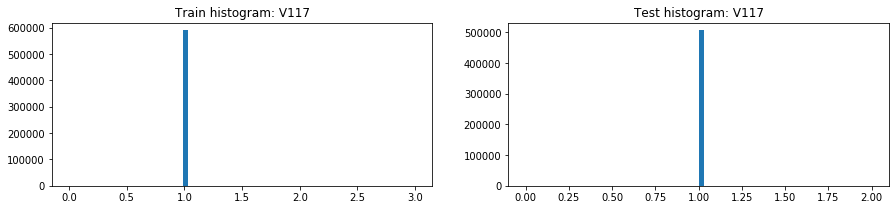

V117          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.000391      1.009542         1.000060   
2             std       0.035238      0.098701         0.030504   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      2.000000         3.000000   
8   unique values       5.000000      4.000000         5.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.000943       1.000780       1.000984  
2        0.030892       0.028951       0.031359  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        2.000000       2.000000       2.000000  
8        3.000000       3.000000       2.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V117  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 589499     0.034679       20443       506207.0
1    2.0                    476     0.420168         200          481.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    249     0.012048           3            3.0
4    3.0                      2     0.000000           0            NaN

V117  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          589499     0.034679              20443       506207.0
1    2.0             476     0.420168                200          481.0
2 -999.0             314     0.054140                 17            NaN
3    0.0             249     0.012048                  3            3.0
4    3.0               2     0.000000                  0            NaN

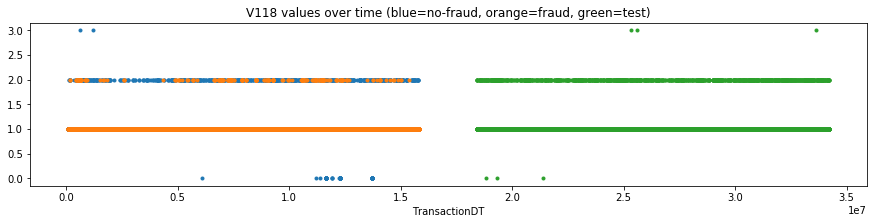

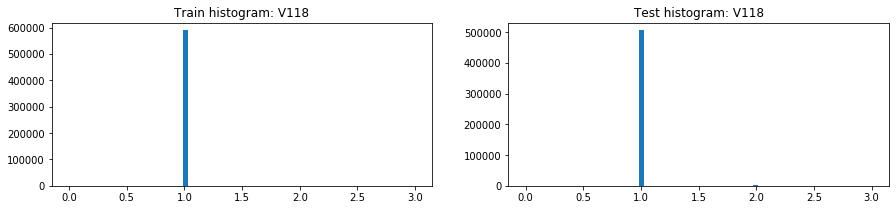

V118          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.001474      1.010220         1.001157   
2             std       0.041011      0.100578         0.037059   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      2.000000         3.000000   
8   unique values       5.000000      3.000000         5.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.002297       1.002013       1.002368  
2        0.048121       0.045478       0.048760  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        3.000000       2.000000       3.000000  
8        4.000000       3.000000       3.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V118  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 589238     0.034680       20435       505524.0
1    2.0                    926     0.227862         211         1161.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                     60     0.000000           0            3.0
4    3.0                      2     0.000000           0            3.0

V118  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          589238     0.034680              20435       505524.0
1    2.0             926     0.227862                211         1161.0
2 -999.0             314     0.054140                 17            NaN
3    0.0              60     0.000000                  0            3.0
4    3.0               2     0.000000                  0            3.0

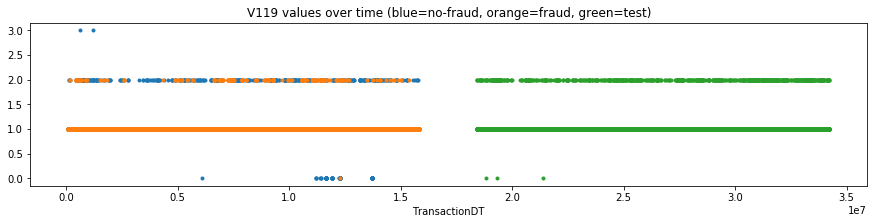

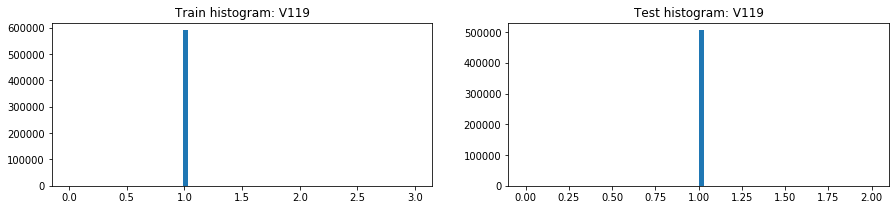

V119          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.000729      1.009929         1.000395   
2             std       0.036392      0.099640         0.031770   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      2.000000         3.000000   
8   unique values       5.000000      4.000000         5.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.001449       1.001204       1.001510  
2        0.038188       0.035520       0.038827  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        2.000000       2.000000       2.000000  
8        3.000000       3.000000       2.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V119  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 589450     0.034675       20439       505951.0
1    2.0                    600     0.343333         206          737.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    174     0.005747           1            3.0
4    3.0                      2     0.000000           0            NaN

V119  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          589450     0.034675              20439       505951.0
1    2.0             600     0.343333                206          737.0
2 -999.0             314     0.054140                 17            NaN
3    0.0             174     0.005747                  1            3.0
4    3.0               2     0.000000                  0            NaN

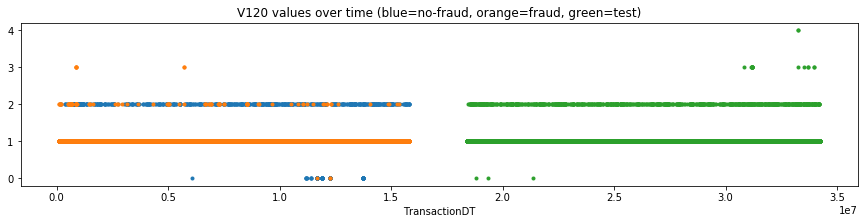

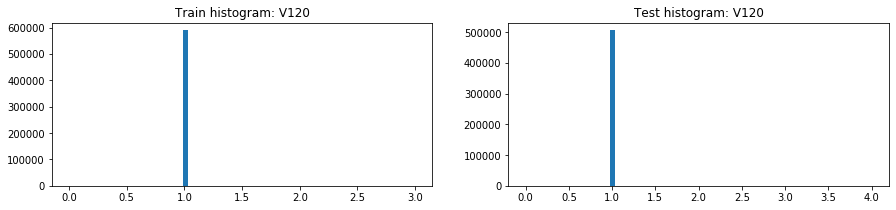

V120          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.000874      1.005183         1.000718   
2             std       0.041684      0.077639         0.039766   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      3.000000         2.000000   
8   unique values       5.000000      5.000000         4.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.001796       1.001776       1.001801  
2        0.043536       0.042805       0.043717  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        4.000000       2.000000       4.000000  
8        5.000000       3.000000       4.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V120  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 589218     0.034858       20539       505796.0
1    2.0                    753     0.130146          98          873.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    249     0.012048           3            3.0
4    3.0                      6     1.000000           6           17.0

V120  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          589218     0.034858              20539       505796.0
1    2.0             753     0.130146                 98          873.0
2 -999.0             314     0.054140                 17            NaN
3    3.0               6     1.000000                  6           17.0
4    0.0             249     0.012048                  3            3.0

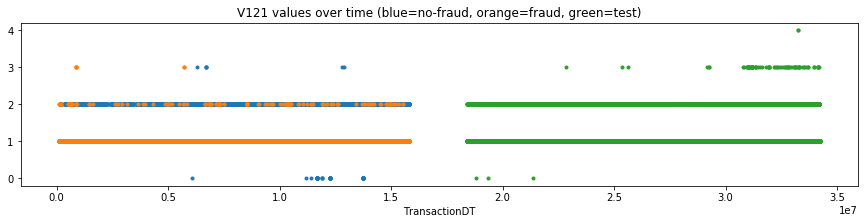

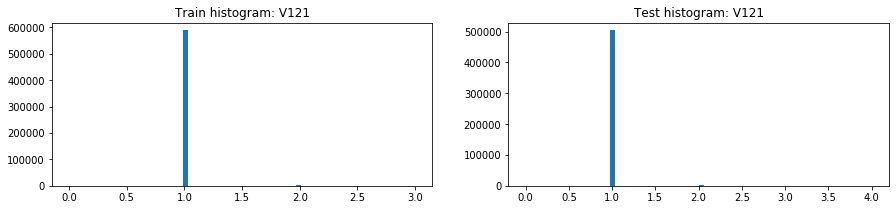

V121          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.004276      1.008622         1.004119   
2             std       0.067097      0.095545         0.065830   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      3.000000         3.000000   
8   unique values       5.000000      4.000000         5.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.006442       1.007056       1.006288  
2        0.082192       0.084054       0.081719  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        4.000000       2.000000       4.000000  
8        5.000000       3.000000       4.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V121  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 587594     0.034844       20474       503506.0
1    2.0                   2560     0.064844         166         3099.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                     60     0.000000           0            3.0
4    3.0                     12     0.500000           6           81.0

V121  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          587594     0.034844              20474       503506.0
1    2.0            2560     0.064844                166         3099.0
2 -999.0             314     0.054140                 17            NaN
3    3.0              12     0.500000                  6           81.0
4    0.0              60     0.000000                  0            3.0

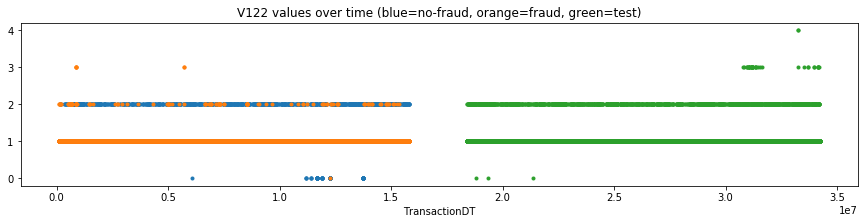

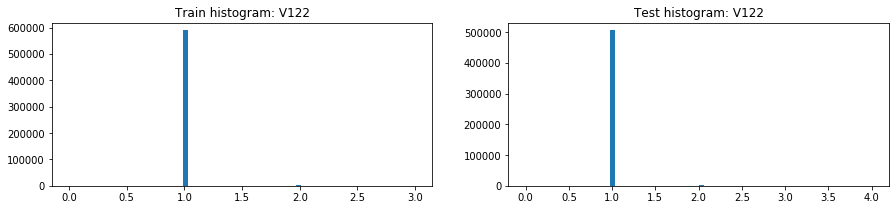

V122          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.001759      1.006539         1.001585   
2             std       0.048636      0.084702         0.046801   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      3.000000         2.000000   
8   unique values       5.000000      5.000000         4.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.002992       1.003039       1.002980  
2        0.056395       0.055582       0.056596  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7        4.000000       2.000000       4.000000  
8        5.000000       3.000000       4.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V122  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 588846     0.034839       20515       505214.0
1    2.0                   1200     0.103333         124         1431.0
2 -999.0                    314     0.054140          17            NaN
3    0.0                    174     0.005747           1            3.0
4    3.0                      6     1.000000           6           41.0

V122  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          588846     0.034839              20515       505214.0
1    2.0            1200     0.103333                124         1431.0
2 -999.0             314     0.054140                 17            NaN
3    3.0               6     1.000000                  6           41.0
4    0.0             174     0.005747                  1            3.0

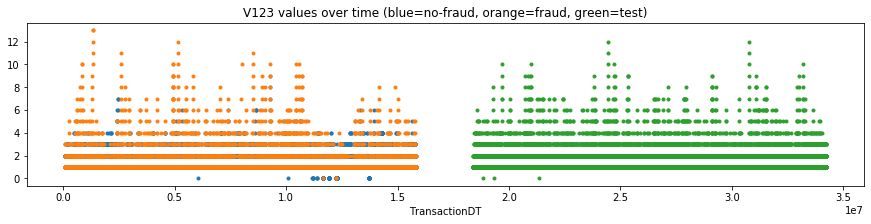

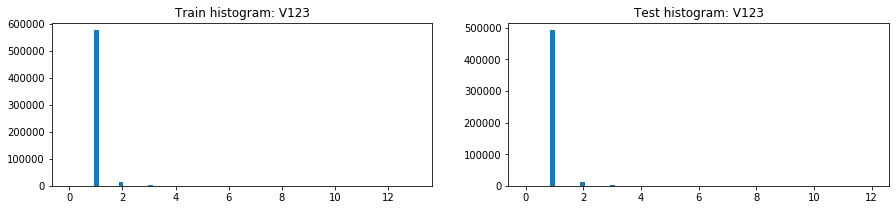

V123          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.031120      1.196745         1.025117   
2             std       0.228134      0.768501         0.177467   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      13.000000     13.000000         9.000000   
8   unique values      15.000000     15.000000        11.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.037607       1.042126       1.036477  
2        0.251355       0.268894       0.246763  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       12.000000      10.000000      12.000000  
8       13.000000      11.000000      12.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V123  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 574712     0.032202       18507       491299.0
1    2.0                  13214     0.096791        1279        13272.0
2    3.0                   1423     0.284610         405         1370.0
3    4.0                    339     0.584071         198          367.0
4 -999.0                    314     0.054140          17            NaN
5    0.0                    250     0.012000           3            3.0
6    5.0                    127     0.850394         108          171.0
7    6.0                     65     0.846154          55           92.0
8    7.0                     35     0.914286          32           62.0
9    8.0                     24     0.958333          23           27.0

V123  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          574712     0.032202              18507       491299.0
1    2.0           13214     0.096791               1279        13272.0
2    3.0            1423     0.284610                405         1370.0
3    4.0             339     0.584071                198          367.0
4    5.0             127     0.850394                108          171.0
5    6.0              65     0.846154                 55           92.0
6    7.0              35     0.914286                 32           62.0
7    8.0              24     0.958333                 23           27.0
8 -999.0             314     0.054140                 17            NaN
9    9.0              17     0.941176                 16           18.0

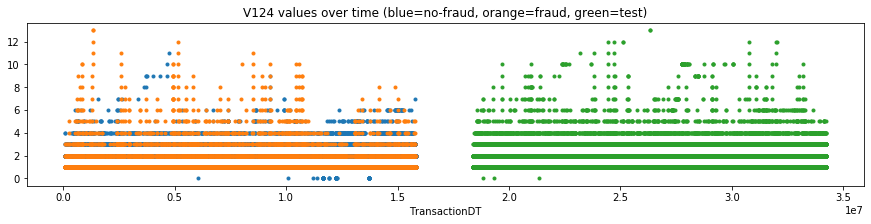

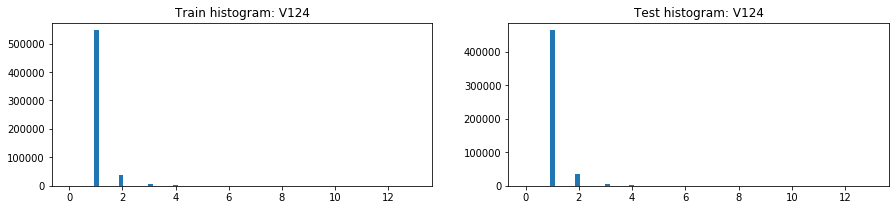

V124          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.092975      1.243728         1.087510   
2             std       0.374103      0.805333         0.347368   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      13.000000     13.000000        11.000000   
8   unique values      15.000000     14.000000        13.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.106114       1.117566       1.103251  
2        0.407922       0.413719       0.406410  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       13.000000      10.000000      13.000000  
8       14.000000      11.000000      13.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V124  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 546045     0.032580       17790       463461.0
1    2.0                  36778     0.048997        1802        36225.0
2    3.0                   4856     0.117586         571         5177.0
3    4.0                   2004     0.108782         218         1095.0
4 -999.0                    314     0.054140          17            NaN
5    5.0                    243     0.469136         114          344.0
6    6.0                    126     0.468254          59          158.0
7    0.0                     61     0.000000           0            3.0
8    7.0                     41     0.780488          32           77.0
9    8.0                     26     0.884615          23           35.0

V124  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          546045     0.032580              17790       463461.0
1    2.0           36778     0.048997               1802        36225.0
2    3.0            4856     0.117586                571         5177.0
3    4.0            2004     0.108782                218         1095.0
4    5.0             243     0.469136                114          344.0
5    6.0             126     0.468254                 59          158.0
6    7.0              41     0.780488                 32           77.0
7    8.0              26     0.884615                 23           35.0
8 -999.0             314     0.054140                 17            NaN
9    9.0              24     0.708333                 17           37.0

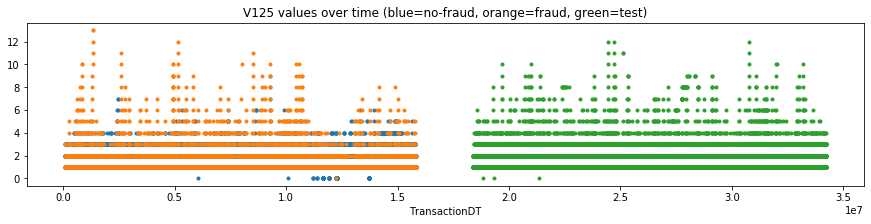

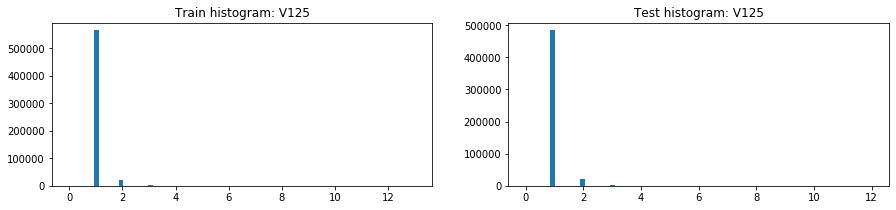

V125          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.050415      1.215151         1.044443   
2             std       0.280037      0.781981         0.240997   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      13.000000     13.000000         9.000000   
8   unique values      15.000000     15.000000        11.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        1.056028       1.062770       1.054343  
2        0.303396       0.316383       0.300038  
3        0.000000       0.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       12.000000      10.000000      12.000000  
8       13.000000      11.000000      12.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V125  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 565575     0.032188       18205       483588.0
1    2.0                  20819     0.073539        1531        19969.0
2    3.0                   2567     0.172575         443         2123.0
3    4.0                    774     0.266150         206          510.0
4 -999.0                    314     0.054140          17            NaN
5    0.0                    175     0.005714           1            3.0
6    5.0                    152     0.736842         112          206.0
7    6.0                     68     0.838235          57          110.0
8    7.0                     35     0.914286          32           73.0
9    8.0                     24     0.958333          23           64.0

V125  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          565575     0.032188              18205       483588.0
1    2.0           20819     0.073539               1531        19969.0
2    3.0            2567     0.172575                443         2123.0
3    4.0             774     0.266150                206          510.0
4    5.0             152     0.736842                112          206.0
5    6.0              68     0.838235                 57          110.0
6    7.0              35     0.914286                 32           73.0
7    8.0              24     0.958333                 23           64.0
8 -999.0             314     0.054140                 17            NaN
9    9.0              17     0.941176                 16           29.0

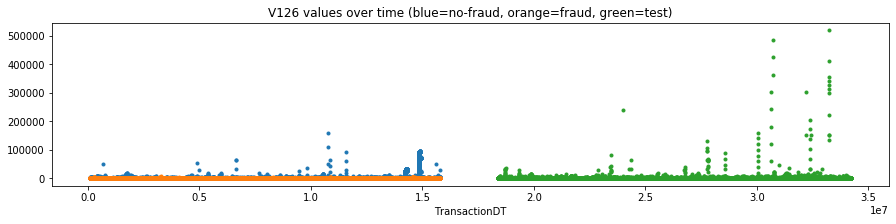

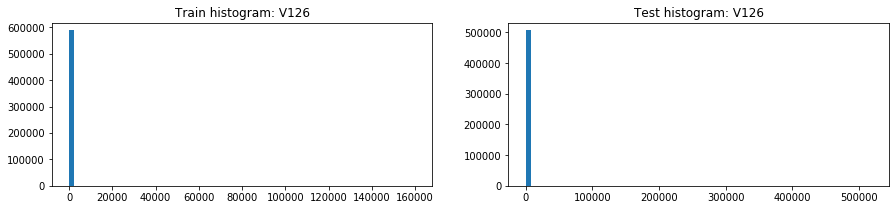

V126          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean     129.979417     86.272554       131.563693   
2             std    2346.951681    284.631132      2388.479348   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     40.000000         0.000000   
7             max  160000.000000   6625.000000    160000.000000   
8   unique values   10300.000000   2216.000000      9307.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       65.612052      53.622632      68.609268  
2     2180.122508     446.098195    2427.214840  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   519038.500000   36720.000000  519038.500000  
8     7845.000000    2971.000000    6618.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V126  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 510542     0.028568       14585       436511.0
1  117.000000                   3407     0.046082         157         3117.0
2   59.000000                   3312     0.037138         123         3104.0
3  100.000000                   2248     0.049822         112         1594.0
4   49.000000                   1753     0.058756         103         1652.0
5  226.000000                   1494     0.062249          93         1460.0
6  107.949997                   1475     0.034576          51         1346.0
7   50.000000                   1460     0.045890          67          923.0
8   57.950001                   1437     0.008351          12         1262.0
9  200.000000                   1434     0.065551          94         1295.0

V126  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          510542     0.028568              14585         436511
1  117.0            3407     0.046082                157           3117
2   59.0            3312     0.037138                123           3104
3  150.0            1185     0.095359                113            794
4  100.0            2248     0.049822                112           1594
5   49.0            1753     0.058756                103           1652
6  300.0             916     0.109170                100            766
7  200.0            1434     0.065551                 94           1295
8  226.0            1494     0.062249                 93           1460
9   50.0            1460     0.045890                 67            923

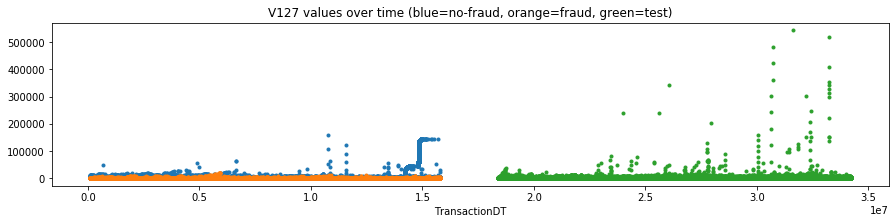

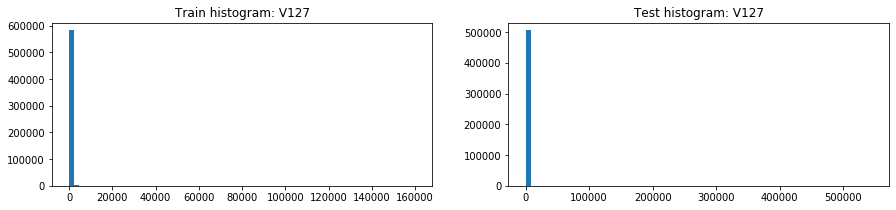

V127          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean     336.611559    278.089451       338.732854   
2             std    4238.666949    898.110844      4311.400223   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%     107.949997    162.579044       107.949997   
7             max  160000.000000  19860.000000    160000.000000   
8   unique values   24415.000000   3822.000000     23110.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1      205.845487     200.905252     207.080294  
2     2545.692423     723.014988    2823.117448  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6      115.900002     136.000000     108.949997  
7   544500.000000   36720.000000  544500.000000  
8    18871.000000    8289.000000   16102.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V127  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 366578     0.032743       12003       308455.0
1  107.949997                   5850     0.009060          53         4964.0
2   57.950001                   5303     0.003960          21         4581.0
3   59.000000                   5152     0.019992         103         4702.0
4  117.000000                   5134     0.028438         146         4685.0
5  100.000000                   3193     0.035077         112         1966.0
6   49.000000                   2569     0.027637          71         2331.0
7   50.000000                   2247     0.030708          69         1257.0
8  226.000000                   2147     0.040056          86         2102.0
9   47.950001                   2081     0.001442           3         1777.0

V127  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          366578     0.032743              12003         308455
1  117.0            5134     0.028438                146           4685
2  150.0            1575     0.071746                113            948
3  100.0            3193     0.035077                112           1966
4  300.0            1139     0.093942                107            869
5   59.0            5152     0.019992                103           4702
6  200.0            1930     0.048705                 94           1544
7  226.0            2147     0.040056                 86           2102
8   49.0            2569     0.027637                 71           2331
9   50.0            2247     0.030708                 69           1257

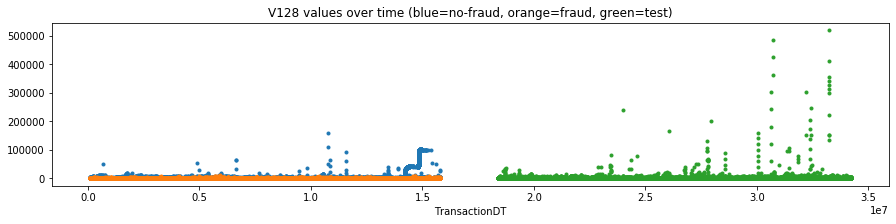

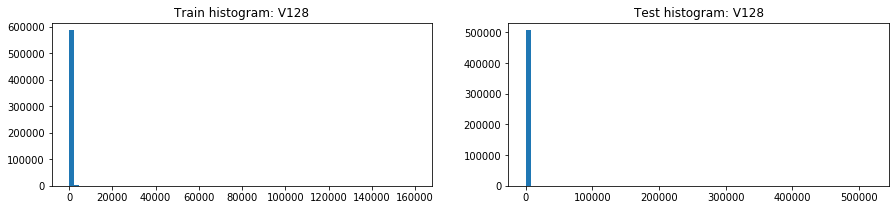

V128          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean     204.094038    173.574554       205.200301   
2             std    3010.258774    561.111545      3062.462466   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    100.000000         0.000000   
7             max  160000.000000  10162.000000    160000.000000   
8   unique values   14508.000000   3047.000000     13352.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1      106.361069      94.831101     109.243320  
2     2282.943655     512.652219    2539.497012  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000      25.950001       0.000000  
7   519038.500000   36720.000000  519038.500000  
8    10913.000000    4490.000000    9270.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V128  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 454213     0.028416       12907       385324.0
1  117.000000                   5259     0.029663         156         4831.0
2   59.000000                   5120     0.023242         119         4893.0
3   57.950001                   3345     0.007175          24         2788.0
4  107.949997                   2846     0.019677          56         2422.0
5  100.000000                   2582     0.043377         112         1796.0
6   49.000000                   2579     0.031020          80         2514.0
7  226.000000                   2152     0.047398         102         2207.0
8   50.000000                   1826     0.040526          74         1157.0
9   39.000000                   1787     0.022943          41         1636.0

V128  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          454213     0.028416              12907         385324
1  117.0            5259     0.029663                156           4831
2   59.0            5120     0.023242                119           4893
3  150.0            1332     0.087838                117            868
4  100.0            2582     0.043377                112           1796
5  300.0            1019     0.105986                108            813
6  226.0            2152     0.047398                102           2207
7  200.0            1590     0.059748                 95           1418
8   49.0            2579     0.031020                 80           2514
9   50.0            1826     0.040526                 74           1157

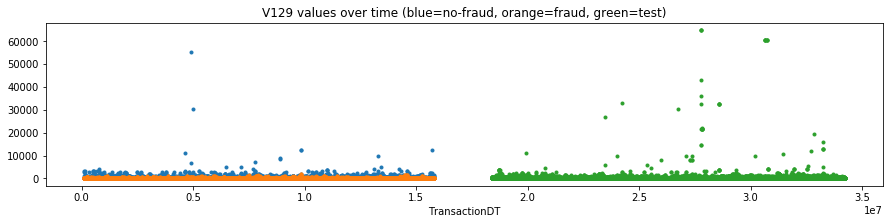

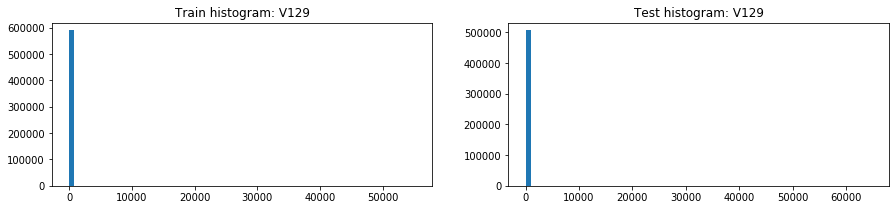

V129          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       8.768944     16.380528         8.493041   
2             std     113.832828     83.478865       114.773011   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   1768.000000     55125.000000   
8   unique values    1969.000000    315.000000      1908.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       10.658756       8.606915      11.171694  
2      337.299989      79.590350     375.005509  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7    64800.000000   11000.000000   64800.000000  
8     1445.000000     615.000000    1261.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V129  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 558622     0.033776       18868       481398.0
1   59.000000                   2500     0.044400         111         2175.0
2  117.000000                   2316     0.066062         153         2126.0
3   49.000000                   1311     0.059497          78         1232.0
4   39.000000                    966     0.042443          41          739.0
5  226.000000                    882     0.077098          68          818.0
6  107.949997                    833     0.060024          50          674.0
7   57.950001                    832     0.014423          12          660.0
8   29.000000                    829     0.056695          47          664.0
9   77.000000                    694     0.074928          52          614.0

V129  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          558622     0.033776              18868         481398
1  117.000000            2316     0.066062                153           2126
2   59.000000            2500     0.044400                111           2175
3   49.000000            1311     0.059497                 78           1232
4  226.000000             882     0.077098                 68            818
5   77.000000             694     0.074928                 52            614
6  107.949997             833     0.060024                 50            674
7   29.000000             829     0.056695                 47            664
8  335.000000             438     0.105023                 46            388
9   39.000000             966     0.042443                 41            739

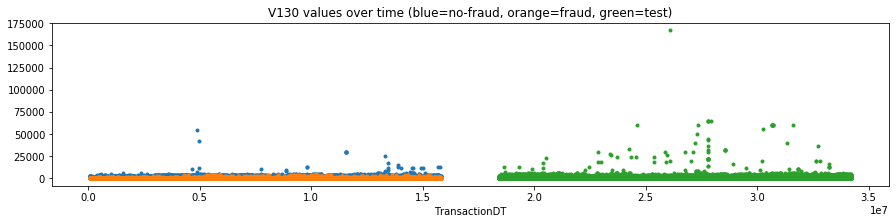

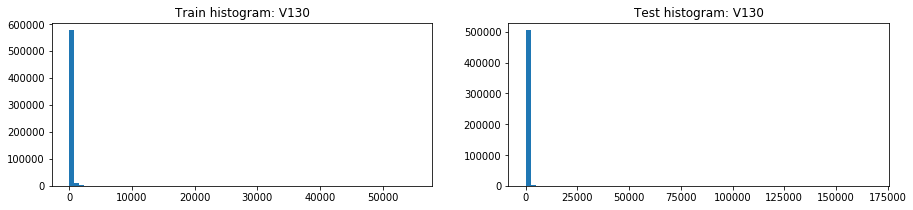

V130          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean      92.165849     97.270605        91.980813   
2             std     315.960485    328.762971       315.485415   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%      59.000000      0.000000        59.000000   
7             max   55125.000000   4350.000000     55125.000000   
8   unique values   12333.000000   1174.000000     12177.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1      107.366682     110.638006     106.548826  
2      583.515717     344.808792     629.195217  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6       65.145901      91.900002      59.000000  
7   167200.000000   23200.000000  167200.000000  
8    10195.000000    4883.000000    9006.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V130  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 403766     0.038938       15722       344117.0
1  107.949997                   5902     0.010674          63         5012.0
2   59.000000                   5410     0.025139         136         4919.0
3  117.000000                   5287     0.039531         209         4828.0
4   57.950001                   5264     0.004369          23         4666.0
5   49.000000                   2775     0.046126         128         2488.0
6  226.000000                   2197     0.045972         101         2102.0
7   47.950001                   2095     0.001432           3         1775.0
8   35.950001                   1882     0.005313          10         1715.0
9   39.000000                   1808     0.027102          49         1587.0

V130  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          403766     0.038938              15722         344117
1  117.000000            5287     0.039531                209           4828
2   59.000000            5410     0.025139                136           4919
3   49.000000            2775     0.046126                128           2488
4  226.000000            2197     0.045972                101           2102
5  107.949997            5902     0.010674                 63           5012
6  445.000000             436     0.144495                 63            387
7   97.000000             867     0.059977                 52            840
8  335.000000             999     0.051051                 51            894
9   77.000000            1266     0.040284                 51           1082

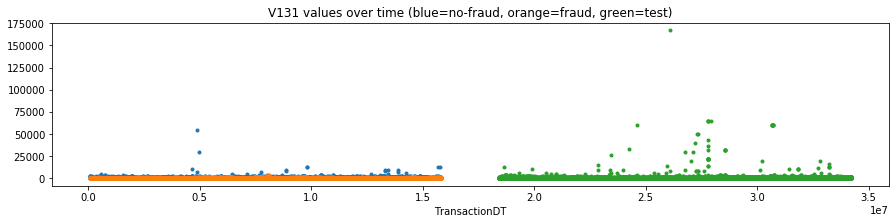

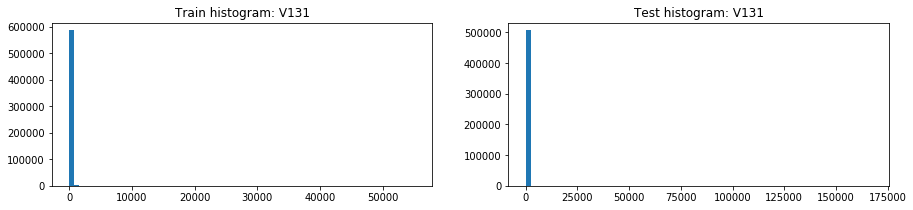

V131          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean      31.133302     52.274012        30.366999   
2             std     161.161258    188.145066       160.045517   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   3981.000000     55125.000000   
8   unique values    4445.000000    683.000000      4347.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       35.442398      34.134698      35.769238  
2      464.100478     148.744291     513.521975  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   167200.000000   12500.000000  167200.000000  
8     3492.000000    1683.000000    3099.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V131  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 496523     0.033775       16770       425891.0
1   59.000000                   5243     0.029372         154         4849.0
2  117.000000                   5162     0.042038         217         4734.0
3   57.950001                   2958     0.008114          24         2388.0
4   49.000000                   2611     0.049023         128         2527.0
5  107.949997                   2385     0.025157          60         1935.0
6  226.000000                   2024     0.044466          90         2060.0
7   39.000000                   1905     0.032021          61         1603.0
8   29.000000                   1582     0.024652          39         1333.0
9  171.000000                   1321     0.039364          52         1253.0

V131  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          496523     0.033775              16770         425891
1  117.000000            5162     0.042038                217           4734
2   59.000000            5243     0.029372                154           4849
3   49.000000            2611     0.049023                128           2527
4  226.000000            2024     0.044466                 90           2060
5   97.000000             910     0.074725                 68            839
6  445.000000             406     0.157635                 64            430
7   39.000000            1905     0.032021                 61           1603
8  107.949997            2385     0.025157                 60           1935
9   77.000000            1288     0.043478                 56           1195

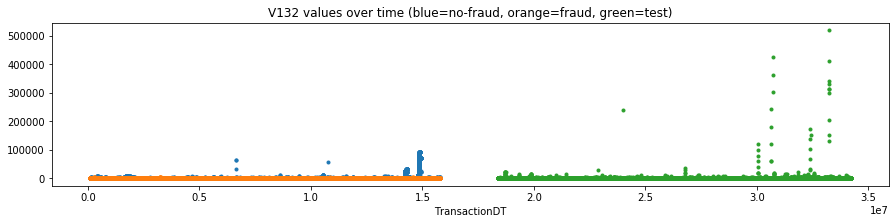

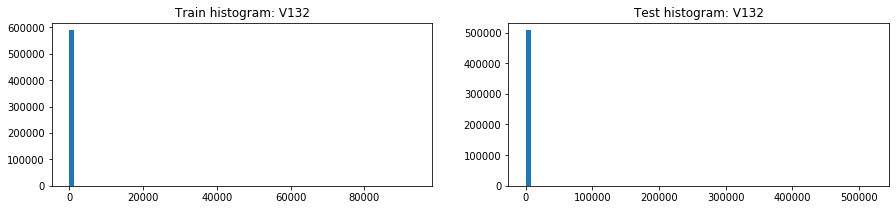

V132          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean     103.513188     52.771340       105.352467   
2             std    2266.106140    218.583926      2306.414902   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   93736.000000   6098.000000     93736.000000   
8   unique values    6561.000000   1736.000000      5645.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       30.273769      20.706949      32.665416  
2     1863.563032     285.402511    2078.627364  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   519038.500000   23280.000000  519038.500000  
8     4444.000000    1618.000000    3771.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V132  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 556214     0.029785       16567       481543.0
1  117.0                   1453     0.072953         106         1031.0
2   59.0                   1281     0.061671          79          851.0
3  100.0                    902     0.065410          59          480.0
4   49.0                    741     0.091768          68          470.0
5  226.0                    664     0.070783          47          506.0
6   50.0                    641     0.063963          41          304.0
7  200.0                    566     0.091873          52          437.0
8  150.0                    546     0.139194          76          329.0
9  171.0                    487     0.078029          38          322.0

V132  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          556214     0.029785              16567         481543
1  117.0            1453     0.072953                106           1031
2   59.0            1281     0.061671                 79            851
3  150.0             546     0.139194                 76            329
4   49.0             741     0.091768                 68            470
5  100.0             902     0.065410                 59            480
6  300.0             411     0.138686                 57            265
7  200.0             566     0.091873                 52            437
8  226.0             664     0.070783                 47            506
9  994.0              63     0.650794                 41             30

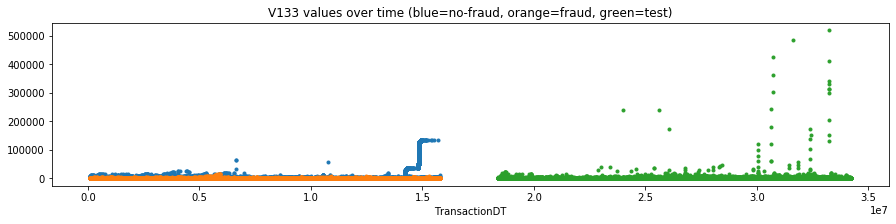

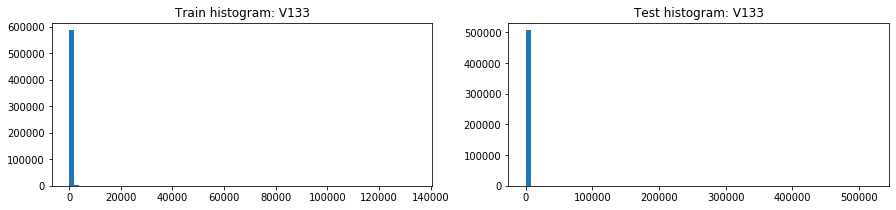

V133          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean     204.889160    141.773367       207.176966   
2             std    3796.316755    596.435191      3862.820432   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     23.422851         0.000000   
7             max  133915.000000  15607.000000    133915.000000   
8   unique values    9950.000000   2403.000000      8812.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       56.926002      45.874350      59.688796  
2     2063.254734     378.233633    2299.015396  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   519038.500000   23280.000000  519038.500000  
8     6586.000000    2622.000000    5495.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V133  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 535961     0.028319       15178       467675.0
1  117.0                   1888     0.056144         106         1326.0
2   59.0                   1642     0.054202          89         1098.0
3  100.0                    963     0.067497          65          578.0
4  226.0                    869     0.056387          49          685.0
5   49.0                    839     0.052443          44          606.0
6   50.0                    700     0.060000          42          355.0
7  171.0                    621     0.078905          49          431.0
8  200.0                    611     0.088380          54          468.0
9  150.0                    592     0.133446          79          363.0

V133  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          535961     0.028319              15178         467675
1  117.0            1888     0.056144                106           1326
2   59.0            1642     0.054202                 89           1098
3  150.0             592     0.133446                 79            363
4  100.0             963     0.067497                 65            578
5  300.0             461     0.138829                 64            297
6  335.0             524     0.112595                 59            342
7  200.0             611     0.088380                 54            468
8  171.0             621     0.078905                 49            431
9  226.0             869     0.056387                 49            685

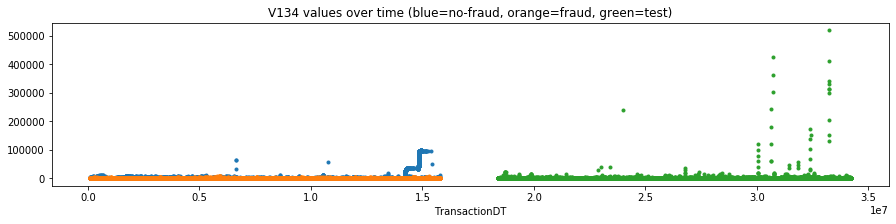

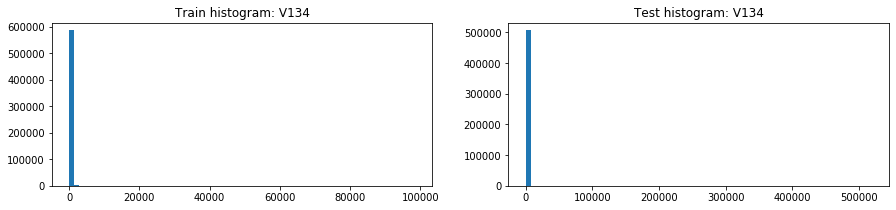

V134          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean     145.972328     94.821907       147.826416   
2             std    2772.986817    401.688406      2821.743297   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   98476.000000   8451.000000     98476.000000   
8   unique values    8179.000000   2123.000000      7128.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       39.334035      30.018903      41.662738  
2     1876.708561     312.857331    2092.378249  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   519038.500000   23280.000000  519038.500000  
8     5445.000000    2064.000000    4612.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V134  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 547743     0.028791       15770       475771.0
1  117.0                   1654     0.058646          97         1127.0
2   59.0                   1397     0.062992          88          913.0
3  100.0                    930     0.065591          61          514.0
4   49.0                    759     0.068511          52          517.0
5  226.0                    752     0.065160          49          555.0
6   50.0                    661     0.065053          43          336.0
7  200.0                    586     0.090444          53          453.0
8  150.0                    575     0.137391          79          358.0
9  171.0                    534     0.078652          42          367.0

V134  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          547743     0.028791              15770         475771
1  117.0            1654     0.058646                 97           1127
2   59.0            1397     0.062992                 88            913
3  150.0             575     0.137391                 79            358
4  300.0             461     0.134490                 62            287
5  100.0             930     0.065591                 61            514
6  200.0             586     0.090444                 53            453
7   49.0             759     0.068511                 52            517
8  226.0             752     0.065160                 49            555
9   77.0             471     0.095541                 45            349

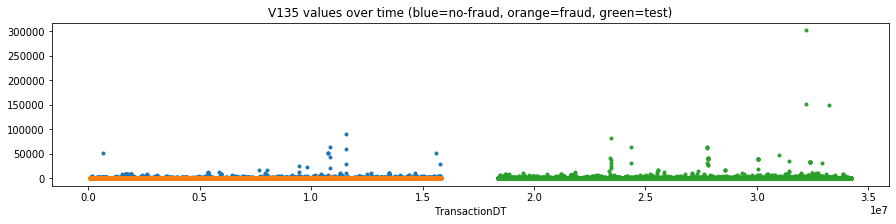

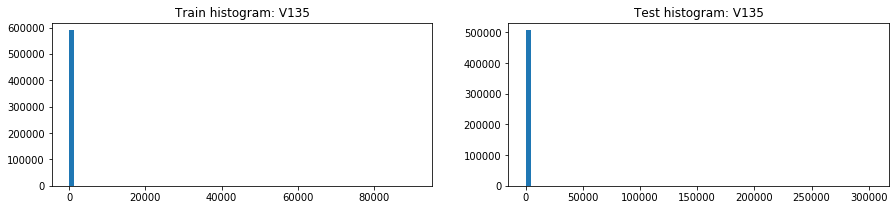

V135          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean      17.250132     16.823745        17.265588   
2             std     293.847563    116.586376       298.301160   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   90750.000000   4528.899902     90750.000000   
8   unique values    3725.000000    404.000000      3582.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       24.233004      23.211534      24.488314  
2      661.652798     224.936129     731.150560  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   302500.000000   10000.000000  302500.000000  
8     3871.000000    1389.000000    3240.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V135  Count in train (desc)  Mean target  Sum target  Count in test
0     0.000000                 563527     0.034220       19284       478742.0
1   100.000000                   1206     0.037313          45         1015.0
2  1165.000000                    870     0.000000           0            NaN
3   117.000000                    839     0.040524          34          896.0
4   200.000000                    807     0.058240          47          841.0
5    59.000000                    691     0.031838          22          907.0
6    50.000000                    616     0.064935          40          500.0
7   150.000000                    597     0.082077          49          476.0
8   107.949997                    577     0.008666           5          679.0
9    57.950001                    521     0.001919           1          653.0

V135  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          563527     0.034220              19284         478742
1  300.0             520     0.121154                 63            478
2  150.0             597     0.082077                 49            476
3  200.0             807     0.058240                 47            841
4  100.0            1206     0.037313                 45           1015
5   50.0             616     0.064935                 40            500
6  117.0             839     0.040524                 34            896
7  226.0             458     0.063319                 29            556
8   49.0             403     0.057072                 23            460
9  335.0             319     0.068966                 22            340

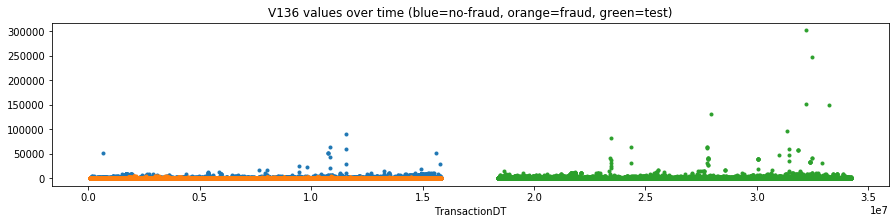

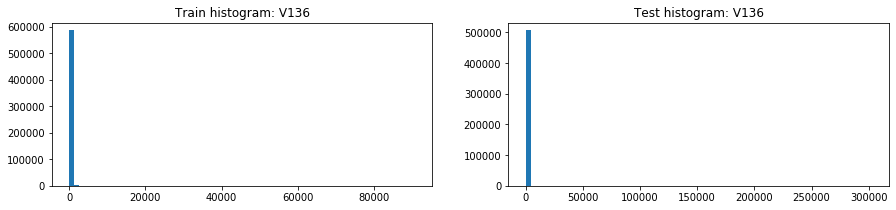

V136          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean      38.821196     38.720929        38.824830   
2             std     451.808411    221.912050       457.979479   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   90750.000000   4528.899902     90750.000000   
8   unique values    4853.000000    545.000000      4674.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       41.052809      43.113217      40.537602  
2      833.083599     340.438225     915.728936  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   302500.000000   15032.370117  302500.000000  
8     5158.000000    1953.000000    4238.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V136  Count in train (desc)  Mean target  Sum target  Count in test
0     0.000000                 547750     0.033855       18544       460547.0
1   100.000000                   1343     0.048399          65         1083.0
2   117.000000                   1311     0.050343          66         1491.0
3    59.000000                   1197     0.038429          46         1620.0
4   107.949997                    968     0.012397          12         1185.0
5    57.950001                    925     0.002162           2         1227.0
6  7709.000000                    871     0.000000           0            NaN
7   200.000000                    866     0.053118          46          879.0
8   226.000000                    750     0.046667          35          840.0
9    50.000000                    745     0.053691          40          578.0

V136  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          547750     0.033855              18544         460547
1  300.0             565     0.122124                 69            504
2  117.0            1311     0.050343                 66           1491
3  100.0            1343     0.048399                 65           1083
4  150.0             642     0.080997                 52            499
5   59.0            1197     0.038429                 46           1620
6  200.0             866     0.053118                 46            879
7   50.0             745     0.053691                 40            578
8  226.0             750     0.046667                 35            840
9   49.0             680     0.051471                 35            784

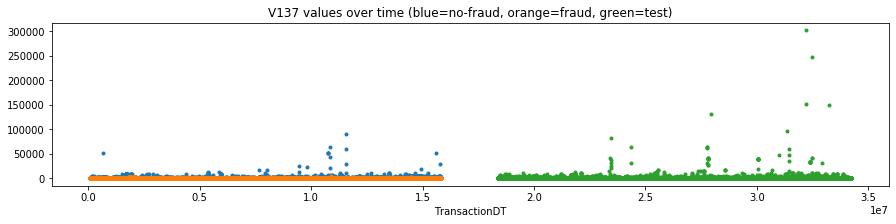

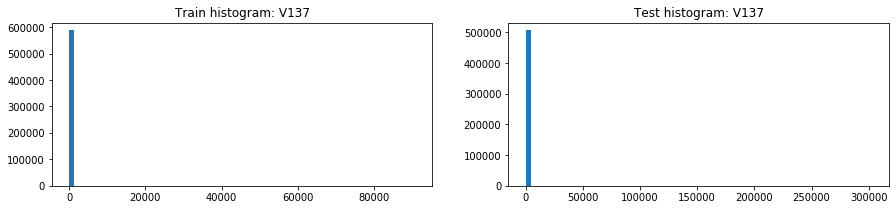

V137          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean      26.365090     26.155054        26.372703   
2             std     348.332714    160.145334       353.276445   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   90750.000000   4528.899902     90750.000000   
8   unique values    4253.000000    481.000000      4090.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1       31.126621      29.537549      31.523815  
2      804.012468     247.921189     890.324685  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   302500.000000   10000.000000  302500.000000  
8     4429.000000    1607.000000    3683.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V137  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 558074     0.033908       18923       472971.0
1  100.000000                   1275     0.037647          48         1045.0
2  117.000000                   1050     0.052381          55         1112.0
3   59.000000                    896     0.035714          32         1128.0
4  200.000000                    818     0.056235          46          858.0
5  107.949997                    677     0.008863           6          776.0
6   50.000000                    661     0.065053          43          534.0
7  150.000000                    628     0.078025          49          491.0
8   57.950001                    607     0.004942           3          779.0
9  226.000000                    601     0.053245          32          652.0

V137  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          558074     0.033908              18923         472971
1  300.0             541     0.121996                 66            494
2  117.0            1050     0.052381                 55           1112
3  150.0             628     0.078025                 49            491
4  100.0            1275     0.037647                 48           1045
5  200.0             818     0.056235                 46            858
6   50.0             661     0.065053                 43            534
7   59.0             896     0.035714                 32           1128
8  226.0             601     0.053245                 32            652
9  335.0             401     0.069825                 28            402

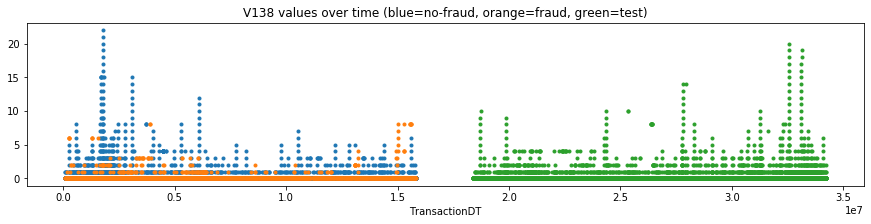

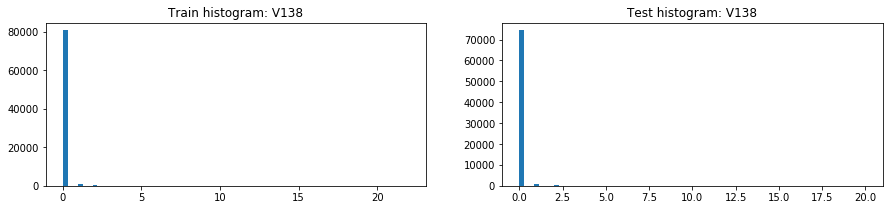

V138          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.036439      0.121096         0.032492   
2             std       0.428490      0.659371         0.414186   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      22.000000      8.000000        22.000000   
8   unique values      24.000000     10.000000        24.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.038279      0.053060       0.036328  
2        0.421249      0.389689       0.425206  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       20.000000     10.000000      20.000000  
8       22.000000     12.000000      22.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V138  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    0.0                  80610     0.042712        3443        74360.0
2    1.0                    811     0.139334         113          909.0
3    2.0                    195     0.215385          42          247.0
4    3.0                    117     0.213675          25           84.0
5    4.0                     75     0.080000           6           76.0
6    5.0                     31     0.032258           1           23.0
7    6.0                     28     0.321429           9           17.0
8    8.0                     23     0.434783          10           18.0
9    7.0                     16     0.062500           1           12.0

V138  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           80610     0.042712               3443          74360
2    1.0             811     0.139334                113            909
3    2.0             195     0.215385                 42            247
4    3.0             117     0.213675                 25             84
5    8.0              23     0.434783                 10             18
6    6.0              28     0.321429                  9             17
7    4.0              75     0.080000                  6             76
8    5.0              31     0.032258                  1             23
9    7.0              16     0.062500                  1             12

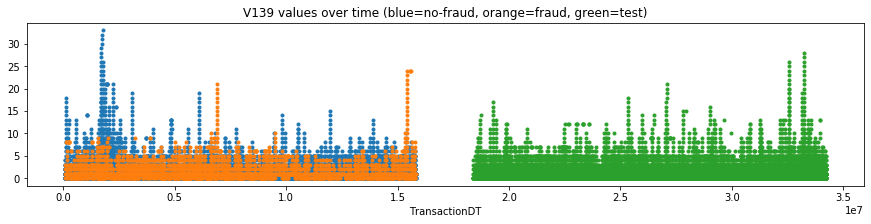

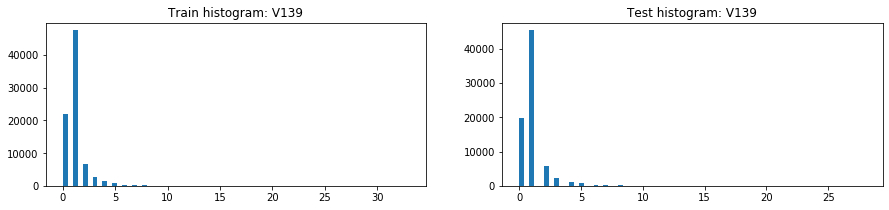

V139          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       1.073915      1.985753         1.031407   
2             std       1.333924      2.231422         1.260822   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      33.000000     24.000000        33.000000   
8   unique values      35.000000     26.000000        35.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        1.043254      1.165403       1.027126  
2        1.244900      1.306510       1.235644  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       28.000000     17.000000      28.000000  
8       30.000000     19.000000      30.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V139  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  47430     0.028062        1331        45305.0
2    0.0                  21848     0.030026         656        19844.0
3    2.0                   6522     0.103036         672         5649.0
4    3.0                   2793     0.144289         403         2276.0
5    4.0                   1455     0.169759         247         1113.0
6    5.0                    868     0.162442         141          692.0
7    6.0                    392     0.227041          89          299.0
8    7.0                    196     0.214286          42          192.0
9    8.0                    113     0.212389          24          103.0

V139  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           47430     0.028062               1331          45305
2    2.0            6522     0.103036                672           5649
3    0.0           21848     0.030026                656          19844
4    3.0            2793     0.144289                403           2276
5    4.0            1455     0.169759                247           1113
6    5.0             868     0.162442                141            692
7    6.0             392     0.227041                 89            299
8    7.0             196     0.214286                 42            192
9    8.0             113     0.212389                 24            103

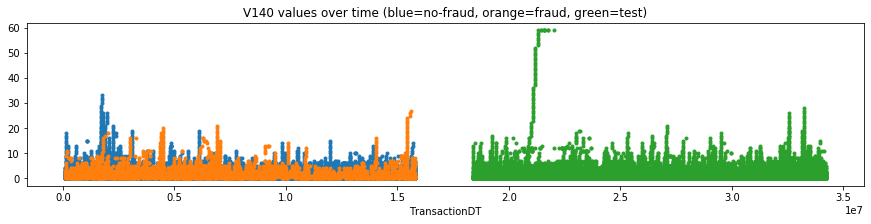

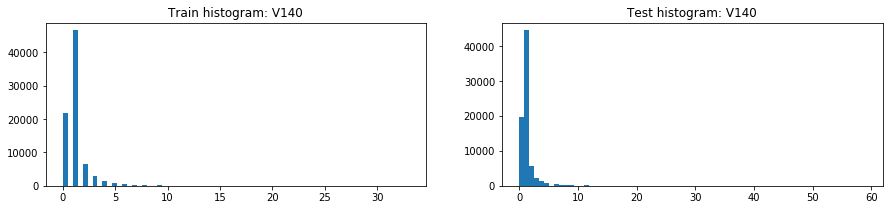

V140          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       1.125267      2.464110         1.062852   
2             std       1.467850      2.947508         1.327652   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      33.000000     27.000000        33.000000   
8   unique values      35.000000     29.000000        35.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        1.126305      1.514425       1.075060  
2        1.795401      3.603572       1.382821  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       59.000000     59.000000      59.000000  
8       61.000000     61.000000      31.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V140  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013         430906
1    1.0                  46598     0.024937        1162          44496
2    0.0                  21825     0.029828         651          19817
3    2.0                   6650     0.094436         628           5772
4    3.0                   2920     0.135274         395           2308
5    4.0                   1580     0.168354         266           1271
6    5.0                    898     0.201559         181            770
7    6.0                    561     0.197861         111            392
8    7.0                    267     0.202247          54            259
9    8.0                    167     0.299401          50            157

V140  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           46598     0.024937               1162          44496
2    0.0           21825     0.029828                651          19817
3    2.0            6650     0.094436                628           5772
4    3.0            2920     0.135274                395           2308
5    4.0            1580     0.168354                266           1271
6    5.0             898     0.201559                181            770
7    6.0             561     0.197861                111            392
8    7.0             267     0.202247                 54            259
9    8.0             167     0.299401                 50            157

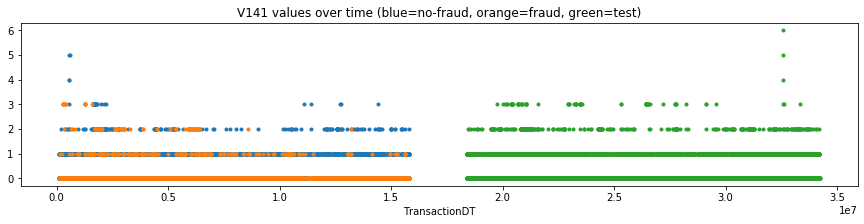

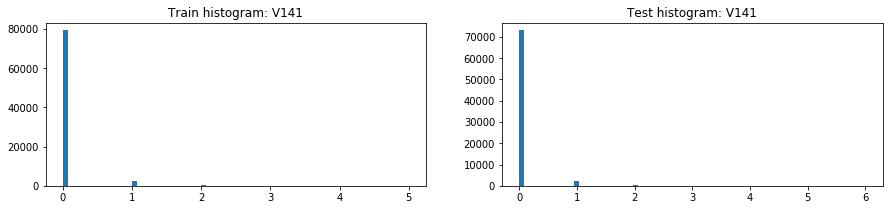

V141          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.037696      0.123014         0.033719   
2             std       0.215133      0.403386         0.201249   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max       5.000000      3.000000         5.000000   
8   unique values       7.000000      5.000000         7.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.043676      0.081570       0.038673  
2        0.239126      0.348953       0.220093  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        6.000000      3.000000       6.000000  
8        8.000000      5.000000       8.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V141  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013         430906
1    0.0                  79211     0.041535        3290          72971
2    1.0                   2426     0.116241         282           2396
3    2.0                    267     0.250936          67            346
4    3.0                     37     0.297297          11             69
5    4.0                      2     0.000000           0              1
6    5.0                      2     0.000000           0              1

V141  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           79211     0.041535               3290          72971
2    1.0            2426     0.116241                282           2396
3    2.0             267     0.250936                 67            346
4    3.0              37     0.297297                 11             69
5    4.0               2     0.000000                  0              1
6    5.0               2     0.000000                  0              1

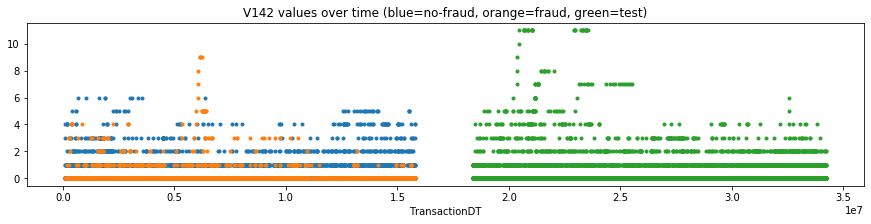

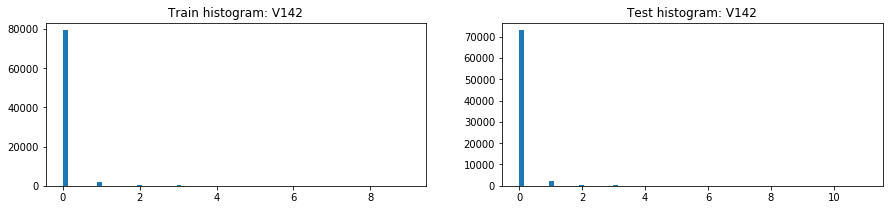

V142          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.048581      0.165479         0.043132   
2             std       0.313888      0.655113         0.287141   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max       9.000000      9.000000         6.000000   
8   unique values      11.000000     11.000000         8.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.062862      0.148999       0.051489  
2        0.432052      0.811546       0.351081  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       11.000000     11.000000      11.000000  
8       13.000000     13.000000      11.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V142  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013         430906
1    0.0                  79152     0.041477        3283          72901
2    1.0                   2161     0.122166         264           2047
3    2.0                    323     0.117647          38            447
4    3.0                    154     0.240260          37            164
5    4.0                     95     0.094737           9             96
6    5.0                     43     0.279070          12             45
7    6.0                     11     0.090909           1             12
8    9.0                      4     1.000000           4              1
9    7.0                      1     1.000000           1             30

V142  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           79152     0.041477               3283          72901
2    1.0            2161     0.122166                264           2047
3    2.0             323     0.117647                 38            447
4    3.0             154     0.240260                 37            164
5    5.0              43     0.279070                 12             45
6    4.0              95     0.094737                  9             96
7    9.0               4     1.000000                  4              1
8    6.0              11     0.090909                  1             12
9    7.0               1     1.000000                  1             30

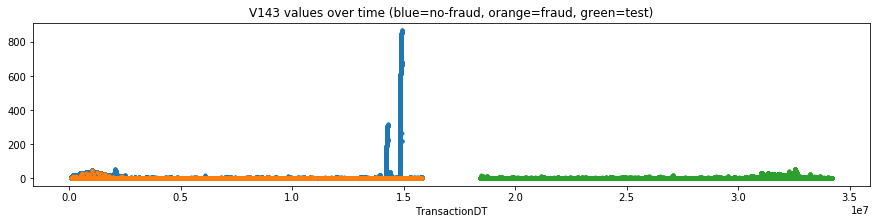

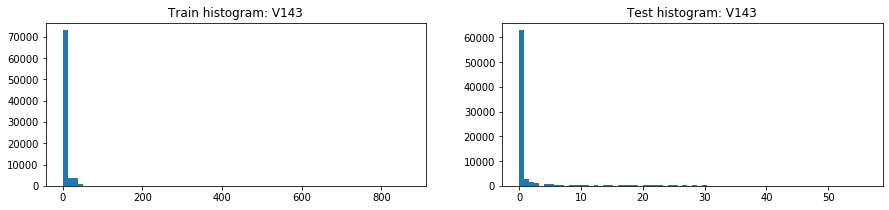

V143          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean       8.397006      0.778417         8.752248   
2             std      55.267545      2.640451        56.513468   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     869.000000     47.000000       869.000000   
8   unique values     871.000000     32.000000       871.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1        1.779607      0.372377       1.966414  
2        5.758042      1.294889       6.085725  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       56.000000     17.000000      56.000000  
8       58.000000     19.000000      58.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V143  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    0.0                  63872     0.038734        2474        62799.0
2    1.0                   3767     0.183435         691         2835.0
3    2.0                   1884     0.135881         256         1678.0
4    3.0                   1032     0.102713         106          938.0
5    4.0                    709     0.066291          47          680.0
6   28.0                    584     0.001712           1          138.0
7   13.0                    516     0.003876           2           99.0
8   30.0                    417     0.000000           0          134.0
9   24.0                    409     0.009780           4          325.0

V143  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           63872     0.038734               2474          62799
2    1.0            3767     0.183435                691           2835
3    2.0            1884     0.135881                256           1678
4    3.0            1032     0.102713                106            938
5    4.0             709     0.066291                 47            680
6    5.0             380     0.034211                 13            537
7    6.0             264     0.034091                  9            314
8   20.0             327     0.021407                  7            187
9    7.0             213     0.032864                  7            364

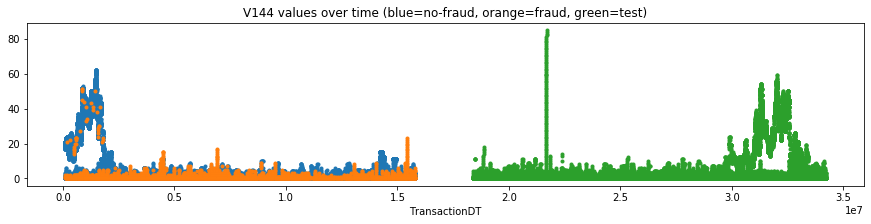

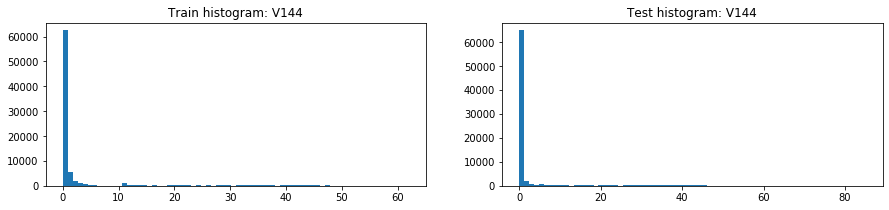

V144          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean       3.708484      1.184881         3.826156   
2             std      10.485633      3.701618        10.682965   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      62.000000     51.000000        62.000000   
8   unique values      64.000000     41.000000        64.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1        2.809572      0.808145       3.075258  
2        8.928725      4.980549       9.295715  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       85.000000     85.000000      59.000000  
8       87.000000     87.000000      61.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V144  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012         430636
1    0.0                  62439     0.036804        2298          59661
2    1.0                   5418     0.116833         633           5189
3    2.0                   2073     0.149059         309           1937
4   11.0                   1089     0.006428           7            245
5    3.0                   1054     0.148008         156            881
6    4.0                    600     0.115000          69            476
7   15.0                    435     0.013793           6            176
8    5.0                    365     0.139726          51            376
9   40.0                    364     0.000000           0            102

V144  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           62439     0.036804               2298          59661
2    1.0            5418     0.116833                633           5189
3    2.0            2073     0.149059                309           1937
4    3.0            1054     0.148008                156            881
5    4.0             600     0.115000                 69            476
6    5.0             365     0.139726                 51            376
7    6.0             246     0.105691                 26            303
8    7.0             107     0.158879                 17            331
9    9.0              70     0.128571                  9            148

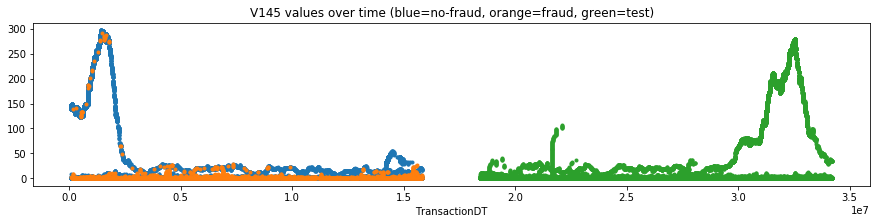

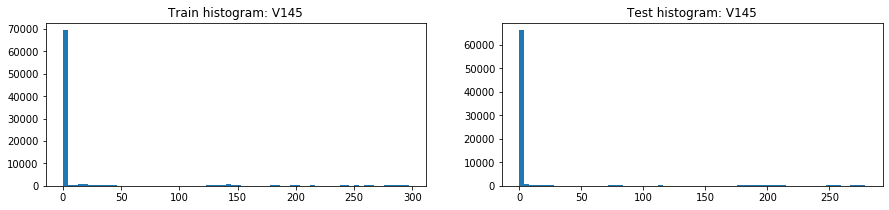

V145          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean      22.112946      3.641194        22.974253   
2             std      64.371860     22.013184        65.556946   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      1.500000         0.000000   
7             max     297.000000    292.000000       297.000000   
8   unique values     261.000000     62.000000       261.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1       17.100598      1.719399      19.142429  
2       54.471618      6.628048      57.616335  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      279.000000     85.000000     279.000000  
8      281.000000     87.000000     281.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V145  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    0.0                  61241     0.034405        2107        58604.0
2    1.0                   4958     0.127269         631         5071.0
3    2.0                   1847     0.177585         328         1672.0
4    3.0                    832     0.213942         178          692.0
5   35.0                    429     0.000000           0           23.0
6    4.0                    367     0.228883          84          297.0
7  142.0                    244     0.004098           1           14.0
8  143.0                    241     0.000000           0           21.0
9   39.0                    231     0.000000           0            3.0

V145  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           61241     0.034405               2107          58604
2    1.0            4958     0.127269                631           5071
3    2.0            1847     0.177585                328           1672
4    3.0             832     0.213942                178            692
5    4.0             367     0.228883                 84            297
6    5.0             212     0.259434                 55            205
7    6.0             105     0.323810                 34            106
8    7.0              79     0.341772                 27            105
9    8.0              90     0.244444                 22            104

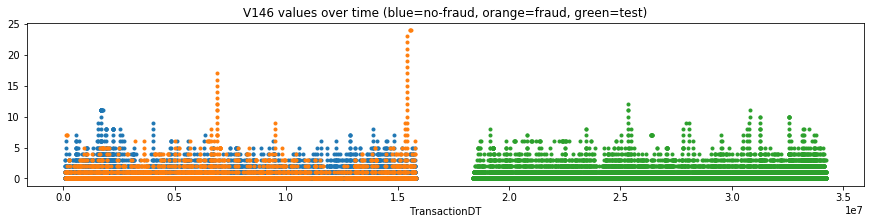

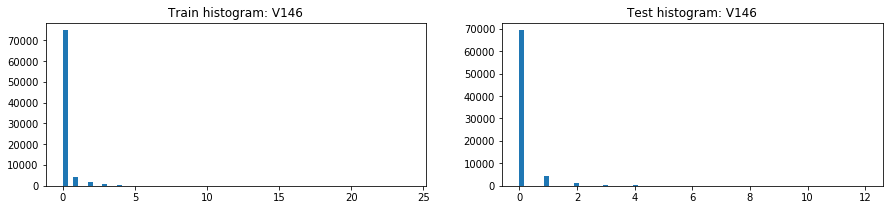

V146          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.156276      0.783836         0.127020   
2             std       0.682328      1.848351         0.555728   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      24.000000     24.000000        11.000000   
8   unique values      26.000000     26.000000        13.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.141611      0.177622       0.136857  
2        0.578137      0.668796       0.564915  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       12.000000      8.000000      12.000000  
8       14.000000     10.000000      14.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V146  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    0.0                  74718     0.032201        2406        69222.0
2    1.0                   4390     0.138497         608         4301.0
3    2.0                   1605     0.191900         308         1301.0
4    3.0                    665     0.225564         150          513.0
5    4.0                    263     0.258555          68          217.0
6    5.0                    143     0.342657          49          103.0
7    6.0                     56     0.267857          15           61.0
8   11.0                     25     0.120000           3            3.0
9    7.0                     25     0.400000          10           32.0

V146  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           74718     0.032201               2406          69222
2    1.0            4390     0.138497                608           4301
3    2.0            1605     0.191900                308           1301
4    3.0             665     0.225564                150            513
5    4.0             263     0.258555                 68            217
6    5.0             143     0.342657                 49            103
7    6.0              56     0.267857                 15             61
8    7.0              25     0.400000                 10             32
9    8.0              23     0.217391                  5             16

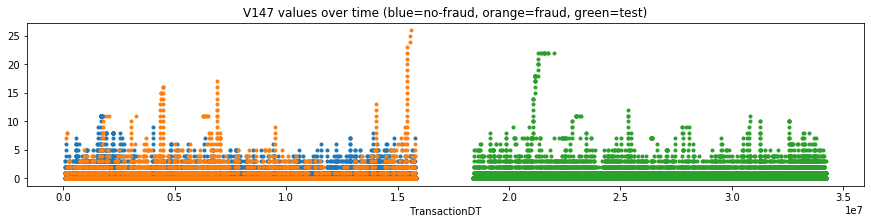

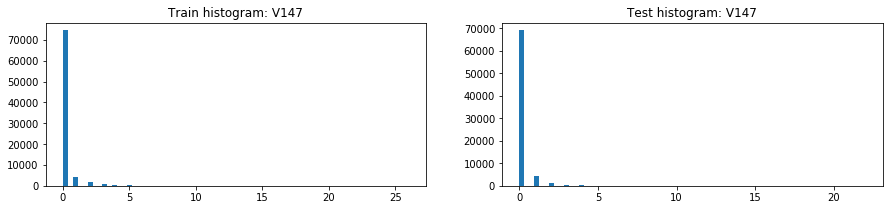

V147          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.168601      1.012877         0.129242   
2             std       0.750497      2.273225         0.560253   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      26.000000     26.000000        11.000000   
8   unique values      28.000000     28.000000        13.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.162987      0.292001       0.145953  
2        0.758748      1.433971       0.614619  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       22.000000     22.000000      22.000000  
8       24.000000     24.000000      15.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V147  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    0.0                  74531     0.031101        2318        69016.0
2    1.0                   4396     0.126706         557         4267.0
3    2.0                   1656     0.203502         337         1332.0
4    3.0                    693     0.236652         164          568.0
5    4.0                    286     0.307692          88          250.0
6    5.0                    150     0.373333          56          127.0
7    6.0                     66     0.348485          23           56.0
8    7.0                     38     0.578947          22           72.0
9   11.0                     38     0.421053          16           11.0

V147  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           74531     0.031101               2318          69016
2    1.0            4396     0.126706                557           4267
3    2.0            1656     0.203502                337           1332
4    3.0             693     0.236652                164            568
5    4.0             286     0.307692                 88            250
6    5.0             150     0.373333                 56            127
7    6.0              66     0.348485                 23             56
8    7.0              38     0.578947                 22             72
9   11.0              38     0.421053                 16             11

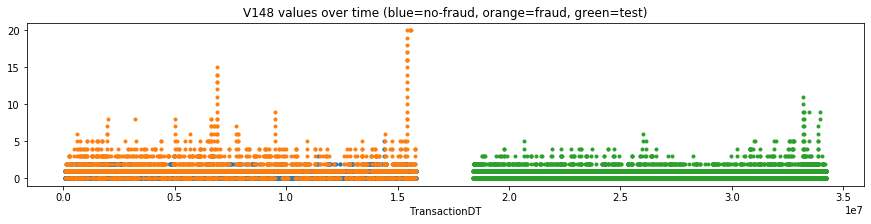

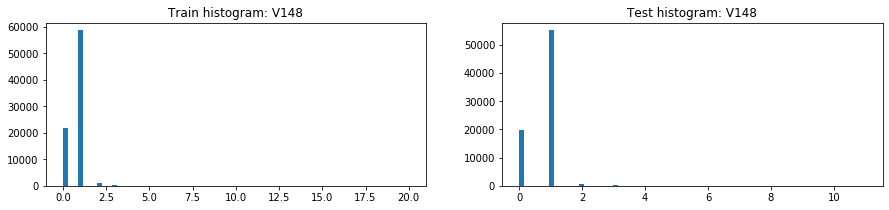

V148          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.765001      1.381370         0.736267   
2             std       0.581425      1.647401         0.456938   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      20.000000     20.000000         5.000000   
8   unique values      22.000000     22.000000         7.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.754331      0.778595       0.751128  
2        0.485813      0.477096       0.486866  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000      5.000000      11.000000  
8       13.000000      7.000000      13.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V148  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  58650     0.035226        2066        55062.0
2    0.0                  21848     0.030026         656        19844.0
3    2.0                    962     0.481289         463          691.0
4    3.0                    267     0.936330         250          111.0
5    4.0                    108     0.981481         106           41.0
6    5.0                     45     0.977778          44           20.0
7    6.0                     16     1.000000          16            4.0
8    7.0                     11     1.000000          11            3.0
9    8.0                     10     1.000000          10            3.0

V148  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           58650     0.035226               2066          55062
2    0.0           21848     0.030026                656          19844
3    2.0             962     0.481289                463            691
4    3.0             267     0.936330                250            111
5    4.0             108     0.981481                106             41
6    5.0              45     0.977778                 44             20
7    6.0              16     1.000000                 16              4
8    7.0              11     1.000000                 11              3
9    8.0              10     1.000000                 10              3

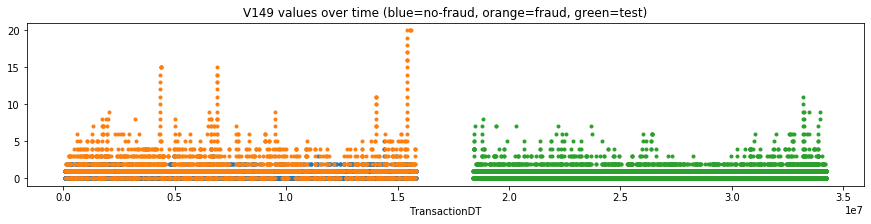

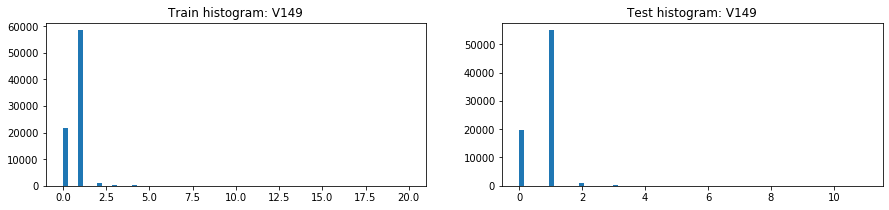

V149          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.775313      1.570411         0.738246   
2             std       0.628191      1.913475         0.459925   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      20.000000     20.000000         5.000000   
8   unique values      22.000000     22.000000         7.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.760718      0.792171       0.756565  
2        0.507191      0.539587       0.502615  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000      8.000000      11.000000  
8       13.000000     10.000000      13.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V149  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  58370     0.032517        1898        54854.0
2    0.0                  21825     0.029828         651        19817.0
3    2.0                   1115     0.442152         493          837.0
4    3.0                    298     0.919463         274          138.0
5    4.0                    156     0.987179         154           68.0
6    5.0                     60     0.983333          59           28.0
7    6.0                     38     1.000000          38           23.0
8    7.0                     21     1.000000          21           10.0
9    8.0                     16     1.000000          16            4.0

V149  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           58370     0.032517               1898          54854
2    0.0           21825     0.029828                651          19817
3    2.0            1115     0.442152                493            837
4    3.0             298     0.919463                274            138
5    4.0             156     0.987179                154             68
6    5.0              60     0.983333                 59             28
7    6.0              38     1.000000                 38             23
8    7.0              21     1.000000                 21             10
9    8.0              16     1.000000                 16              4

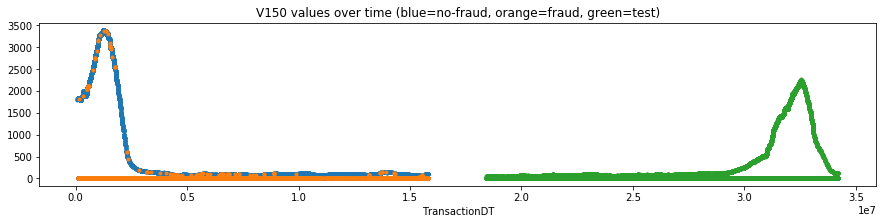

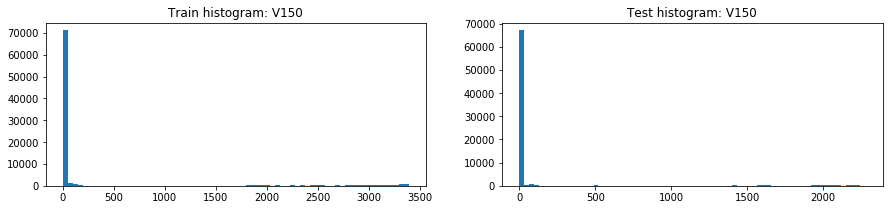

V150          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean     277.598028     31.862230       289.056284   
2             std     829.576922    271.047102       844.935531   
3             min       1.000000      1.000000         1.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max    3389.000000   3372.000000      3389.000000   
8   unique values    1997.000000    101.000000      1978.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1      135.081573      4.254348     152.448691  
2      449.117847     14.122804     475.271816  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7     2277.000000     93.000000    2277.000000  
8     2152.000000     53.000000    2142.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V150  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    1.0                  67559     0.031646        2138        63957.0
2    2.0                   2663     0.257980         687         2497.0
3    3.0                    462     0.649351         300          371.0
4    4.0                    207     0.884058         183          116.0
5    5.0                     98     0.867347          85           42.0
6   97.0                     96     0.000000           0           18.0
7   98.0                     83     0.024096           2           18.0
8  100.0                     77     0.064935           5           24.0
9   84.0                     74     0.027027           2           43.0

V150  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    1.0           67559     0.031646               2138          63957
2    2.0            2663     0.257980                687           2497
3    3.0             462     0.649351                300            371
4    4.0             207     0.884058                183            116
5    5.0              98     0.867347                 85             42
6    6.0              45     0.888889                 40             26
7    7.0              30     0.966667                 29             11
8    8.0              18     0.944444                 17              7
9    9.0              10     1.000000                 10              5

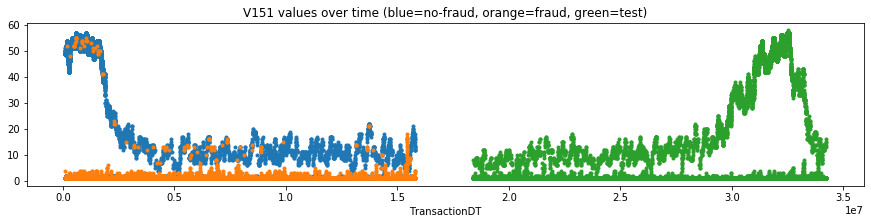

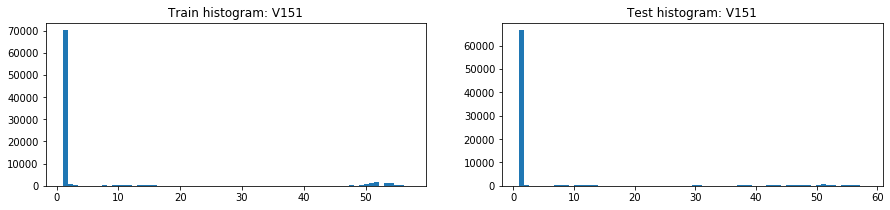

V151          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean       6.460190      2.166530         6.660396   
2             std      15.232324      5.474493        15.509543   
3             min       1.000000      1.000000         1.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      57.000000     55.000000        57.000000   
8   unique values      57.000000     31.000000        57.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1        5.442404      1.401436       5.978836  
2       13.267347      1.796967      14.018040  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       58.000000     17.000000      58.000000  
8       59.000000     18.000000      59.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V151  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012         430636
1    1.0                  70098     0.039359        2759          66454
2   52.0                   1770     0.004520           8            524
3   53.0                   1483     0.002023           3            359
4   51.0                   1087     0.002760           3            608
5   54.0                   1067     0.005623           6            340
6    2.0                    747     0.655957         490            430
7   50.0                    621     0.009662           6            345
8   55.0                    491     0.012220           6            352
9   49.0                    401     0.004988           2            539

V151  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    1.0           70098     0.039359               2759          66454
2    2.0             747     0.655957                490            430
3    3.0             175     0.960000                168            104
4    4.0              70     0.785714                 55             47
5    5.0              60     0.466667                 28             44
6   13.0             257     0.089494                 23            146
7    6.0              75     0.200000                 15             99
8   12.0             219     0.063927                 14            175
9   16.0             148     0.074324                 11             84

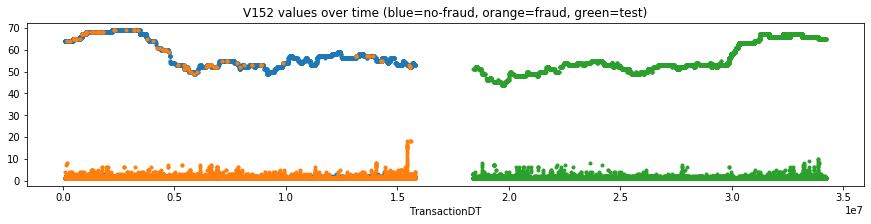

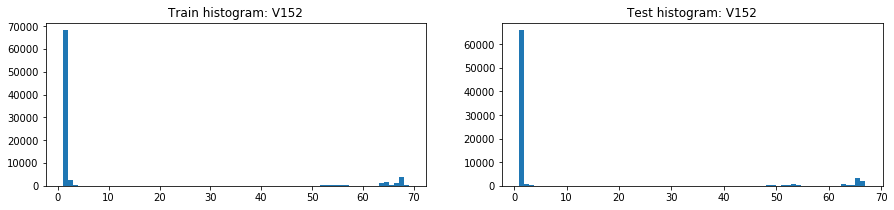

V152          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean       9.432710      3.528075         9.708033   
2             std      21.554486     10.510815        21.895387   
3             min       1.000000      1.000000         1.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      69.000000     69.000000        69.000000   
8   unique values      40.000000     35.000000        26.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1        8.333219      3.376753       8.991183  
2       20.027458     10.229859      20.898809  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       67.000000     52.000000      67.000000  
8       35.000000     18.000000      30.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V152  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    1.0                  68064     0.035951        2447        65866.0
2   68.0                   4003     0.004247          17            NaN
3    2.0                   2571     0.235706         606          856.0
4   65.0                   1554     0.009009          14          351.0
5   64.0                   1247     0.002406           3          381.0
6   67.0                   1239     0.004843           6         2227.0
7   66.0                    428     0.000000           0         3162.0
8   53.0                    397     0.052897          21          647.0
9   69.0                    380     0.023684           9            NaN

V152  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012       430636.0
1    1.0           68064     0.035951               2447        65866.0
2    2.0            2571     0.235706                606          856.0
3    3.0             272     0.926471                252          142.0
4    4.0              99     0.989899                 98           71.0
5    5.0              59     1.000000                 59           47.0
6    6.0              31     1.000000                 31           27.0
7   53.0             397     0.052897                 21          647.0
8   68.0            4003     0.004247                 17            NaN
9   65.0            1554     0.009009                 14          351.0

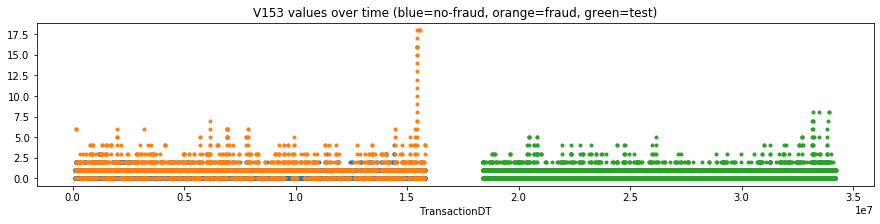

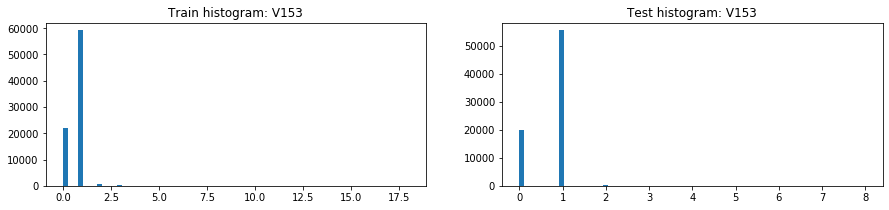

V153          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.753200      1.204932         0.732141   
2             std       0.532649      1.350650         0.449403   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      18.000000     18.000000         4.000000   
8   unique values      20.000000     20.000000         6.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.748737      0.776219       0.745108  
2        0.470179      0.482244       0.468446  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        8.000000      5.000000       8.000000  
8       10.000000      7.000000      10.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V153  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  59143     0.038077        2252        55391.0
2    0.0                  21848     0.030026         656        19844.0
3    2.0                    667     0.692654         462          405.0
4    3.0                    167     0.964072         161           86.0
5    4.0                     60     0.983333          59           34.0
6    5.0                     22     1.000000          22           14.0
7    6.0                     16     1.000000          16            3.0
8   16.0                      5     1.000000           5            NaN
9   18.0                      4     1.000000           4            NaN

V153  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013       430906.0
1    1.0           59143     0.038077               2252        55391.0
2    0.0           21848     0.030026                656        19844.0
3    2.0             667     0.692654                462          405.0
4    3.0             167     0.964072                161           86.0
5    4.0              60     0.983333                 59           34.0
6    5.0              22     1.000000                 22           14.0
7    6.0              16     1.000000                 16            3.0
8   16.0               5     1.000000                  5            NaN
9   18.0               4     1.000000                  4            NaN

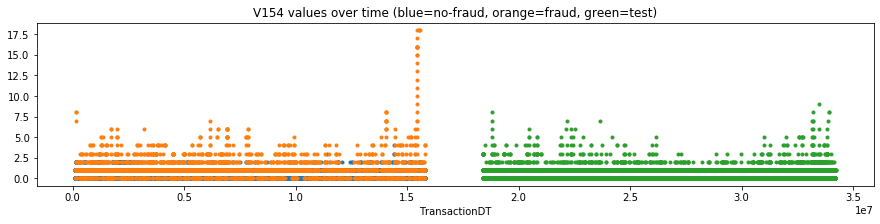

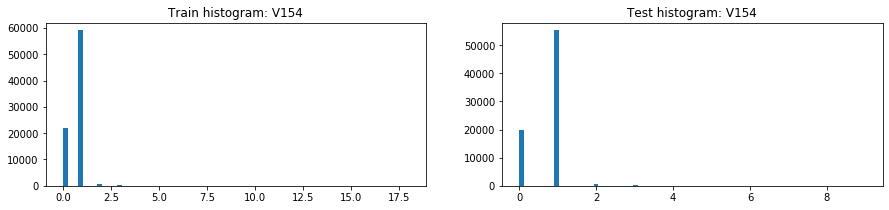

V154          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.757423      1.281644         0.732984   
2             std       0.546907      1.441513         0.450330   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      18.000000     18.000000         4.000000   
8   unique values      20.000000     20.000000         6.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.753144      0.785609       0.748857  
2        0.484449      0.518795       0.479570  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        9.000000      8.000000       9.000000  
8       11.000000     10.000000      11.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V154  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  59033     0.036793        2172        55270.0
2    0.0                  21825     0.029828         651        19817.0
3    2.0                    712     0.644663         459          467.0
4    3.0                    208     0.971154         202          135.0
5    4.0                     81     0.987654          80           51.0
6    5.0                     34     1.000000          34           24.0
7    6.0                     20     1.000000          20            9.0
8    7.0                      8     1.000000           8            7.0
9    8.0                      6     1.000000           6            4.0

V154  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           59033     0.036793               2172          55270
2    0.0           21825     0.029828                651          19817
3    2.0             712     0.644663                459            467
4    3.0             208     0.971154                202            135
5    4.0              81     0.987654                 80             51
6    5.0              34     1.000000                 34             24
7    6.0              20     1.000000                 20              9
8    7.0               8     1.000000                  8              7
9    8.0               6     1.000000                  6              4

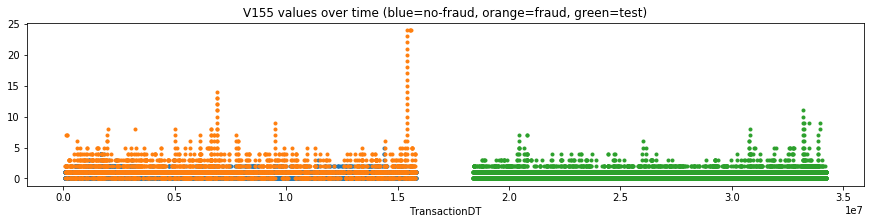

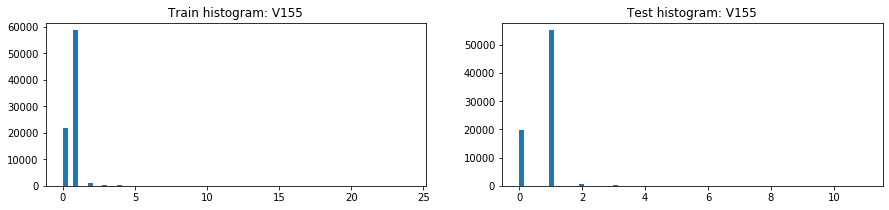

V155          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.767381      1.421096         0.736905   
2             std       0.602678      1.786783         0.458811   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      24.000000     24.000000         5.000000   
8   unique values      26.000000     26.000000         7.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.756284      0.785044       0.752487  
2        0.493419      0.509647       0.491115  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000      7.000000      11.000000  
8       13.000000      9.000000      13.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V155  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  58584     0.034668        2031        54992.0
2    0.0                  21848     0.030026         656        19844.0
3    2.0                    991     0.474268         470          729.0
4    3.0                    272     0.941176         256          124.0
5    4.0                    129     0.906977         117           47.0
6    5.0                     50     0.980000          49           25.0
7    6.0                     18     1.000000          18            7.0
8    7.0                     15     1.000000          15            7.0
9    8.0                      9     1.000000           9            4.0

V155  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           58584     0.034668               2031          54992
2    0.0           21848     0.030026                656          19844
3    2.0             991     0.474268                470            729
4    3.0             272     0.941176                256            124
5    4.0             129     0.906977                117             47
6    5.0              50     0.980000                 49             25
7    6.0              18     1.000000                 18              7
8    7.0              15     1.000000                 15              7
9    8.0               9     1.000000                  9              4

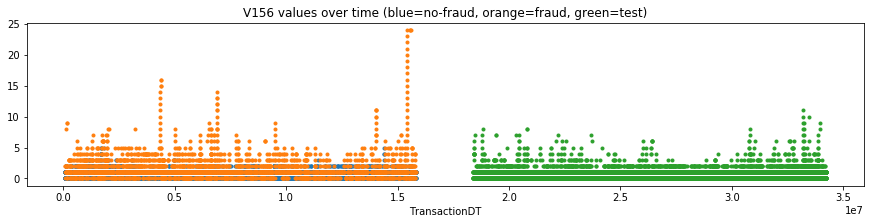

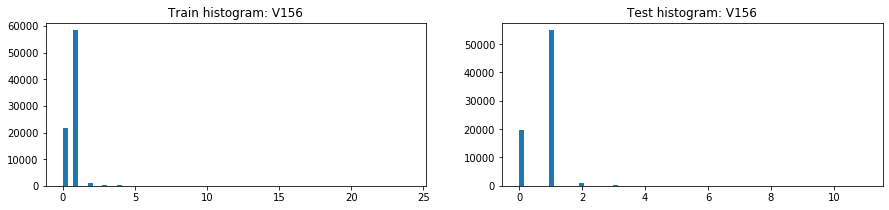

V156          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.777485      1.604658         0.738923   
2             std       0.647209      2.027660         0.461958   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      24.000000     24.000000         5.000000   
8   unique values      26.000000     26.000000         7.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.763014      0.799412       0.758208  
2        0.515818      0.574143       0.507427  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000      8.000000      11.000000  
8       13.000000     10.000000      13.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V156  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  58302     0.032006        1866        54773.0
2    0.0                  21825     0.029828         651        19817.0
3    2.0                   1153     0.432784         499          876.0
4    3.0                    302     0.940397         284          160.0
5    4.0                    169     0.946746         160           73.0
6    5.0                     76     0.947368          72           36.0
7    6.0                     34     1.000000          34           25.0
8    7.0                     21     1.000000          21           12.0
9    8.0                     15     1.000000          15            7.0

V156  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           58302     0.032006               1866          54773
2    0.0           21825     0.029828                651          19817
3    2.0            1153     0.432784                499            876
4    3.0             302     0.940397                284            160
5    4.0             169     0.946746                160             73
6    5.0              76     0.947368                 72             36
7    6.0              34     1.000000                 34             25
8    7.0              21     1.000000                 21             12
9    8.0              15     1.000000                 15              7

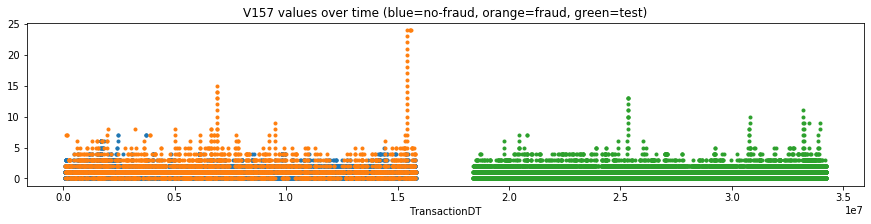

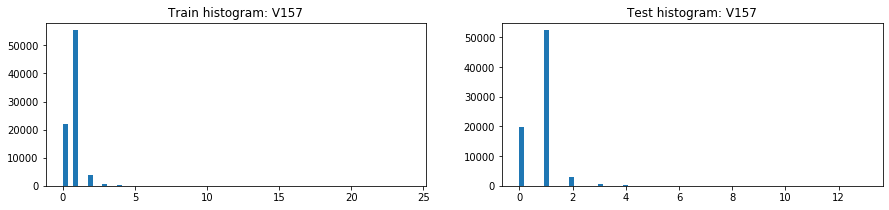

V157          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.817573      1.559452         0.782987   
2             std       0.682016      1.860259         0.546527   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      24.000000     24.000000         7.000000   
8   unique values      26.000000     26.000000         9.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.801240      0.840027       0.796119  
2        0.587565      0.601518       0.585510  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       13.000000      7.000000      13.000000  
8       15.000000      9.000000      15.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V157  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  55280     0.031983        1768        52320.0
2    0.0                  21848     0.030026         656        19844.0
3    2.0                   3745     0.162083         607         2935.0
4    3.0                    664     0.483434         321          438.0
5    4.0                    229     0.633188         145          165.0
6    5.0                     80     0.875000          70           41.0
7    6.0                     37     0.702703          26            9.0
8    7.0                     24     0.791667          19            9.0
9    8.0                      9     1.000000           9            6.0

V157  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           55280     0.031983               1768          52320
2    0.0           21848     0.030026                656          19844
3    2.0            3745     0.162083                607           2935
4    3.0             664     0.483434                321            438
5    4.0             229     0.633188                145            165
6    5.0              80     0.875000                 70             41
7    6.0              37     0.702703                 26              9
8    7.0              24     0.791667                 19              9
9    8.0               9     1.000000                  9              6

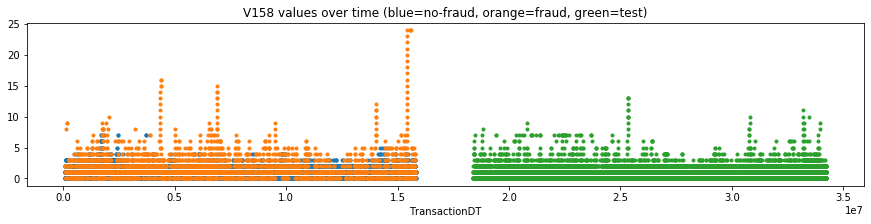

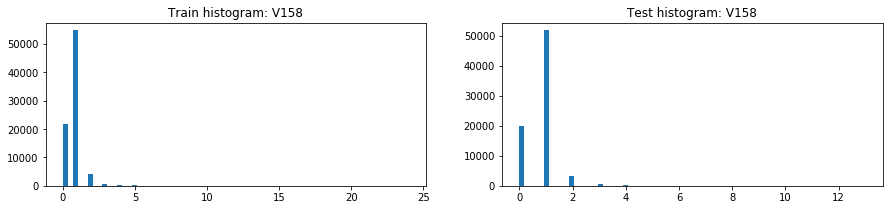

V158          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       0.833461      1.779178         0.789374   
2             std       0.734336      2.119609         0.557996   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      24.000000     24.000000         7.000000   
8   unique values      26.000000     26.000000         9.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        0.814515      0.874646       0.806575  
2        0.626397      0.710786       0.613956  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       13.000000      9.000000      13.000000  
8       15.000000     11.000000      15.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V158  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    1.0                  54744     0.028825        1578        51834.0
2    0.0                  21825     0.029828         651        19817.0
3    2.0                   4050     0.159753         647         3278.0
4    3.0                    762     0.431759         329          508.0
5    4.0                    287     0.689895         198          177.0
6    5.0                    113     0.893805         101           64.0
7    6.0                     60     0.850000          51           36.0
8    7.0                     34     0.735294          25           44.0
9    8.0                     19     1.000000          19            8.0

V158  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    1.0           54744     0.028825               1578          51834
2    0.0           21825     0.029828                651          19817
3    2.0            4050     0.159753                647           3278
4    3.0             762     0.431759                329            508
5    4.0             287     0.689895                198            177
6    5.0             113     0.893805                101             64
7    6.0              60     0.850000                 51             36
8    7.0              34     0.735294                 25             44
9    8.0              19     1.000000                 19              8

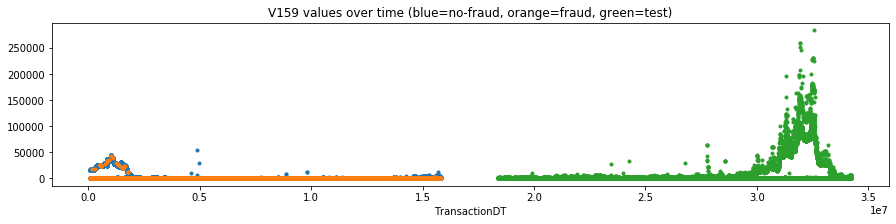

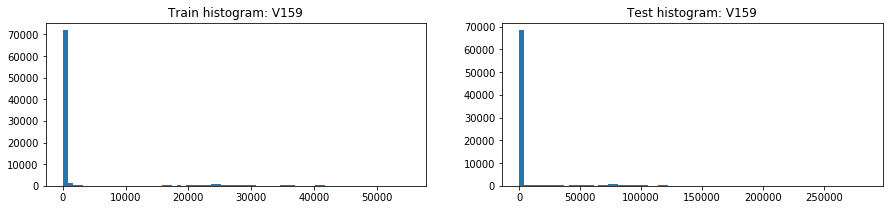

V159          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean    2719.299775    294.728242      2832.353551   
2             std    8355.445049   2687.570131      8511.473919   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000  43551.929688     55125.000000   
8   unique values    6664.000000    123.000000      6645.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1     6209.121689    127.541687    7016.442331  
2    21634.200105    596.909735   22903.319337  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   284129.812500  11000.000000  284129.812500  
8     6248.000000    227.000000    6176.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V159  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    0.0                  68397     0.049388        3378        64920.0
2  100.0                    413     0.031477          13          228.0
3   50.0                    230     0.065217          15          206.0
4  265.0                    193     0.000000           0            NaN
5   25.0                    172     0.063953          11          201.0
6  106.0                    169     0.000000           0            NaN
7   20.0                    156     0.012821           2          155.0
8  181.0                    146     0.000000           0            NaN
9   10.0                    115     0.026087           3          102.0

V159  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           68397     0.049388               3378          64920
2  200.0              70     0.285714                 20             82
3   50.0             230     0.065217                 15            206
4  150.0              91     0.153846                 14             73
5  100.0             413     0.031477                 13            228
6   25.0             172     0.063953                 11            201
7   15.0             101     0.108911                 11             87
8  250.0              46     0.195652                  9             43
9  300.0              54     0.111111                  6             33

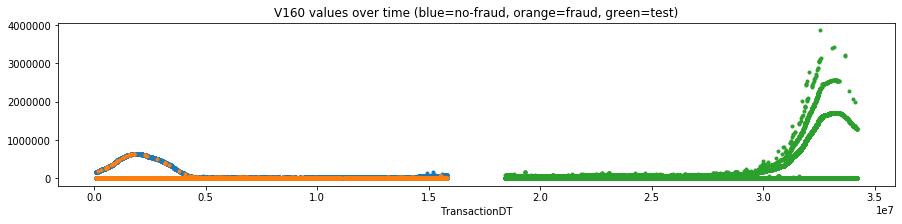

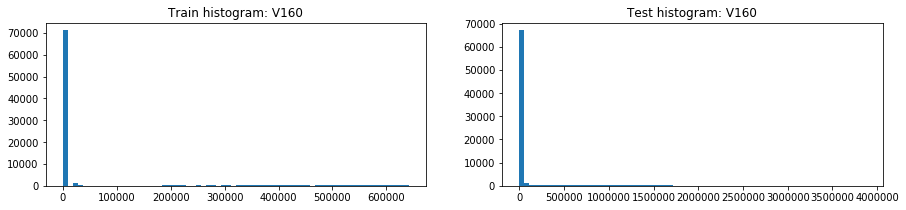

V160          Train    Train fraud  Train Not fraud  \
0           count   81951.000000    3651.000000     78300.000000   
1            mean   47453.181173    6437.664702     49365.667132   
2             std  142076.069162   52765.489660    144620.034216   
3             min       0.000000       0.000000         0.000000   
4             25%       0.000000       0.000000         0.000000   
5             50%       0.000000       0.000000         0.000000   
6             75%       0.000000       0.000000         0.000000   
7             max  641511.437500  639717.437500    641511.437500   
8   unique values    9622.000000     202.000000      9554.000000   
9            NaNs  508589.000000   17012.000000    491577.000000   
10     NaNs share       0.861200       0.823300         0.862600   

            Test    Test public  Test private  
0   7.605500e+04    8913.000000  6.714200e+04  
1   9.806603e+04    3354.763243  1.106388e+05  
2   3.376923e+05   14762.181207  3.574865e+05  
3   0.000000e+00       0.000000  0.000000e+00  
4   0.000000e+00       0.000000  0.000000e+00  
5   0.000000e+00       0.000000  0.000000e+00  
6   0.000000e+00       0.000000  0.000000e+00  
7   3.867868e+06  157203.000000  3.867868e+06  
8   7.956000e+03     522.000000  7.610000e+03  
9   4.306360e+05   92426.000000  3.382110e+05  
10  8.499000e-01       0.912000  8.344000e-01

V160  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508589     0.033449       17012       430636.0
1     0.0                  63341     0.046384        2938        60319.0
2  2401.0                    925     0.000000           0            1.0
3    50.0                    560     0.042857          24          517.0
4   100.0                    496     0.050403          25          531.0
5  1359.0                    325     0.000000           0            NaN
6    25.0                    260     0.073077          19          277.0
7   150.0                    256     0.152344          39          214.0
8   200.0                    225     0.204444          46          253.0
9    20.0                    188     0.031915           6          162.0

V160  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           63341     0.046384               2938          60319
2  200.0             225     0.204444                 46            253
3  150.0             256     0.152344                 39            214
4  300.0             129     0.248062                 32            112
5  250.0             132     0.234848                 31            119
6  100.0             496     0.050403                 25            531
7  450.0              40     0.625000                 25             31
8   50.0             560     0.042857                 24            517
9   75.0             181     0.110497                 20            178

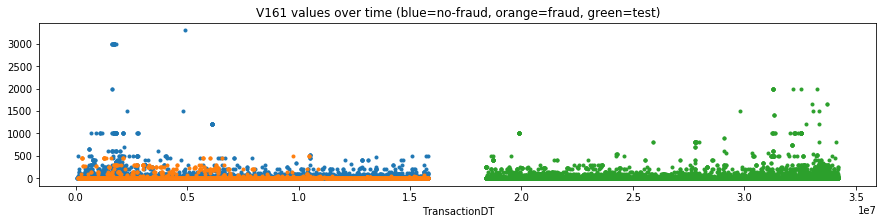

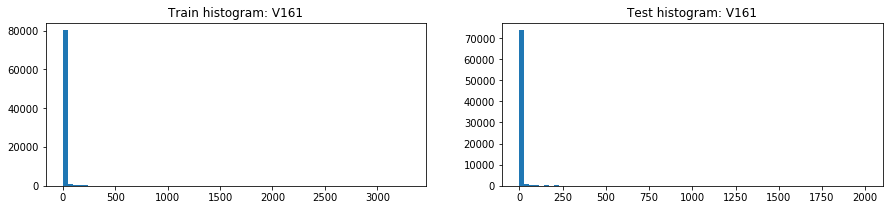

V161          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       4.843938     15.708219         4.337461   
2             std      58.929757     61.042699        58.780839   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    3300.000000    500.000000      3300.000000   
8   unique values      80.000000     30.000000        77.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        4.993831      6.818645       4.752897  
2       49.471160     46.403682      49.857401  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7     2000.000000   1000.000000    2000.000000  
8       77.000000     29.000000      77.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V161  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    0.0                  79211     0.041535        3290        72971.0
2   50.0                    472     0.036017          17          395.0
3  100.0                    366     0.081967          30          398.0
4   25.0                    220     0.090909          20          308.0
5  150.0                    161     0.279503          45          168.0
6   20.0                    135     0.088889          12          103.0
7  200.0                    135     0.229630          31          132.0
8   40.0                    134     0.059701           8           98.0
9   30.0                    112     0.223214          25          183.0

V161  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           79211     0.041535               3290          72971
2  150.0             161     0.279503                 45            168
3  300.0              84     0.428571                 36             69
4  200.0             135     0.229630                 31            132
5  100.0             366     0.081967                 30            398
6   30.0             112     0.223214                 25            183
7  250.0              69     0.347826                 24             74
8  450.0              32     0.656250                 21              1
9   25.0             220     0.090909                 20            308

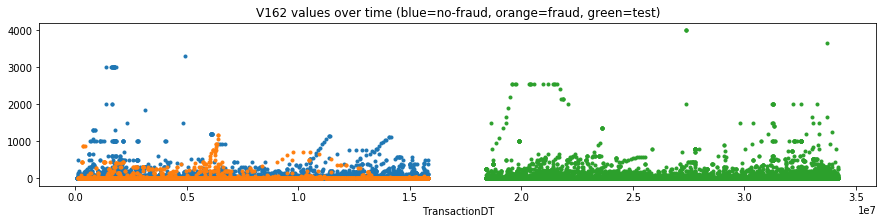

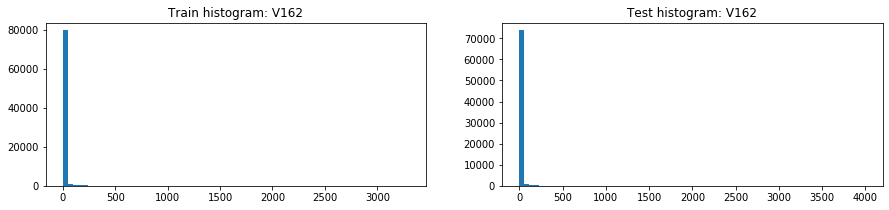

V162          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       6.594661     23.676712         5.798320   
2             std      69.195180     95.172398        67.637239   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    3300.000000   1170.000000      3300.000000   
8   unique values     186.000000     67.000000       166.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        8.262842     17.194932       7.083522  
2       79.645092    134.573335      69.123748  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7     4000.000000   2550.000000    4000.000000  
8      205.000000     93.000000     175.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V162  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    0.0                  79008     0.041211        3256        72721.0
2   50.0                    446     0.044843          20          364.0
3  100.0                    349     0.088825          31          389.0
4  150.0                    197     0.228426          45          159.0
5   25.0                    181     0.104972          19          199.0
6  200.0                    150     0.240000          36          168.0
7   75.0                    107     0.112150          12          118.0
8   30.0                    100     0.190000          19           89.0
9   20.0                     96     0.020833           2           75.0

V162  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           79008     0.041211               3256          72721
2  150.0             197     0.228426                 45            159
3  200.0             150     0.240000                 36            168
4  300.0              87     0.367816                 32             65
5  100.0             349     0.088825                 31            389
6  250.0              70     0.342857                 24             87
7  450.0              33     0.636364                 21             19
8   50.0             446     0.044843                 20            364
9   25.0             181     0.104972                 19            199

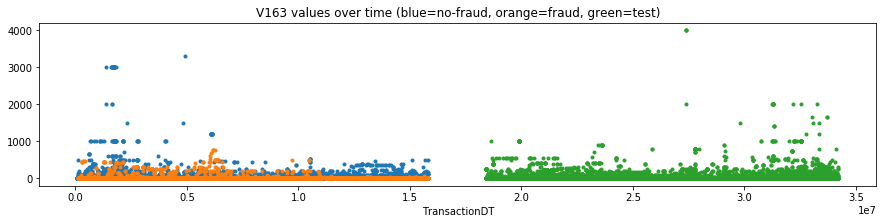

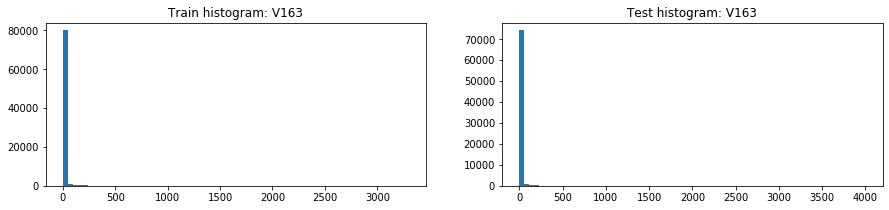

V163          Train   Train fraud  Train Not fraud  \
0           count   81945.000000   3650.000000     78295.000000   
1            mean       5.505955     19.100000         4.872220   
2             std      63.077887     75.358863        62.374807   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    3300.000000    770.000000      3300.000000   
8   unique values     107.000000     47.000000        92.000000   
9            NaNs  508595.000000  17013.000000    491582.000000   
10     NaNs share       0.861200      0.823400         0.862600   

             Test   Test public   Test private  
0    75785.000000   8839.000000   66946.000000  
1        6.146447     10.038692       5.632546  
2       59.674886     60.078465      59.602856  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7     4000.000000   1000.000000    4000.000000  
8      111.000000     50.000000     100.000000  
9   430906.000000  92500.000000  338407.000000  
10       0.850400      0.912800       0.834800

V163  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508595     0.033451       17013       430906.0
1    0.0                  79152     0.041477        3283        72901.0
2   50.0                    473     0.042283          20          397.0
3  100.0                    353     0.073654          26          384.0
4  150.0                    196     0.234694          46          153.0
5   25.0                    187     0.101604          19          228.0
6  200.0                    143     0.251748          36          151.0
7   20.0                    108     0.111111          12           80.0
8   75.0                     96     0.125000          12          129.0
9   30.0                     94     0.191489          18          142.0

V163  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508595     0.033451              17013         430906
1    0.0           79152     0.041477               3283          72901
2  150.0             196     0.234694                 46            153
3  200.0             143     0.251748                 36            151
4  300.0              79     0.392405                 31             49
5  100.0             353     0.073654                 26            384
6  250.0              68     0.352941                 24            102
7  450.0              33     0.636364                 21              6
8   50.0             473     0.042283                 20            397
9   25.0             187     0.101604                 19            228

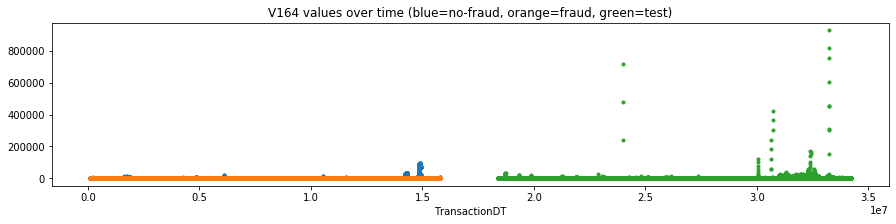

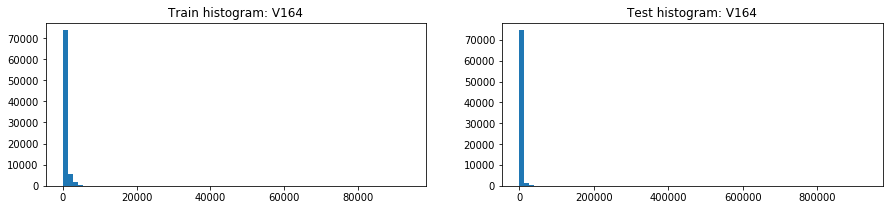

V164          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean     877.888928    109.053670       913.738450   
2             std    6049.166505    306.245568      6185.908288   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    100.000000         0.000000   
7             max   93736.000000   5450.000000     93736.000000   
8   unique values    1979.000000    120.000000      1971.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1     1037.892796    160.010187    1154.430399  
2     8501.111699   1351.796328    9027.966960  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  32880.000000  928882.000000  
8     1027.000000    172.000000     963.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V164  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    0.0                  63872     0.038734        2474        62799.0
2  100.0                    982     0.119145         117          590.0
3  200.0                    807     0.161090         130          701.0
4  150.0                    679     0.189985         129          429.0
5  300.0                    622     0.197749         123          383.0
6   50.0                    592     0.092905          55          333.0
7  400.0                    287     0.156794          45          363.0
8  450.0                    276     0.177536          49           99.0
9   75.0                    275     0.120000          33          135.0

V164  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           63872     0.038734               2474          62799
2  200.0             807     0.161090                130            701
3  150.0             679     0.189985                129            429
4  300.0             622     0.197749                123            383
5  100.0             982     0.119145                117            590
6   50.0             592     0.092905                 55            333
7  450.0             276     0.177536                 49             99
8  400.0             287     0.156794                 45            363
9  600.0             271     0.151292                 41            313

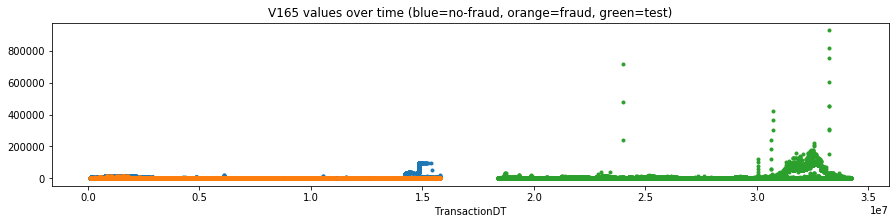

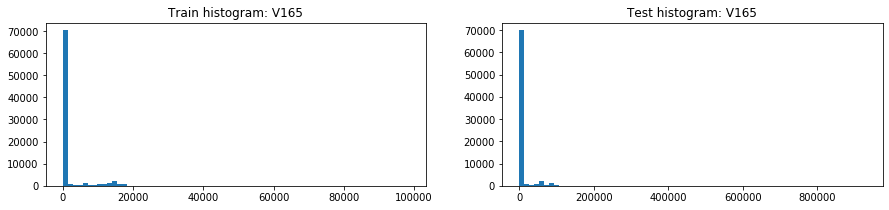

V165          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean    2239.912219    282.564747      2331.180107   
2             std    8223.258928   1410.663630      8396.153254   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    150.000000         0.000000   
7             max   98476.000000  17468.949219     98476.000000   
8   unique values    2548.000000    180.000000      2522.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1     5444.918030    391.059406    6115.810198  
2    19835.961392   1938.348110   21008.536825  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  32880.000000  928882.000000  
8     1502.000000    249.000000    1371.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V165  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508589     0.033449       17012       430636.0
1    0.0                  62598     0.036503        2285        61294.0
2  100.0                    921     0.125950         116          594.0
3  200.0                    672     0.188988         127          481.0
4  150.0                    661     0.211800         140          454.0
5  300.0                    596     0.216443         129          354.0
6   50.0                    536     0.110075          59          348.0
7  400.0                    267     0.198502          53          228.0
8  600.0                    250     0.196000          49          194.0
9   75.0                    228     0.114035          26          133.0

V165  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           62598     0.036503               2285          61294
2  150.0             661     0.211800                140            454
3  300.0             596     0.216443                129            354
4  200.0             672     0.188988                127            481
5  100.0             921     0.125950                116            594
6   50.0             536     0.110075                 59            348
7  400.0             267     0.198502                 53            228
8  600.0             250     0.196000                 49            194
9  450.0             179     0.262570                 47            102

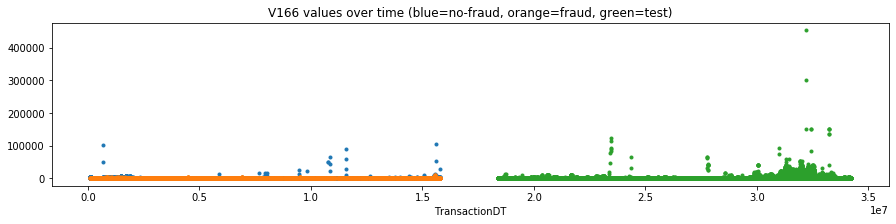

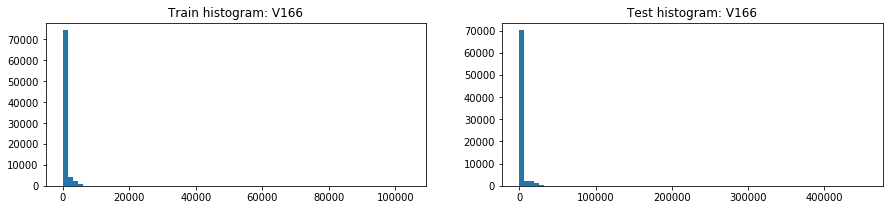

V166          Train   Train fraud  Train Not fraud  \
0           count   81951.000000   3651.000000     78300.000000   
1            mean     359.469437    189.828217       367.379528   
2             std    1244.463270    536.808466      1267.306208   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    175.000000         0.000000   
7             max  104060.000000   9000.000000    104060.000000   
8   unique values     988.000000    164.000000       970.000000   
9            NaNs  508589.000000  17012.000000    491577.000000   
10     NaNs share       0.861200      0.823300         0.862600   

             Test   Test public   Test private  
0    76055.000000   8913.000000   67142.000000  
1     1387.647859    185.373432    1547.247989  
2     5266.892386    912.641928    5576.267413  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   453750.000000  12000.000000  453750.000000  
8     1521.000000    217.000000    1450.000000  
9   430636.000000  92426.000000  338211.000000  
10       0.849900      0.912000       0.834400

V166  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508589     0.033449       17012       430636.0
1     0.0                  62439     0.036804        2298        59661.0
2   100.0                   1391     0.073329         102         1083.0
3   200.0                   1016     0.127953         130          922.0
4  1165.0                    876     0.000000           0            NaN
5   150.0                    736     0.158967         117          557.0
6   300.0                    728     0.192308         140          547.0
7    50.0                    625     0.092800          58          528.0
8   400.0                    403     0.138958          56          492.0
9   500.0                    363     0.107438          39          417.0

V166  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508589     0.033449              17012         430636
1    0.0           62439     0.036804               2298          59661
2  300.0             728     0.192308                140            547
3  200.0            1016     0.127953                130            922
4  150.0             736     0.158967                117            557
5  100.0            1391     0.073329                102           1083
6  600.0             345     0.173913                 60            331
7   50.0             625     0.092800                 58            528
8  400.0             403     0.138958                 56            492
9  450.0             254     0.204724                 52             98

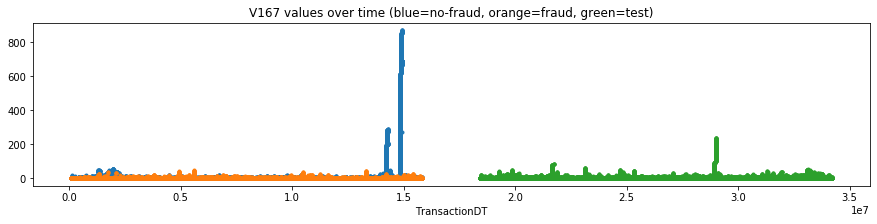

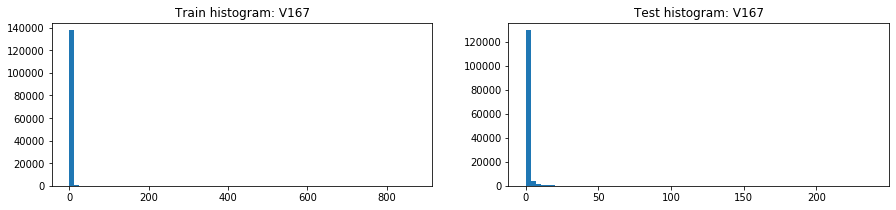

V167          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       3.929514      2.078177         4.088443   
2             std      42.200980      4.182894        43.954364   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max     872.000000     47.000000       872.000000   
8   unique values     874.000000     49.000000       874.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.969773      1.169478       0.939574  
2        6.422466      4.446515       6.670010  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      1.000000       0.000000  
7      238.000000     85.000000     238.000000  
8      240.000000     87.000000     240.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V167  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 106161     0.047786        5073       103369.0
2    1.0                  15561     0.135467        2108        15664.0
3    2.0                   6854     0.178290        1222         6747.0
4    3.0                   3592     0.211581         760         3589.0
5    4.0                   2047     0.245237         502         2133.0
6    5.0                   1106     0.279385         309         1225.0
7    6.0                    715     0.304895         218          813.0
8    7.0                    494     0.325911         161          542.0
9    8.0                    343     0.361516         124          400.0

V167  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          106161     0.047786               5073         103369
2    1.0           15561     0.135467               2108          15664
3    2.0            6854     0.178290               1222           6747
4    3.0            3592     0.211581                760           3589
5    4.0            2047     0.245237                502           2133
6    5.0            1106     0.279385                309           1225
7    6.0             715     0.304895                218            813
8    7.0             494     0.325911                161            542
9    8.0             343     0.361516                124            400

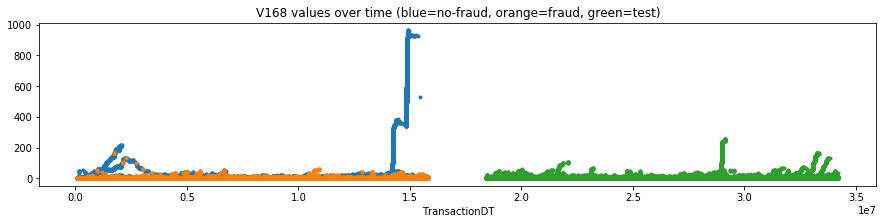

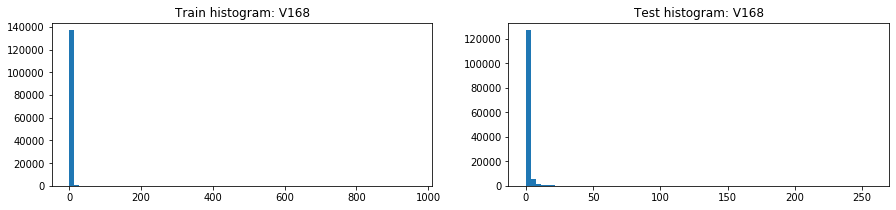

V168          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       5.859501      2.904973         6.113133   
2             std      54.032468      6.689211        56.262604   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       1.000000      3.000000         0.000000   
7             max     964.000000    164.000000       964.000000   
8   unique values     966.000000     71.000000       966.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.422148      1.723345       1.376601  
2        8.431223      5.860936       8.753580  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7      257.000000     88.000000     257.000000  
8      259.000000     90.000000     259.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V168  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 101660     0.044806        4555        98083.0
2    1.0                  16532     0.120252        1988        16922.0
3    2.0                   7520     0.165559        1245         7541.0
4    3.0                   4093     0.197899         810         4091.0
5    4.0                   2397     0.236546         567         2510.0
6    5.0                   1400     0.258571         362         1591.0
7    6.0                    943     0.272534         257         1105.0
8    7.0                    647     0.295209         191          743.0
9    8.0                    476     0.329832         157          535.0

V168  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          101660     0.044806               4555          98083
2    1.0           16532     0.120252               1988          16922
3    2.0            7520     0.165559               1245           7541
4    3.0            4093     0.197899                810           4091
5    4.0            2397     0.236546                567           2510
6    5.0            1400     0.258571                362           1591
7    6.0             943     0.272534                257           1105
8    7.0             647     0.295209                191            743
9    8.0             476     0.329832                157            535

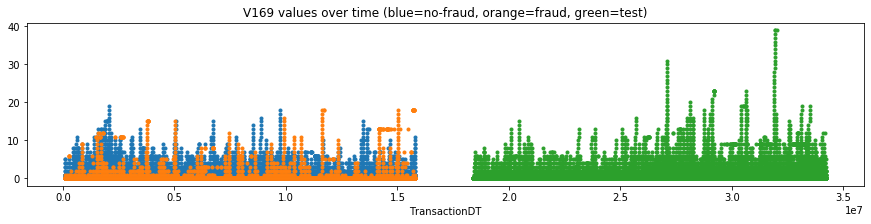

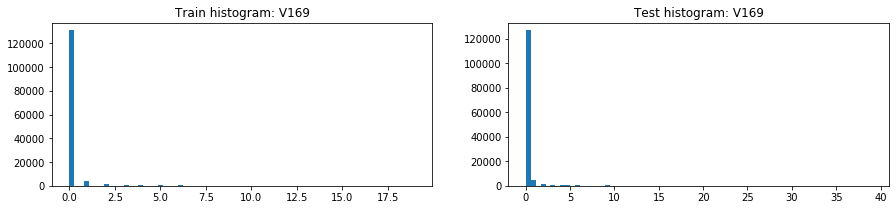

V169          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.168053      0.378229         0.149982   
2             std       0.904944      1.752748         0.788091   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      19.000000     18.000000        19.000000   
8   unique values      21.000000     20.000000        21.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.202684      0.142103       0.211784  
2        1.130437      0.748096       1.176926  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       39.000000     15.000000      39.000000  
8       41.000000     17.000000      41.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V169  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    0.0                 130911     0.077144       10099         126545
2    1.0                   4117     0.077484         319           4829
3    2.0                   1707     0.102519         175           1696
4    3.0                   1034     0.093810          97            980
5    4.0                    702     0.096866          68            687
6    5.0                    394     0.126904          50            458
7    6.0                    333     0.150150          50            257
8    7.0                    177     0.158192          28            152
9    8.0                    112     0.267857          30            117

V169  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          130911     0.077144              10099         126545
1 -999.0          450721     0.021284               9593         370316
2    1.0            4117     0.077484                319           4829
3    2.0            1707     0.102519                175           1696
4    3.0            1034     0.093810                 97            980
5    4.0             702     0.096866                 68            687
6    5.0             394     0.126904                 50            458
7    6.0             333     0.150150                 50            257
8   13.0              58     0.689655                 40             36
9   11.0              54     0.574074                 31             55

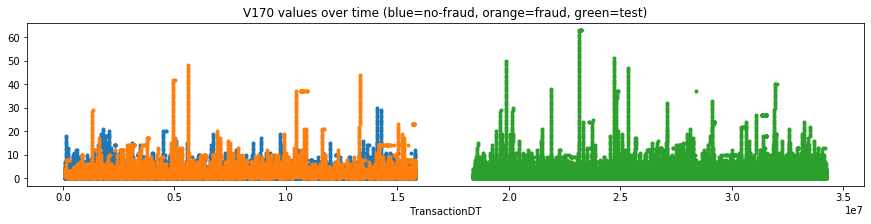

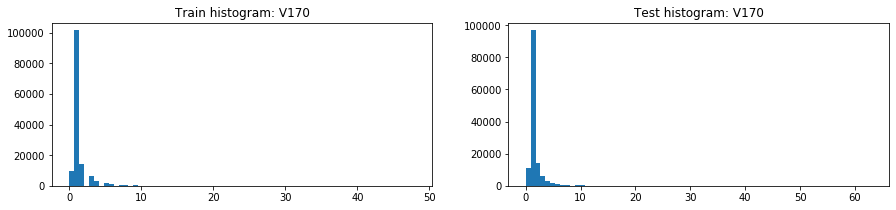

V170          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       1.436779      2.928546         1.308515   
2             std       1.751143      4.370712         1.216551   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      48.000000     48.000000        30.000000   
8   unique values      50.000000     50.000000        32.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        1.487487      1.632923       1.465639  
2        2.151799      2.416838       2.108254  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      2.000000       1.000000  
7       63.000000     50.000000      63.000000  
8       65.000000     52.000000      65.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V170  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 101509     0.047966        4869          96726
2    2.0                  14255     0.145633        2076          14296
3    0.0                   9693     0.059631         578          10930
4    3.0                   6204     0.184558        1145           5947
5    4.0                   3199     0.224133         717           3053
6    5.0                   1869     0.230605         431           1824
7    6.0                    879     0.302617         266           1109
8    7.0                    604     0.284768         172            617
9    8.0                    406     0.386700         157            395

V170  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          101509     0.047966               4869          96726
2    2.0           14255     0.145633               2076          14296
3    3.0            6204     0.184558               1145           5947
4    4.0            3199     0.224133                717           3053
5    0.0            9693     0.059631                578          10930
6    5.0            1869     0.230605                431           1824
7    6.0             879     0.302617                266           1109
8    7.0             604     0.284768                172            617
9    8.0             406     0.386700                157            395

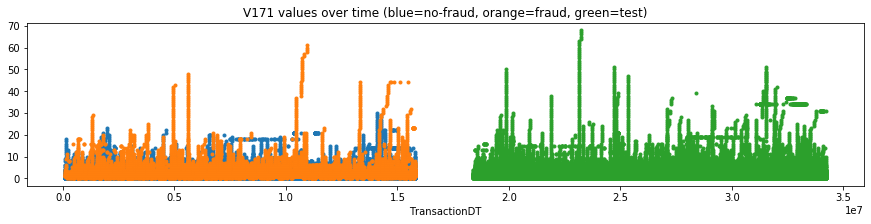

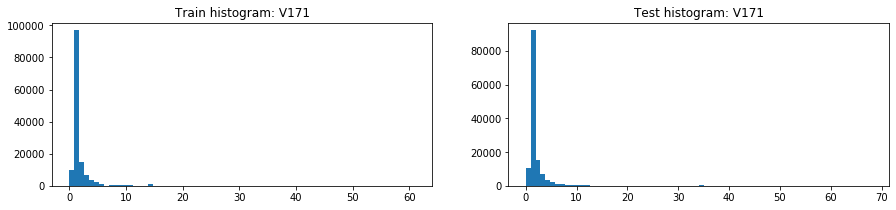

V171          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       1.690908      3.496025         1.535701   
2             std       2.444748      5.267626         1.949572   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      4.000000         1.000000   
7             max      61.000000     61.000000        30.000000   
8   unique values      63.000000     63.000000        32.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        1.735017      1.827073       1.721189  
2        2.941901      2.741076       2.970662  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      2.000000       1.000000  
7       68.000000     50.000000      68.000000  
8       70.000000     52.000000      70.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V171  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                  96818     0.045787        4433          92136
2    2.0                  15088     0.126922        1915          15079
3    0.0                   9579     0.058252         558          10819
4    3.0                   6802     0.172155        1171           6837
5    4.0                   3644     0.206092         751           3652
6    5.0                   2099     0.248690         522           2285
7   14.0                   1425     0.032281          46            141
8    6.0                   1264     0.283228         358           1318
9    7.0                    727     0.298487         217            908

V171  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0           96818     0.045787               4433          92136
2    2.0           15088     0.126922               1915          15079
3    3.0            6802     0.172155               1171           6837
4    4.0            3644     0.206092                751           3652
5    0.0            9579     0.058252                558          10819
6    5.0            2099     0.248690                522           2285
7    6.0            1264     0.283228                358           1318
8    7.0             727     0.298487                217            908
9    8.0             565     0.292035                165            551

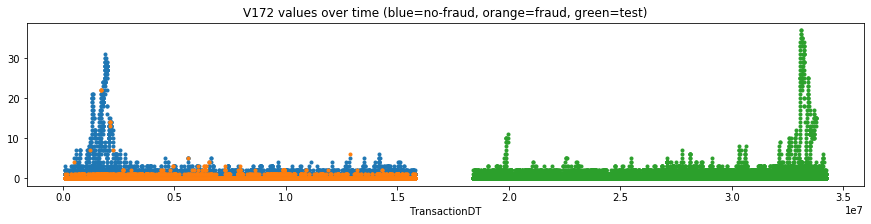

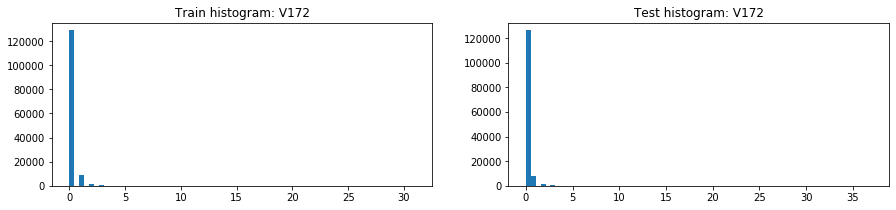

V172          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       0.132012      0.090226         0.135599   
2             std       0.924894      0.547949         0.950226   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      31.000000     22.000000        31.000000   
8   unique values      33.000000     12.000000        33.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.128929      0.093258       0.134323  
2        0.922958      0.420441       0.976585  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       37.000000     11.000000      37.000000  
8       39.000000     13.000000      39.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V172  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    0.0                 128800     0.079604       10253         126250
2    1.0                   8698     0.082203         715           8122
3    2.0                   1361     0.035268          48           1518
4    3.0                    265     0.033962           9            413
5    4.0                     63     0.047619           3            107
6    7.0                     48     0.041667           2             25
7    5.0                     46     0.021739           1             37
8    6.0                     39     0.025641           1             28
9   11.0                     26     0.000000           0             25

V172  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          128800     0.079604              10253         126250
1 -999.0          450909     0.021344               9624         369957
2    1.0            8698     0.082203                715           8122
3    2.0            1361     0.035268                 48           1518
4    3.0             265     0.033962                  9            413
5    4.0              63     0.047619                  3            107
6   14.0              15     0.200000                  3              7
7   22.0               7     0.428571                  3              3
8    7.0              48     0.041667                  2             25
9    5.0              46     0.021739                  1             37

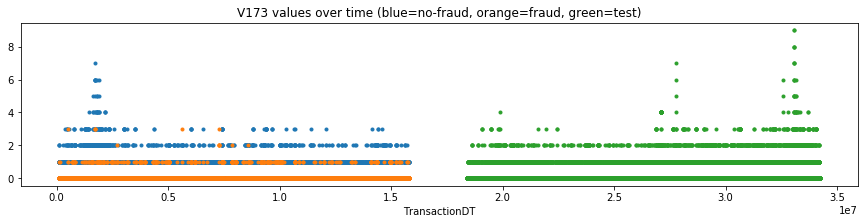

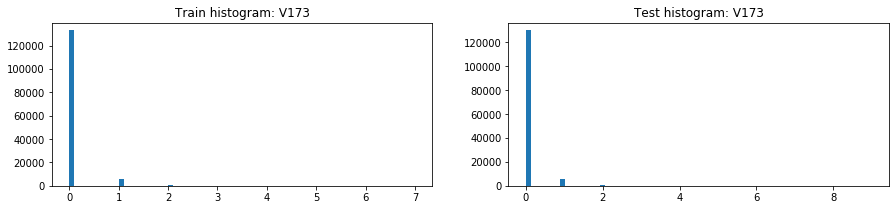

V173          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       0.055231      0.035963         0.056885   
2             std       0.264439      0.197997         0.269317   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max       7.000000      3.000000         7.000000   
8   unique values       9.000000      5.000000         9.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.060351      0.047714       0.062262  
2        0.294787      0.247269       0.301276  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        9.000000      4.000000       9.000000  
8       11.000000      6.000000      11.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V173  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    0.0                 132868     0.080238       10661         129946
2    1.0                   6020     0.060631         365           5691
3    2.0                    589     0.011885           7            853
4    3.0                    124     0.048387           6            175
5    4.0                     17     0.000000           0             46
6    6.0                      7     0.000000           0              6
7    5.0                      5     0.000000           0              8
8    7.0                      1     0.000000           0              4

V173  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          132868     0.080238              10661         129946
1 -999.0          450909     0.021344               9624         369957
2    1.0            6020     0.060631                365           5691
3    2.0             589     0.011885                  7            853
4    3.0             124     0.048387                  6            175
5    4.0              17     0.000000                  0             46
6    6.0               7     0.000000                  0              6
7    5.0               5     0.000000                  0              8
8    7.0               1     0.000000                  0              4

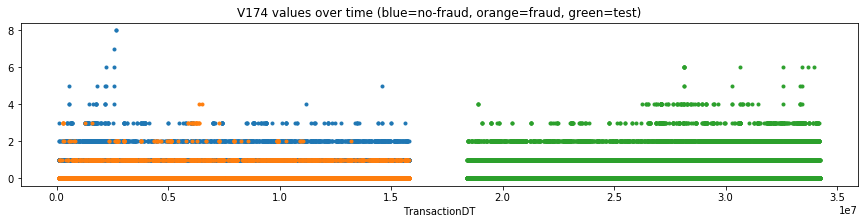

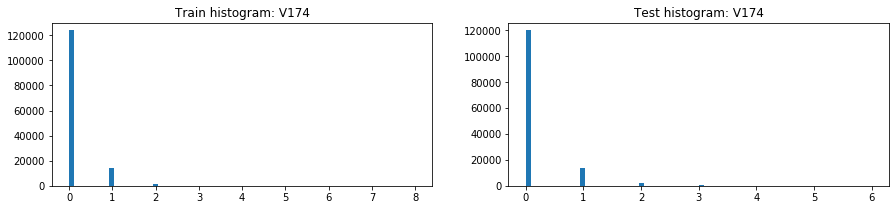

V174          Train  Train fraud  Train Not fraud           Test  \
0           count  139819.000000  11070.00000    128749.000000  136375.000000   
1            mean       0.127794      0.14878         0.125989       0.146434   
2             std       0.379763      0.39852         0.378054       0.431142   
3             min       0.000000      0.00000         0.000000       0.000000   
4             25%       0.000000      0.00000         0.000000       0.000000   
5             50%       0.000000      0.00000         0.000000       0.000000   
6             75%       0.000000      0.00000         0.000000       0.000000   
7             max       8.000000      4.00000         8.000000       6.000000   
8   unique values      10.000000      6.00000        10.000000       8.000000   
9            NaNs  450721.000000   9593.00000    441128.000000  370316.000000   
10     NaNs share       0.763200      0.46430         0.774100       0.730900   

     Test public   Test private  
0   17811.000000  118564.000000  
1       0.126719       0.149396  
2       0.385226       0.437549  
3       0.000000       0.000000  
4       0.000000       0.000000  
5       0.000000       0.000000  
6       0.000000       0.000000  
7       4.000000       6.000000  
8       6.000000       8.000000  
9   83528.000000  286789.000000  
10      0.824200       0.707500

V174  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    0.0                 123863     0.077279        9572       119736.0
2    1.0                  14337     0.095975        1376        13952.0
3    2.0                   1373     0.070648          97         2184.0
4    3.0                    220     0.104545          23          388.0
5    4.0                     15     0.133333           2           99.0
6    5.0                      6     0.000000           0            6.0
7    6.0                      2     0.000000           0           10.0
8    8.0                      2     0.000000           0            NaN
9    7.0                      1     0.000000           0            NaN

V174  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593       370316.0
1    0.0          123863     0.077279               9572       119736.0
2    1.0           14337     0.095975               1376        13952.0
3    2.0            1373     0.070648                 97         2184.0
4    3.0             220     0.104545                 23          388.0
5    4.0              15     0.133333                  2           99.0
6    5.0               6     0.000000                  0            6.0
7    6.0               2     0.000000                  0           10.0
8    8.0               2     0.000000                  0            NaN
9    7.0               1     0.000000                  0            NaN

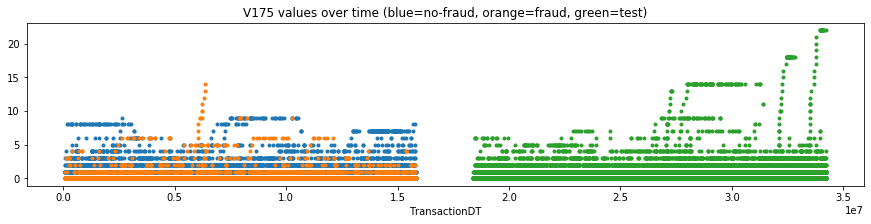

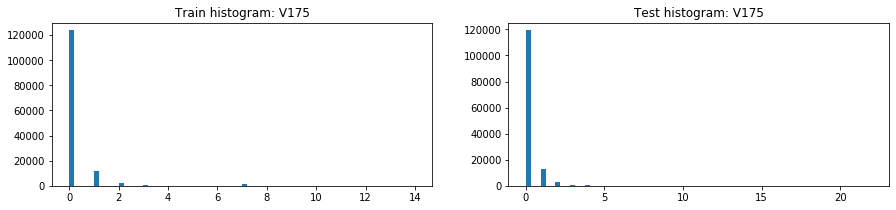

V175          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.212639      0.206143         0.213198   
2             std       0.857133      0.717197         0.868112   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      14.000000     14.000000         9.000000   
8   unique values      16.000000     16.000000        11.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.198885      0.158498       0.204953  
2        0.819637      0.533102       0.854256  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       22.000000      6.000000      22.000000  
8       24.000000      8.000000      24.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V175  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    0.0                 123575     0.077103        9528         119191
2    1.0                  11962     0.102658        1228          12528
3    2.0                   1866     0.090032         168           2931
4    7.0                   1350     0.000741           1             42
5    3.0                    537     0.106145          57            995
6    4.0                    212     0.084906          18            283
7    5.0                    116     0.155172          18             99
8    6.0                     71     0.492958          35             55
9    8.0                     64     0.015625           1             13

V175  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    0.0          123575     0.077103               9528         119191
2    1.0           11962     0.102658               1228          12528
3    2.0            1866     0.090032                168           2931
4    3.0             537     0.106145                 57            995
5    6.0              71     0.492958                 35             55
6    4.0             212     0.084906                 18            283
7    5.0             116     0.155172                 18             99
8    9.0              60     0.166667                 10             46
9   10.0               2     1.000000                  2              8

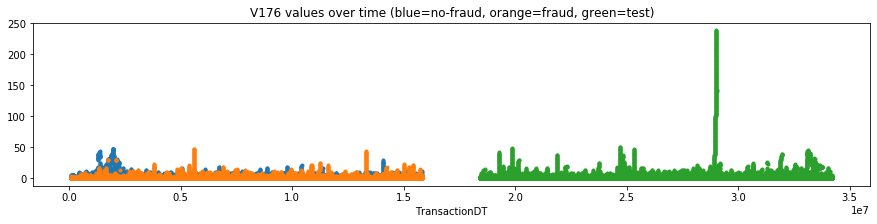

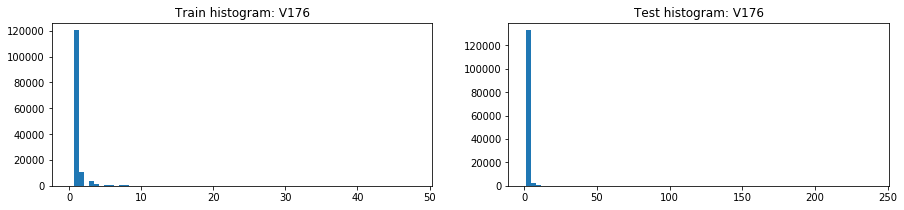

V176          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.376979      2.403116         1.288890   
2             std       1.829420      3.468886         1.582096   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      48.000000     48.000000        48.000000   
8   unique values      50.000000     50.000000        50.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.636762      1.557931       1.648683  
2        6.094771      2.365208       6.474301  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      239.000000     49.000000     239.000000  
8      240.000000     50.000000     240.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V176  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    1.0                 120220     0.054675        6573       115854.0
2    2.0                  10616     0.176149        1870        11120.0
3    3.0                   3595     0.251460         904         3850.0
4    4.0                   1770     0.282486         500         1855.0
5    5.0                    995     0.292462         291         1049.0
6    6.0                    603     0.325041         196          707.0
7    7.0                    405     0.377778         153          462.0
8    8.0                    269     0.371747         100          282.0
9    9.0                    184     0.396739          73          202.0

V176  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    1.0          120220     0.054675               6573         115854
2    2.0           10616     0.176149               1870          11120
3    3.0            3595     0.251460                904           3850
4    4.0            1770     0.282486                500           1855
5    5.0             995     0.292462                291           1049
6    6.0             603     0.325041                196            707
7    7.0             405     0.377778                153            462
8    8.0             269     0.371747                100            282
9    9.0             184     0.396739                 73            202

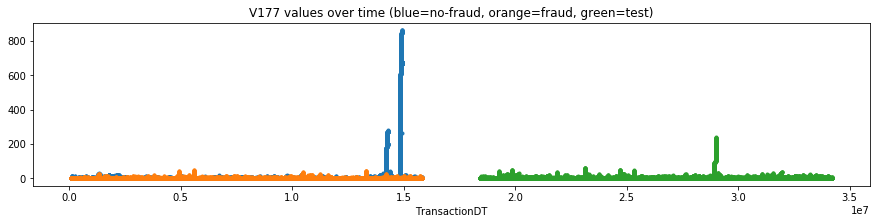

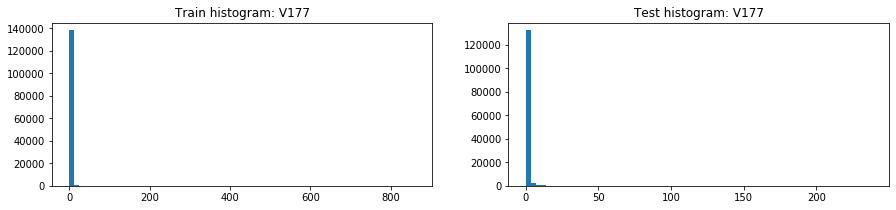

V177          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       3.529245      1.595434         3.695253   
2             std      41.310622      3.878491        43.028239   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max     861.000000     47.000000       861.000000   
8   unique values     863.000000     49.000000       863.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.642525      0.673515       0.637839  
2        6.105650      2.665517       6.468527  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      238.000000     49.000000     238.000000  
8      240.000000     51.000000     240.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V177  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 120997     0.053001        6413       119067.0
2    1.0                   7687     0.233381        1794         6957.0
3    2.0                   3871     0.230690         893         3810.0
4    3.0                   2104     0.252852         532         2103.0
5    4.0                   1189     0.285114         339         1305.0
6    5.0                    677     0.355982         241          786.0
7    6.0                    441     0.385488         170          525.0
8    7.0                    349     0.389685         136          381.0
9    8.0                    232     0.413793          96          272.0

V177  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          120997     0.053001               6413         119067
2    1.0            7687     0.233381               1794           6957
3    2.0            3871     0.230690                893           3810
4    3.0            2104     0.252852                532           2103
5    4.0            1189     0.285114                339           1305
6    5.0             677     0.355982                241            786
7    6.0             441     0.385488                170            525
8    7.0             349     0.389685                136            381
9    8.0             232     0.413793                 96            272

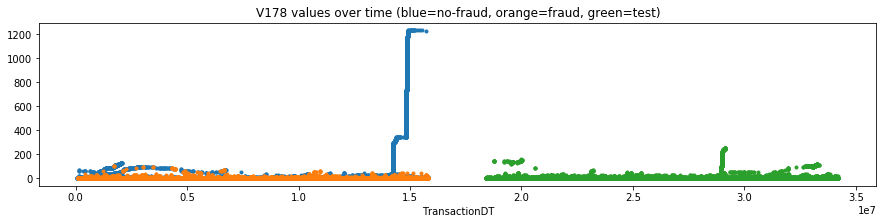

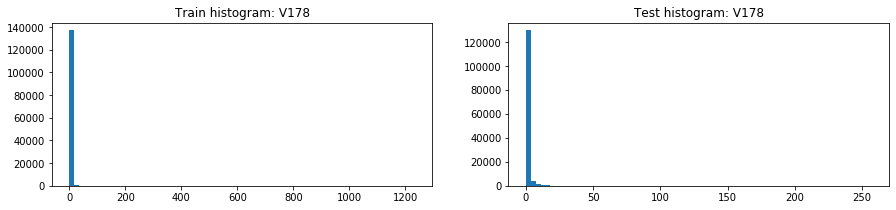

V178          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       6.649283      2.728055         6.985901   
2             std      69.447364      7.235370        72.325917   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max    1235.000000    102.000000      1235.000000   
8   unique values    1237.000000     75.000000      1237.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.083995      1.521519       1.017832  
2        8.525969      9.611565       8.347576  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      257.000000    158.000000     257.000000  
8      259.000000     90.000000     259.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V178  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 118836     0.049943        5935       116464.0
2    1.0                   7569     0.219448        1661         6927.0
3    2.0                   3987     0.221219         882         3977.0
4    3.0                   2232     0.234767         524         2346.0
5    4.0                   1336     0.269461         360         1519.0
6    5.0                    829     0.328106         272          983.0
7    6.0                    548     0.377737         207          703.0
8    7.0                    430     0.400000         172          507.0
9    8.0                    296     0.418919         124          392.0

V178  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          118836     0.049943               5935         116464
2    1.0            7569     0.219448               1661           6927
3    2.0            3987     0.221219                882           3977
4    3.0            2232     0.234767                524           2346
5    4.0            1336     0.269461                360           1519
6    5.0             829     0.328106                272            983
7    6.0             548     0.377737                207            703
8    7.0             430     0.400000                172            507
9    8.0             296     0.418919                124            392

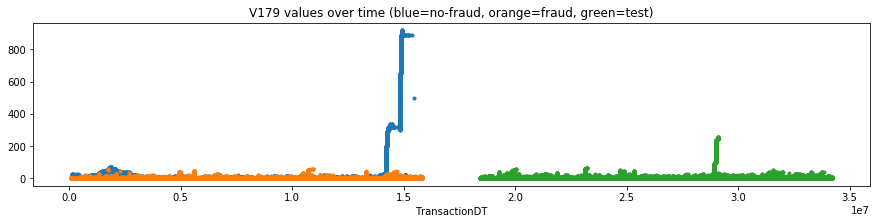

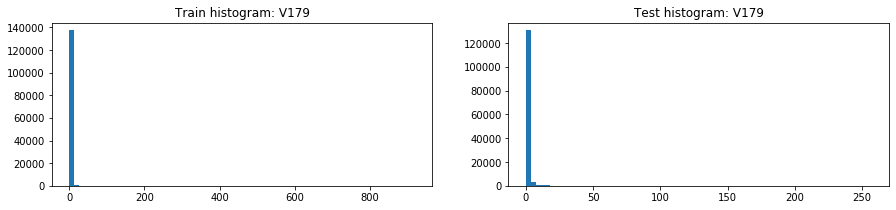

V179          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       4.869012      2.128363         5.104283   
2             std      50.489426      5.128527        52.583847   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max     920.000000     60.000000       920.000000   
8   unique values     922.000000     62.000000       922.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.822985      0.910528       0.809746  
2        6.981044      3.580067       7.359713  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      257.000000     58.000000     257.000000  
8      259.000000     60.000000     259.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V179  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 119688     0.050732        6072       117611.0
2    1.0                   7570     0.227873        1725         6913.0
3    2.0                   3933     0.229087         901         3890.0
4    3.0                   2177     0.248507         541         2259.0
5    4.0                   1311     0.279939         367         1448.0
6    5.0                    770     0.336364         259          878.0
7    6.0                    520     0.378846         197          609.0
8    7.0                    389     0.424165         165          436.0
9    8.0                    267     0.445693         119          334.0

V179  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          119688     0.050732               6072         117611
2    1.0            7570     0.227873               1725           6913
3    2.0            3933     0.229087                901           3890
4    3.0            2177     0.248507                541           2259
5    4.0            1311     0.279939                367           1448
6    5.0             770     0.336364                259            878
7    6.0             520     0.378846                197            609
8    7.0             389     0.424165                165            436
9    8.0             267     0.445693                119            334

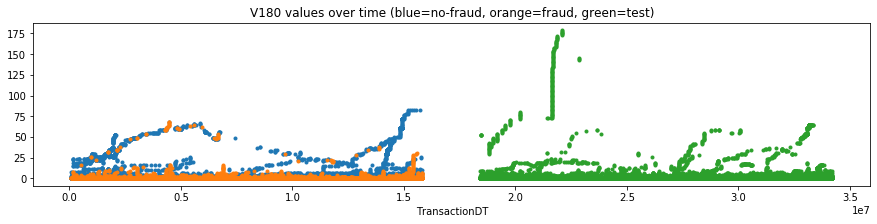

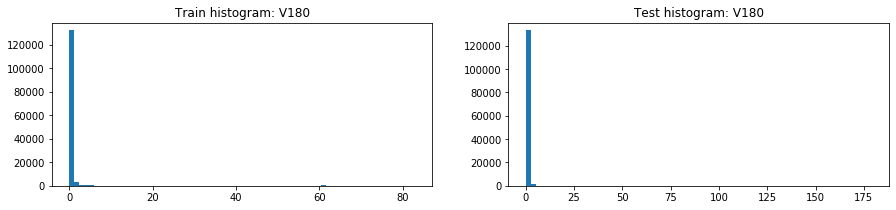

V180          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.924123      0.729449         0.940862   
2             std       6.112630      3.797911         6.271623   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      83.000000     68.000000        83.000000   
8   unique values      85.000000     55.000000        85.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.465687      1.089664       0.371951  
2        4.623885      8.995338       3.517104  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      179.000000    158.000000     179.000000  
8      181.000000    154.000000      89.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V180  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    0.0                 122945     0.069608        8558         120424
2    1.0                   9318     0.147242        1372           9781
3    2.0                   2888     0.185942         537           2920
4    3.0                   1096     0.200730         220           1098
5   61.0                    874     0.004577           4             16
6    4.0                    465     0.238710         111            580
7    5.0                    267     0.247191          66            268
8   34.0                    242     0.020661           5             10
9    6.0                    139     0.258993          36            132

V180  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    0.0          122945     0.069608               8558         120424
2    1.0            9318     0.147242               1372           9781
3    2.0            2888     0.185942                537           2920
4    3.0            1096     0.200730                220           1098
5    4.0             465     0.238710                111            580
6    5.0             267     0.247191                 66            268
7    6.0             139     0.258993                 36            132
8    7.0              86     0.267442                 23            100
9    8.0              71     0.225352                 16             47

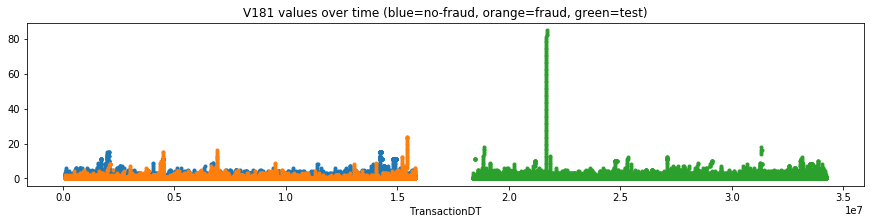

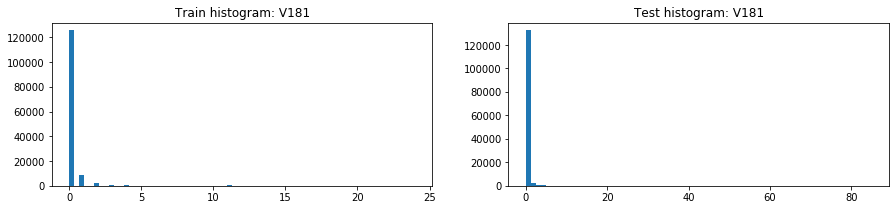

V181          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       0.253332      0.374128         0.242962   
2             std       1.248974      1.241782         1.249050   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      24.000000     24.000000        15.000000   
8   unique values      26.000000     26.000000        17.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.183173      0.383442       0.152888  
2        1.389138      3.469564       0.627886  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       85.000000     85.000000      18.000000  
8       87.000000     87.000000      19.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V181  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    0.0                 125518     0.071249        8943         123637
2    1.0                   8514     0.148931        1268           8758
3    2.0                   2597     0.169041         439           2465
4   11.0                    986     0.005071           5             23
5    3.0                    953     0.189927         181            966
6    4.0                    403     0.200993          81            354
7   15.0                    179     0.022346           4              3
8    5.0                    164     0.231707          38            157
9    6.0                     87     0.195402          17             92

V181  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          125518     0.071249               8943         123637
2    1.0            8514     0.148931               1268           8758
3    2.0            2597     0.169041                439           2465
4    3.0             953     0.189927                181            966
5    4.0             403     0.200993                 81            354
6    5.0             164     0.231707                 38            157
7    6.0              87     0.195402                 17             92
8    7.0              62     0.241935                 15             49
9    8.0              42     0.285714                 12             58

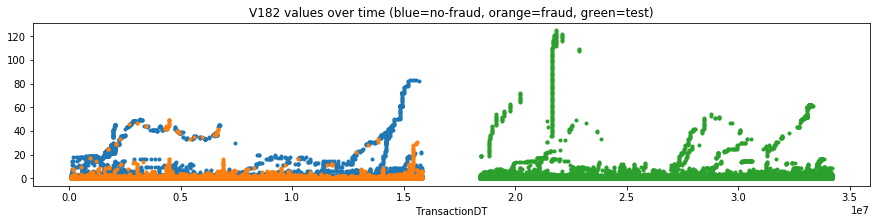

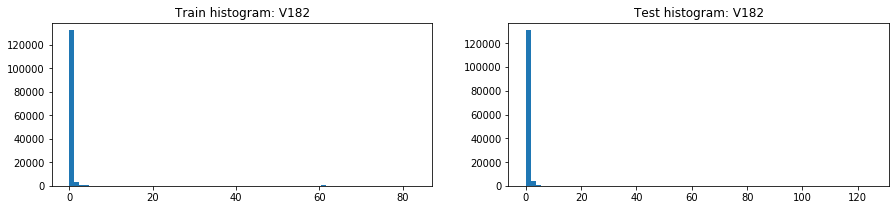

V182          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       0.856243      0.656400         0.873398   
2             std       5.792934      2.961885         5.973453   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      83.000000     49.000000        83.000000   
8   unique values      85.000000     49.000000        85.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.407667      0.838149       0.342569  
2        3.638033      6.506766       2.966882  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      125.000000    121.000000     125.000000  
8      127.000000    123.000000      78.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V182  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    0.0                 123142     0.069570        8567         121029
2    1.0                   9105     0.148600        1353           9683
3    2.0                   2826     0.186837         528           2896
4    3.0                   1077     0.197772         213           1083
5   61.0                    863     0.000000           0              9
6    4.0                    487     0.232033         113            536
7    5.0                    243     0.263374          64            265
8   34.0                    195     0.000000           0              7
9    6.0                    129     0.263566          34            142

V182  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          123142     0.069570               8567         121029
2    1.0            9105     0.148600               1353           9683
3    2.0            2826     0.186837                528           2896
4    3.0            1077     0.197772                213           1083
5    4.0             487     0.232033                113            536
6    5.0             243     0.263374                 64            265
7    6.0             129     0.263566                 34            142
8    7.0              85     0.270588                 23            108
9    8.0              61     0.262295                 16             57

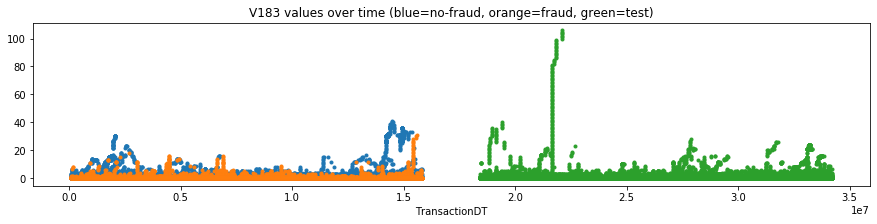

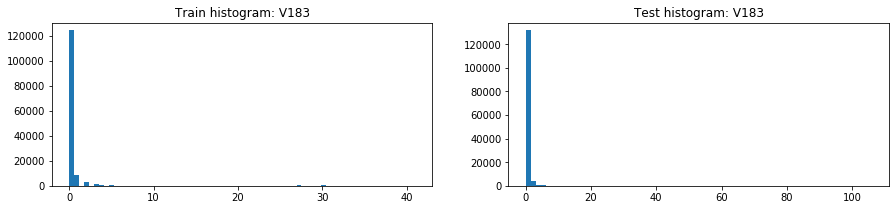

V183          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       0.484692      0.478123         0.485256   
2             std       2.946982      1.603992         3.034699   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      41.000000     31.000000        41.000000   
8   unique values      43.000000     33.000000        43.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        0.265311      0.504426       0.229151  
2        2.091527      3.815817       1.680566  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      106.000000     85.000000     106.000000  
8      108.000000     87.000000      51.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V183  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    0.0                 124108     0.070028        8691         122245
2    1.0                   8833     0.152610        1348           9251
3    2.0                   2688     0.185640         499           2643
4    3.0                   1069     0.187091         200           1033
5   27.0                    658     0.001520           1              4
6    4.0                    481     0.185031          89            462
7   30.0                    346     0.002890           1              3
8    5.0                    242     0.260331          63            218
9    6.0                    137     0.175182          24            111

V183  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          124108     0.070028               8691         122245
2    1.0            8833     0.152610               1348           9251
3    2.0            2688     0.185640                499           2643
4    3.0            1069     0.187091                200           1033
5    4.0             481     0.185031                 89            462
6    5.0             242     0.260331                 63            218
7    6.0             137     0.175182                 24            111
8    7.0             134     0.141791                 19             73
9   12.0              56     0.303571                 17             46

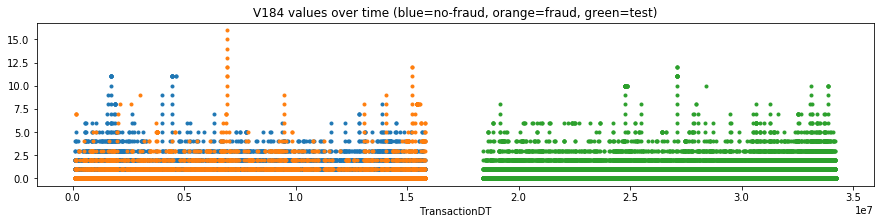

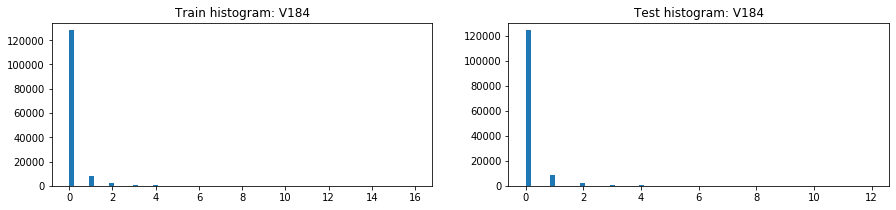

V184          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.132364      0.357453         0.113011   
2             std       0.543699      1.007989         0.478478   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      16.000000     16.000000        11.000000   
8   unique values      18.000000     18.000000        13.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.133588      0.133850       0.133548  
2        0.540079      0.522965       0.542605  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       12.000000      8.000000      12.000000  
8       14.000000     10.000000      14.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V184  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    0.0                 127855     0.069680        8909       124428.0
2    1.0                   8175     0.160489        1312         8320.0
3    2.0                   2356     0.193124         455         2282.0
4    3.0                    852     0.238263         203          755.0
5    4.0                    310     0.241935          75          314.0
6    5.0                    118     0.338983          40          110.0
7    6.0                     44     0.340909          15           77.0
8    8.0                     43     0.720930          31           11.0
9    7.0                     24     0.500000          12           26.0

V184  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    0.0          127855     0.069680               8909         124428
2    1.0            8175     0.160489               1312           8320
3    2.0            2356     0.193124                455           2282
4    3.0             852     0.238263                203            755
5    4.0             310     0.241935                 75            314
6    5.0             118     0.338983                 40            110
7    8.0              43     0.720930                 31             11
8    6.0              44     0.340909                 15             77
9    7.0              24     0.500000                 12             26

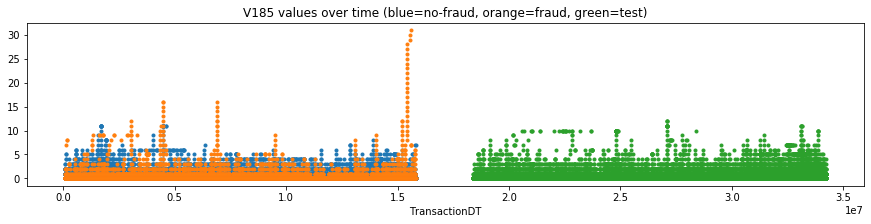

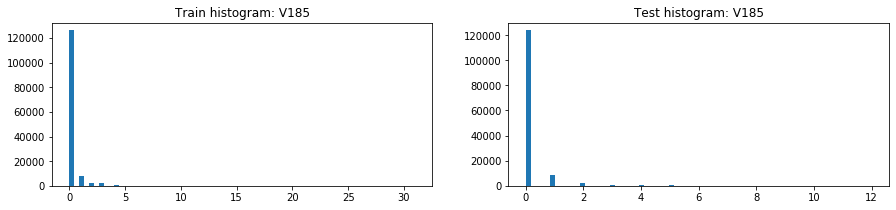

V185          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.173903      0.434598         0.151489   
2             std       0.699733      1.473350         0.582022   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      31.000000     31.000000        11.000000   
8   unique values      33.000000     33.000000        13.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.155234      0.151816       0.155747  
2        0.631667      0.607990       0.635149  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       12.000000     10.000000      12.000000  
8       14.000000     12.000000      14.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V185  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    0.0                 126057     0.069976        8821       123653.0
2    1.0                   8316     0.156445        1301         8468.0
3    2.0                   2445     0.195501         478         2426.0
4    3.0                   2237     0.092088         206          845.0
5    4.0                    391     0.237852          93          372.0
6    5.0                    142     0.366197          52          334.0
7    6.0                     80     0.225000          18           83.0
8    7.0                     33     0.575758          19           79.0
9    8.0                     26     0.538462          14           26.0

V185  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    0.0          126057     0.069976               8821         123653
2    1.0            8316     0.156445               1301           8468
3    2.0            2445     0.195501                478           2426
4    3.0            2237     0.092088                206            845
5    4.0             391     0.237852                 93            372
6    5.0             142     0.366197                 52            334
7    9.0              24     0.833333                 20             12
8    7.0              33     0.575758                 19             79
9    6.0              80     0.225000                 18             83

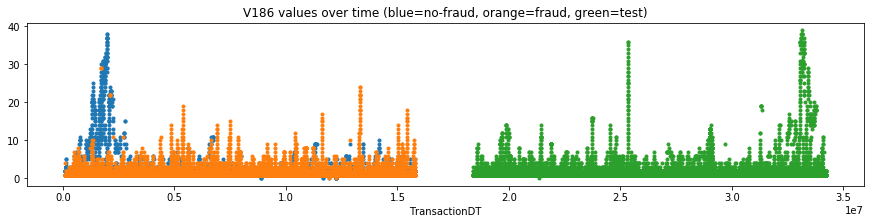

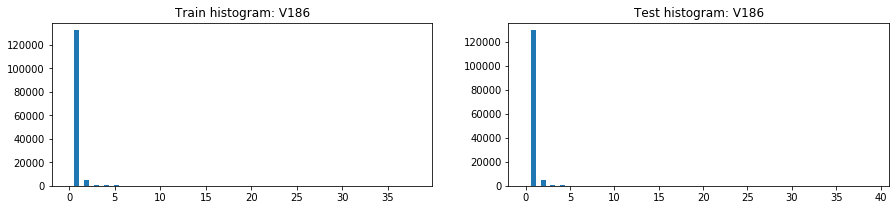

V186          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.148799      1.770631         1.095418   
2             std       1.223529      1.879338         1.134161   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      38.000000     29.000000        38.000000   
8   unique values      40.000000     27.000000        40.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.136630      1.155114       1.133835  
2        1.159961      0.783241       1.206713  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       39.000000     14.000000      39.000000  
8       41.000000     16.000000      40.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V186  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    1.0                 132235     0.057322        7580         129576
2    2.0                   4599     0.383344        1763           4727
3    3.0                   1004     0.678287         681            936
4    4.0                    499     0.751503         375            419
5    5.0                    288     0.701389         202            230
6    6.0                    189     0.645503         122            159
7    7.0                    138     0.739130         102            116
8    8.0                    102     0.627451          64             63
9    9.0                    100     0.390000          39             69

V186  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    1.0          132235     0.057322               7580         129576
2    2.0            4599     0.383344               1763           4727
3    3.0            1004     0.678287                681            936
4    4.0             499     0.751503                375            419
5    5.0             288     0.701389                202            230
6    6.0             189     0.645503                122            159
7    7.0             138     0.739130                102            116
8    8.0             102     0.627451                 64             63
9    9.0             100     0.390000                 39             69

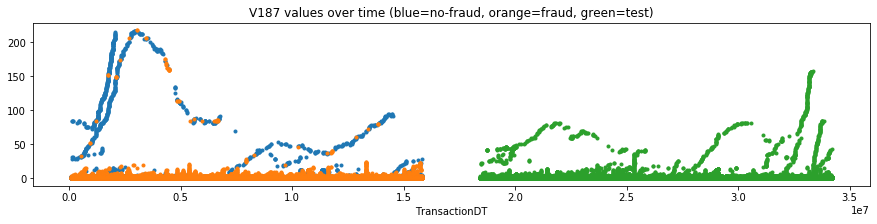

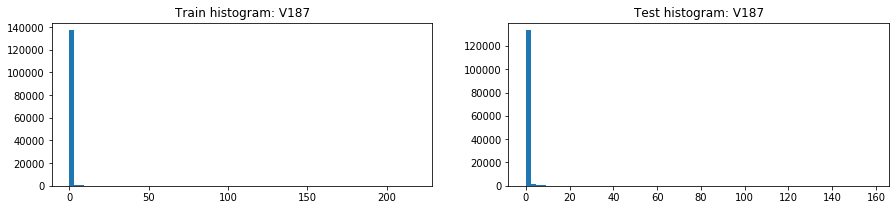

V187          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.843752      2.661111         1.773586   
2             std       9.884390      9.536890         9.910548   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max     218.000000    218.000000       217.000000   
8   unique values     216.000000     57.000000       215.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.451585      1.616781       1.426604  
2        5.054267      4.716077       5.103012  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      158.000000     81.000000     158.000000  
8      157.000000     67.000000     156.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V187  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    1.0                 130076     0.053184        6918       126930.0
2    2.0                   5812     0.322780        1876         6272.0
3    3.0                   1170     0.685470         802         1156.0
4    4.0                    520     0.876923         456          550.0
5    5.0                    276     0.887681         245          266.0
6    6.0                    177     0.898305         159          186.0
7    7.0                    169     0.964497         163          117.0
8    8.0                    107     0.869159          93           78.0
9    9.0                     72     0.805556          58           86.0

V187  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    1.0          130076     0.053184               6918         126930
2    2.0            5812     0.322780               1876           6272
3    3.0            1170     0.685470                802           1156
4    4.0             520     0.876923                456            550
5    5.0             276     0.887681                245            266
6    7.0             169     0.964497                163            117
7    6.0             177     0.898305                159            186
8    8.0             107     0.869159                 93             78
9    9.0              72     0.805556                 58             86

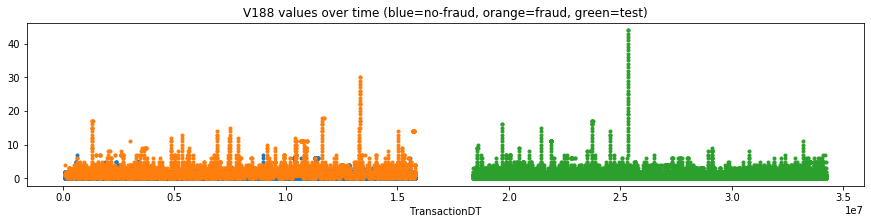

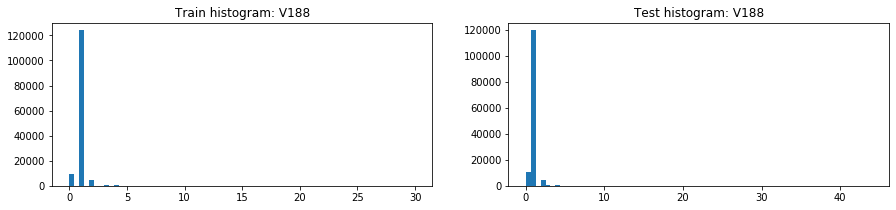

V188          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       1.014755      1.709666         0.955005   
2             std       0.671207      1.976803         0.328935   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      30.000000     30.000000         7.000000   
8   unique values      32.000000     32.000000         9.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.994823      1.016787       0.991524  
2        0.707207      0.709919       0.706743  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       44.000000     16.000000      44.000000  
8       46.000000     18.000000      46.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V188  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 123940     0.057512        7128         119626
2    0.0                   9693     0.059631         578          10930
3    2.0                   4257     0.405685        1727           4154
4    3.0                    877     0.770810         676            953
5    4.0                    377     0.936340         353            290
6    5.0                    194     0.902062         175            157
7    6.0                    158     0.708861         112             84
8    7.0                    107     0.981308         105             42
9   11.0                     44     1.000000          44             29

V188  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          123940     0.057512               7128         119626
2    2.0            4257     0.405685               1727           4154
3    3.0             877     0.770810                676            953
4    0.0            9693     0.059631                578          10930
5    4.0             377     0.936340                353            290
6    5.0             194     0.902062                175            157
7    6.0             158     0.708861                112             84
8    7.0             107     0.981308                105             42
9   11.0              44     1.000000                 44             29

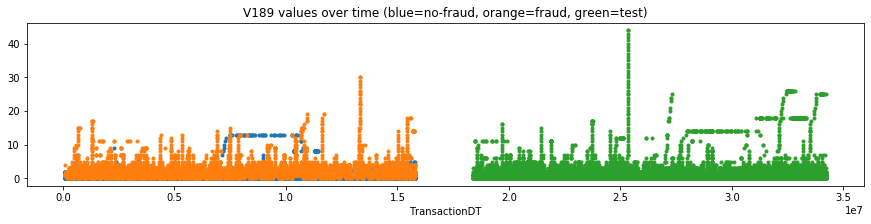

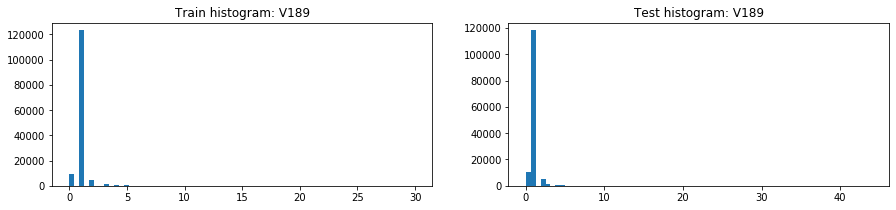

V189          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       1.038314      1.871364         0.966687   
2             std       0.792528      2.237640         0.432240   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      30.000000     30.000000        13.000000   
8   unique values      32.000000     32.000000        15.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        1.068722      1.055471       1.070713  
2        1.227535      0.839414       1.275669  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       44.000000     16.000000      44.000000  
8       46.000000     18.000000      46.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V189  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 123163     0.055349        6817         118093
2    0.0                   9579     0.058252         558          10819
3    2.0                   4656     0.368986        1718           4828
4    3.0                   1067     0.746017         796           1100
5    4.0                    442     0.918552         406            461
6    5.0                    240     0.895833         215            239
7    7.0                    134     0.977612         131             71
8    6.0                    121     0.975207         118            123
9    8.0                     96     0.531250          51             39

V189  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          123163     0.055349               6817         118093
2    2.0            4656     0.368986               1718           4828
3    3.0            1067     0.746017                796           1100
4    0.0            9579     0.058252                558          10819
5    4.0             442     0.918552                406            461
6    5.0             240     0.895833                215            239
7    7.0             134     0.977612                131             71
8    6.0             121     0.975207                118            123
9    9.0              72     0.916667                 66             29

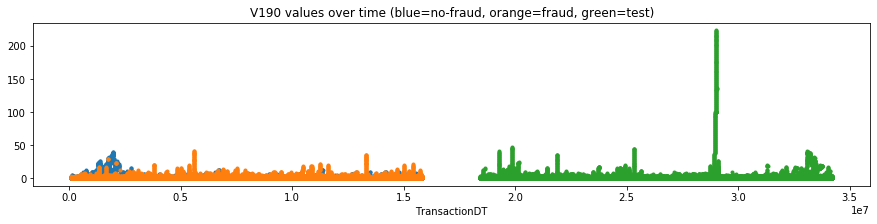

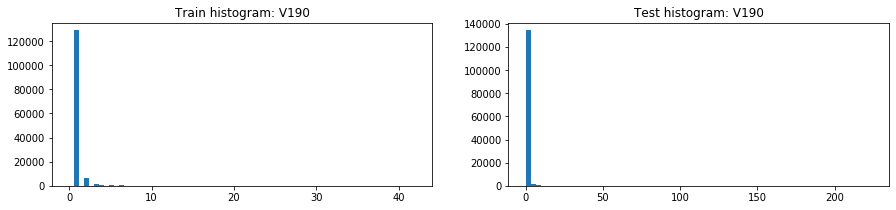

V190          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.213083      2.249570         1.124106   
2             std       1.480318      3.070257         1.212505   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      42.000000     42.000000        40.000000   
8   unique values      44.000000     44.000000        42.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.412129      1.394243       1.414833  
2        5.635017      2.197505       5.985397  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      224.000000     47.000000     224.000000  
8      226.000000     49.000000     225.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V190  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    1.0                 128846     0.052047        6706         125689
2    2.0                   6836     0.283792        1940           6940
3    3.0                   1477     0.574137         848           1640
4    4.0                    674     0.697329         470            679
5    5.0                    394     0.733503         289            355
6    6.0                    284     0.693662         197            220
7    7.0                    188     0.765957         144            162
8    8.0                    128     0.632812          81             78
9    9.0                    113     0.504425          57             71

V190  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    1.0          128846     0.052047               6706         125689
2    2.0            6836     0.283792               1940           6940
3    3.0            1477     0.574137                848           1640
4    4.0             674     0.697329                470            679
5    5.0             394     0.733503                289            355
6    6.0             284     0.693662                197            220
7    7.0             188     0.765957                144            162
8    8.0             128     0.632812                 81             78
9    9.0             113     0.504425                 57             71

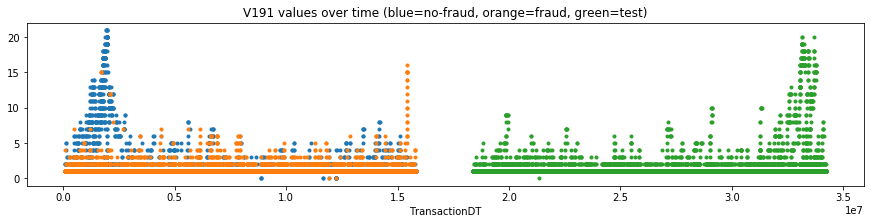

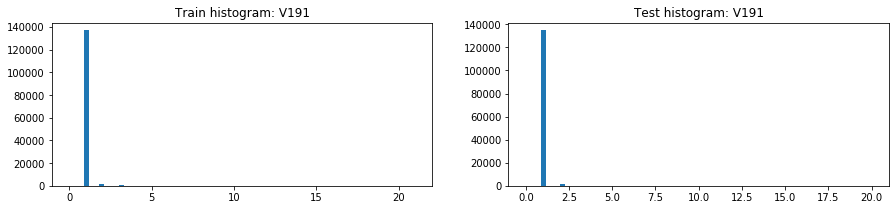

V191          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.058984      1.186611         1.048028   
2             std       0.677527      0.768301         0.668029   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      21.000000     16.000000        21.000000   
8   unique values      23.000000     18.000000        23.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.044744      1.031513       1.046745  
2        0.601974      0.300905       0.635177  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       20.000000      9.000000      20.000000  
8       22.000000     11.000000      21.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V191  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    1.0                 136888     0.071117        9735       134630.0
2    2.0                   1647     0.604129         995         1372.0
3    3.0                    288     0.562500         162          190.0
4    4.0                    152     0.375000          57          115.0
5    5.0                    108     0.296296          32           68.0
6    6.0                     83     0.301205          25           50.0
7    7.0                     69     0.101449           7           35.0
8    8.0                     60     0.050000           3           29.0
9   12.0                     49     0.102041           5           28.0

V191  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          136888     0.071117               9735         134630
1 -999.0          450909     0.021344               9624         369957
2    2.0            1647     0.604129                995           1372
3    3.0             288     0.562500                162            190
4    4.0             152     0.375000                 57            115
5    5.0             108     0.296296                 32             68
6    6.0              83     0.301205                 25             50
7   15.0              16     0.500000                  8             16
8    7.0              69     0.101449                  7             35
9   12.0              49     0.102041                  5             28

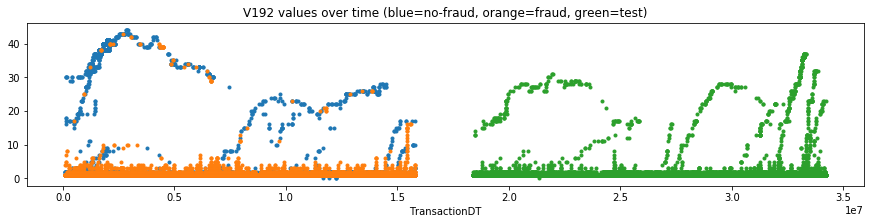

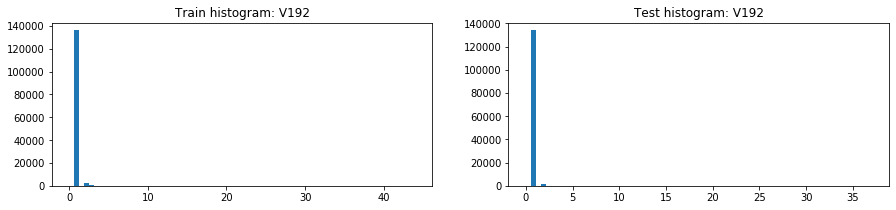

V192          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.237361      1.402392         1.223194   
2             std       2.635961      2.511878         2.645872   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      44.000000     43.000000        44.000000   
8   unique values      46.000000     34.000000        45.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.133229      1.150715       1.130585  
2        1.656252      1.657120       1.656112  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       37.000000     30.000000      37.000000  
8       39.000000     28.000000      38.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V192  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    1.0                 135994     0.069040        9389       133857.0
2    2.0                   2129     0.547205        1165         1858.0
3    3.0                    298     0.835570         249          153.0
4   40.0                    116     0.077586           9            NaN
5   38.0                    102     0.029412           3            NaN
6    4.0                     91     0.857143          78           56.0
7   34.0                     61     0.049180           3            3.0
8   33.0                     54     0.055556           3           11.0
9   41.0                     49     0.000000           0            NaN

V192  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624       369957.0
1    1.0          135994     0.069040               9389       133857.0
2    2.0            2129     0.547205               1165         1858.0
3    3.0             298     0.835570                249          153.0
4    4.0              91     0.857143                 78           56.0
5    5.0              40     0.825000                 33           39.0
6    6.0              37     0.675676                 25           29.0
7   39.0              35     0.342857                 12            NaN
8   40.0             116     0.077586                  9            NaN
9   10.0              20     0.400000                  8           13.0

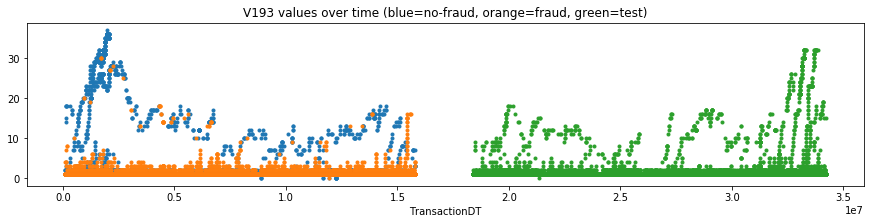

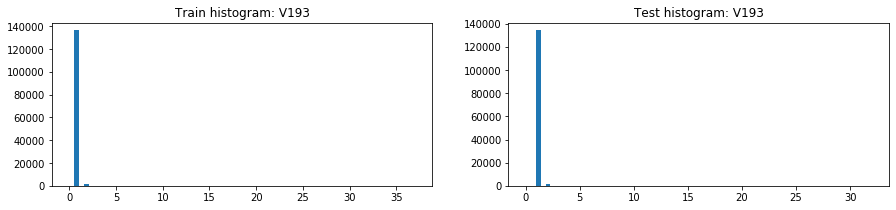

V193          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.149845      1.279011         1.138757   
2             std       1.714792      1.393129         1.739193   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      37.000000     30.000000        37.000000   
8   unique values      39.000000     26.000000        39.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.092932      1.080452       1.094820  
2        1.191230      0.836552       1.236029  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       32.000000     18.000000      32.000000  
8       34.000000     20.000000      33.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V193  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    1.0                 136424     0.070068        9559       134214.0
2    2.0                   1811     0.591938        1072         1549.0
3    3.0                    247     0.838057         207          141.0
4    4.0                     83     0.759036          63           67.0
5   14.0                     60     0.266667          16           26.0
6    7.0                     55     0.181818          10           32.0
7    5.0                     51     0.509804          26           41.0
8   29.0                     50     0.000000           0            3.0
9   12.0                     48     0.020833           1           61.0

V193  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    1.0          136424     0.070068               9559         134214
2    2.0            1811     0.591938               1072           1549
3    3.0             247     0.838057                207            141
4    4.0              83     0.759036                 63             67
5    5.0              51     0.509804                 26             41
6    6.0              41     0.512195                 21             43
7   14.0              60     0.266667                 16             26
8    7.0              55     0.181818                 10             32
9   16.0              41     0.243902                 10             56

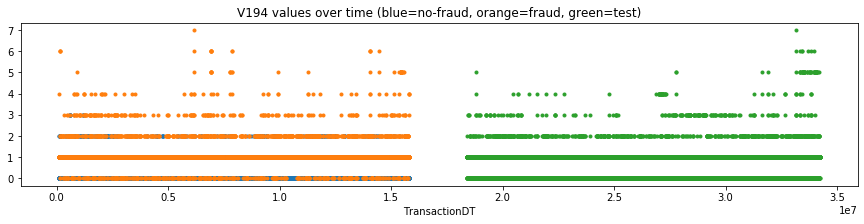

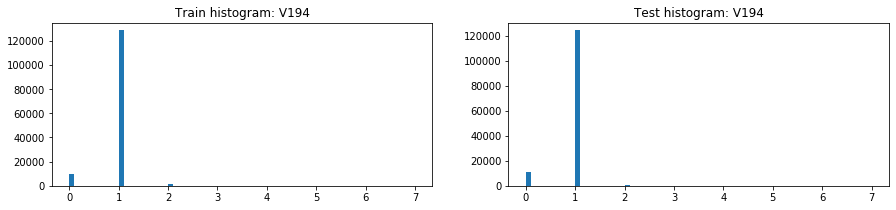

V194          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.945773      1.098464         0.932644   
2             std       0.304158      0.575392         0.264245   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      7.000000         3.000000   
8   unique values       9.000000      9.000000         5.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.932898      0.911740       0.936077  
2        0.317172      0.352361       0.311420  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      5.000000       7.000000  
8        9.000000      7.000000       9.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V194  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 128509     0.072446        9310         124191
2    0.0                   9693     0.059631         578          10930
3    2.0                   1307     0.673298         880            928
4    3.0                    201     0.960199         193            205
5    4.0                     51     1.000000          51             52
6    5.0                     42     1.000000          42             61
7    6.0                     15     1.000000          15              7
8    7.0                      1     1.000000           1              1

V194  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          128509     0.072446               9310         124191
2    2.0            1307     0.673298                880            928
3    0.0            9693     0.059631                578          10930
4    3.0             201     0.960199                193            205
5    4.0              51     1.000000                 51             52
6    5.0              42     1.000000                 42             61
7    6.0              15     1.000000                 15              7
8    7.0               1     1.000000                  1              1

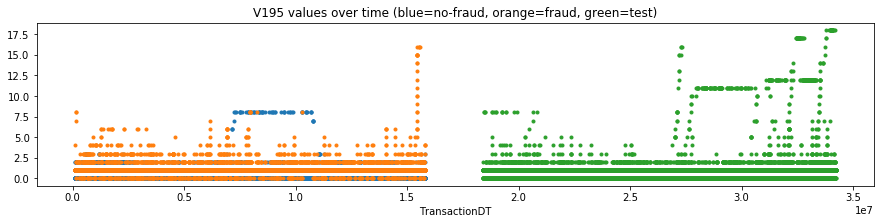

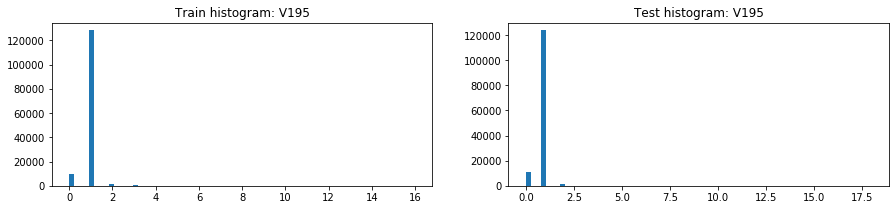

V195          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.954227      1.142999         0.937996   
2             std       0.376420      0.810015         0.306818   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      16.000000     16.000000         8.000000   
8   unique values      18.000000     18.000000         8.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.969679      0.921734       0.976882  
2        0.723563      0.428157       0.757797  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       18.000000      8.000000      18.000000  
8       20.000000     10.000000      20.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V195  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 128253     0.071562        9178         123732
2    0.0                   9579     0.058252         558          10819
3    2.0                   1535     0.627362         963           1165
4    3.0                    248     0.927419         230            118
5    8.0                     66     0.166667          11             28
6    4.0                     60     1.000000          60             46
7    6.0                     31     0.903226          28             20
8    5.0                     22     1.000000          22             32
9    7.0                      8     0.375000           3             18

V195  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          128253     0.071562               9178         123732
2    2.0            1535     0.627362                963           1165
3    0.0            9579     0.058252                558          10819
4    3.0             248     0.927419                230            118
5    4.0              60     1.000000                 60             46
6    6.0              31     0.903226                 28             20
7    5.0              22     1.000000                 22             32
8    8.0              66     0.166667                 11             28
9   15.0               5     1.000000                  5              4

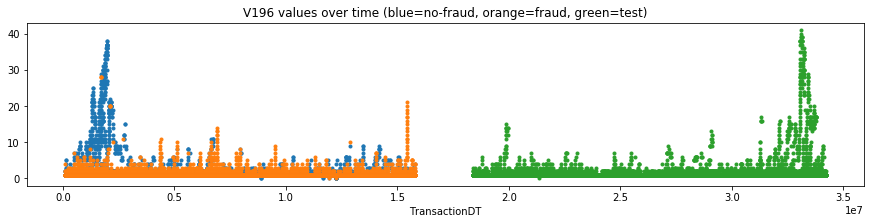

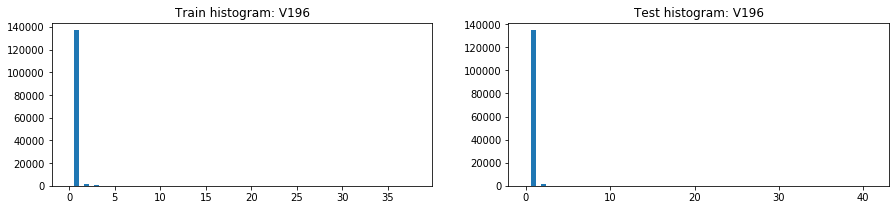

V196          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.084580      1.229006         1.072182   
2             std       1.105834      1.096746         1.105736   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      38.000000     28.000000        38.000000   
8   unique values      40.000000     24.000000        40.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.062537      1.034185       1.066825  
2        0.983359      0.414184       1.042663  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       41.000000     15.000000      41.000000  
8       43.000000     16.000000      42.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V196  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    1.0                 136911     0.072193        9884         134612
2    2.0                   1415     0.476325         674           1287
3    3.0                    335     0.656716         220            220
4    4.0                    212     0.509434         108            130
5    5.0                    118     0.415254          49             74
6    6.0                     81     0.370370          30             47
7    8.0                     60     0.200000          12             18
8    9.0                     57     0.105263           6             25
9    7.0                     51     0.372549          19             45

V196  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          136911     0.072193               9884         134612
1 -999.0          450909     0.021344               9624         369957
2    2.0            1415     0.476325                674           1287
3    3.0             335     0.656716                220            220
4    4.0             212     0.509434                108            130
5    5.0             118     0.415254                 49             74
6    6.0              81     0.370370                 30             47
7    7.0              51     0.372549                 19             45
8    8.0              60     0.200000                 12             18
9   10.0              30     0.233333                  7             16

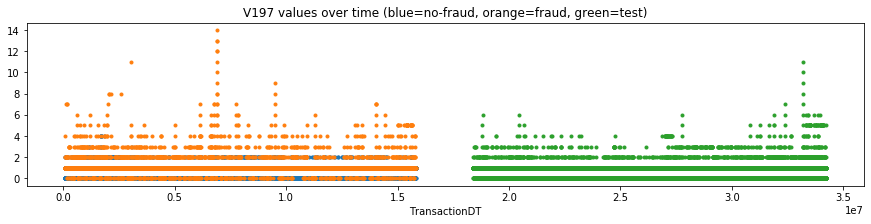

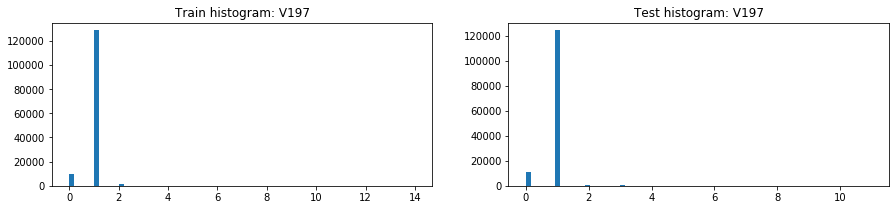

V197          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.949385      1.126287         0.934174   
2             std       0.336871      0.750550         0.268115   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      14.000000     14.000000         4.000000   
8   unique values      16.000000     16.000000         6.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.934027      0.909045       0.937780  
2        0.326384      0.355328       0.321645  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000      6.000000      11.000000  
8       13.000000      8.000000      13.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V197  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    1.0                 128419     0.073221        9403       124183.0
2    0.0                   9693     0.059631         578        10930.0
3    2.0                   1256     0.519904         653          860.0
4    3.0                    235     0.965957         227          252.0
5    4.0                    102     0.931373          95           65.0
6    5.0                     68     1.000000          68           67.0
7    6.0                     15     1.000000          15           12.0
8    7.0                     14     1.000000          14            2.0
9    8.0                      7     1.000000           7            1.0

V197  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          128419     0.073221               9403         124183
2    2.0            1256     0.519904                653            860
3    0.0            9693     0.059631                578          10930
4    3.0             235     0.965957                227            252
5    4.0             102     0.931373                 95             65
6    5.0              68     1.000000                 68             67
7    6.0              15     1.000000                 15             12
8    7.0              14     1.000000                 14              2
9    8.0               7     1.000000                  7              1

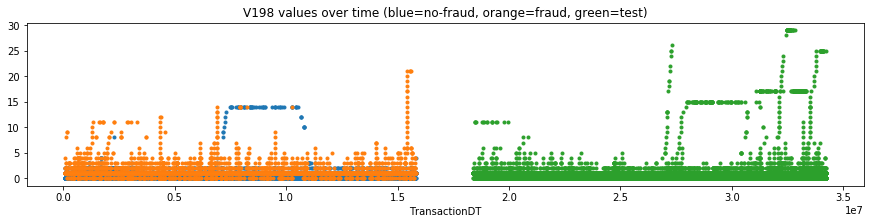

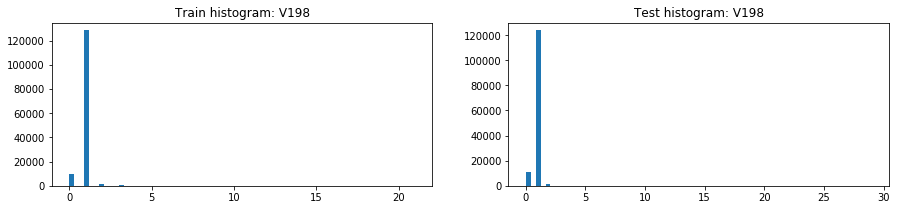

V198          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       0.961951      1.197200         0.941724   
2             std       0.493065      1.135603         0.384678   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      21.000000     21.000000        14.000000   
8   unique values      23.000000     23.000000        13.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        0.988972      0.922014       0.999030  
2        1.028947      0.486810       1.086924  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       29.000000     11.000000      29.000000  
8       30.000000     11.000000      30.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V198  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 128276     0.072632        9317         123707
2    0.0                   9579     0.058252         558          10819
3    2.0                   1318     0.484825         639           1063
4    3.0                    297     0.942761         280            191
5    4.0                    121     0.925620         112             70
6   14.0                     58     0.155172           9              8
7    5.0                     50     1.000000          50             43
8    6.0                     26     1.000000          26             20
9    8.0                     19     0.894737          17             10

V198  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          128276     0.072632               9317         123707
2    2.0            1318     0.484825                639           1063
3    0.0            9579     0.058252                558          10819
4    3.0             297     0.942761                280            191
5    4.0             121     0.925620                112             70
6    5.0              50     1.000000                 50             43
7    6.0              26     1.000000                 26             20
8    8.0              19     0.894737                 17             10
9   11.0              17     0.941176                 16             21

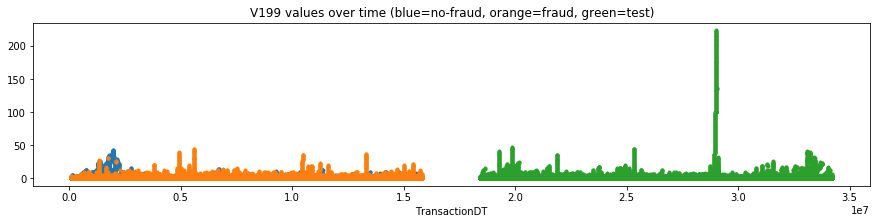

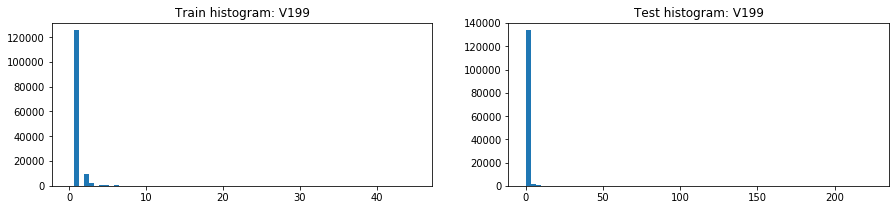

V199          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       1.270749      2.589003         1.157584   
2             std       1.671863      3.723457         1.297311   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      45.000000     45.000000        43.000000   
8   unique values      47.000000     47.000000        45.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        1.466782      1.486554       1.463792  
2        5.667169      2.350579       6.011491  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      224.000000     47.000000     224.000000  
8      226.000000     49.000000     225.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V199  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624         369957
1    1.0                 125279     0.048635        6093         122740
2    2.0                   9231     0.217636        2009           8750
3    3.0                   2119     0.470977         998           2069
4    4.0                    871     0.670494         584            876
5    5.0                    462     0.753247         348            479
6    6.0                    333     0.702703         234            323
7    7.0                    239     0.761506         182            218
8    8.0                    164     0.682927         112            137
9    9.0                    136     0.602941          82             97

V199  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    1.0          125279     0.048635               6093         122740
2    2.0            9231     0.217636               2009           8750
3    3.0            2119     0.470977                998           2069
4    4.0             871     0.670494                584            876
5    5.0             462     0.753247                348            479
6    6.0             333     0.702703                234            323
7    7.0             239     0.761506                182            218
8    8.0             164     0.682927                112            137
9    9.0             136     0.602941                 82             97

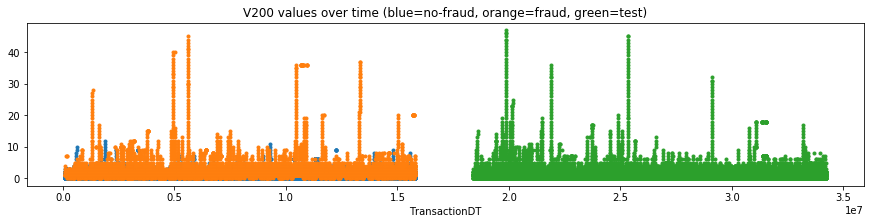

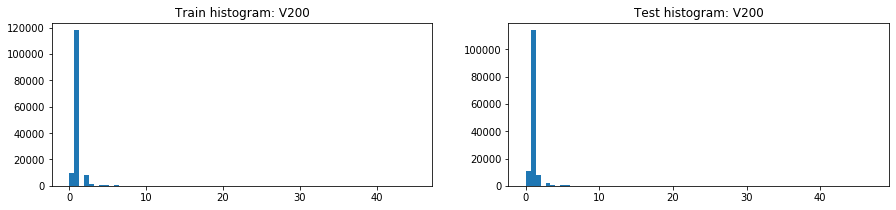

V200          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       1.119977      2.483107         1.002773   
2             std       1.253853      3.944418         0.442942   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      45.000000     45.000000        12.000000   
8   unique values      47.000000     47.000000        14.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        1.100216      1.259559       1.076279  
2        1.188545      1.962665       1.020699  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       47.000000     47.000000      45.000000  
8       49.000000     49.000000      47.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V200  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593         370316
1    1.0                 117750     0.049223        5796         113885
2    0.0                   9693     0.059631         578          10930
3    2.0                   8523     0.225273        1920           7698
4    3.0                   1723     0.568775         980           1738
5    4.0                    728     0.759615         553            838
6    5.0                    366     0.871585         319            402
7    6.0                    293     0.764505         224            225
8    7.0                    161     0.931677         150            164
9    9.0                    105     0.819048          86             73

V200  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          117750     0.049223               5796         113885
2    2.0            8523     0.225273               1920           7698
3    3.0            1723     0.568775                980           1738
4    0.0            9693     0.059631                578          10930
5    4.0             728     0.759615                553            838
6    5.0             366     0.871585                319            402
7    6.0             293     0.764505                224            225
8    7.0             161     0.931677                150            164
9    8.0             104     0.932692                 97             75

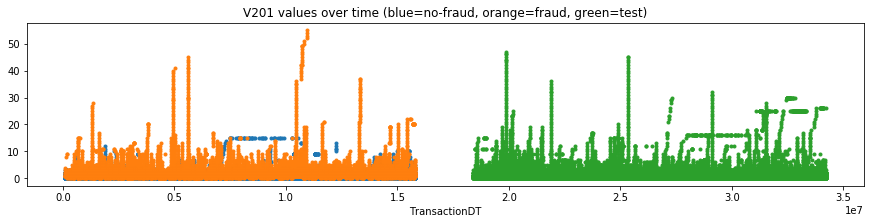

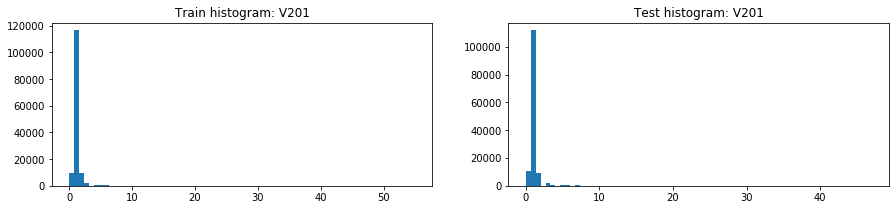

V201          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       1.159106      2.745980         1.022664   
2             std       1.418618      4.352642         0.567060   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      55.000000     55.000000        15.000000   
8   unique values      57.000000     57.000000        17.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        1.209254      1.331424       1.190901  
2        1.788458      2.090708       1.737788  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       47.000000     47.000000      45.000000  
8       49.000000     49.000000      47.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V201  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    1.0                 116412     0.047066        5479       111665.0
2    0.0                   9579     0.058252         558        10819.0
3    2.0                   9285     0.203877        1893         8882.0
4    3.0                   1922     0.519771         999         2012.0
5    4.0                    860     0.734884         632          822.0
6    5.0                    422     0.874408         369          421.0
7    6.0                    270     0.881481         238          300.0
8    7.0                    186     0.897849         167          257.0
9    9.0                    178     0.662921         118          110.0

V201  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450721     0.021284               9593         370316
1    1.0          116412     0.047066               5479         111665
2    2.0            9285     0.203877               1893           8882
3    3.0            1922     0.519771                999           2012
4    4.0             860     0.734884                632            822
5    0.0            9579     0.058252                558          10819
6    5.0             422     0.874408                369            421
7    6.0             270     0.881481                238            300
8    7.0             186     0.897849                167            257
9    8.0             134     0.925373                124            117

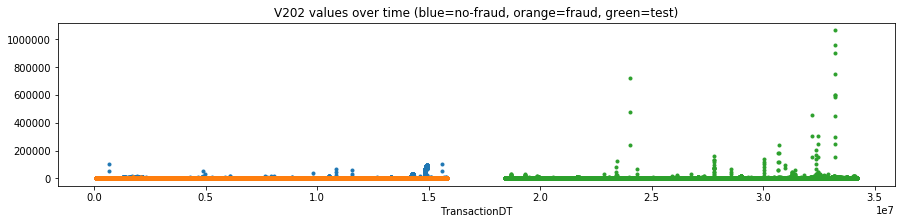

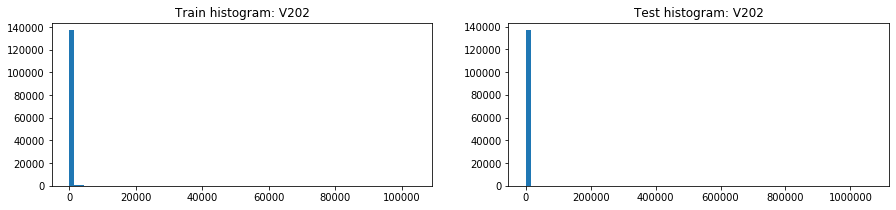

V202          Train   Train fraud  Train Not fraud          Test  \
0           count  139631.000000  11039.000000    128592.000000  1.367340e+05   
1            mean     444.147142    155.958232       468.886764  2.276923e+02   
2             std    4683.828419    403.621902      4878.506934  7.044896e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000     21.388700         0.000000  0.000000e+00   
6             75%       0.000000    150.000000         0.000000  0.000000e+00   
7             max  104060.000000  10900.000000    104060.000000  1.065496e+06   
8   unique values   10971.000000   3239.000000      9061.000000  9.564000e+03   
9            NaNs  450909.000000   9624.000000    441285.000000  3.699570e+05   
10     NaNs share       0.763600      0.465800         0.774400  7.301000e-01   

     Test public  Test private  
0   17961.000000  1.187730e+05  
1     157.234658  2.383470e+02  
2     993.251845  7.548892e+03  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      26.436399  0.000000e+00  
7   33360.000000  1.065496e+06  
8    2512.000000  8.286000e+03  
9   83378.000000  2.865800e+05  
10      0.822800  7.070000e-01

V202  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 106161     0.047786        5073       103369.0
2  100.0                   2186     0.068161         149         1549.0
3  200.0                   1500     0.108000         162         1310.0
4   50.0                   1391     0.066139          92          861.0
5  150.0                   1256     0.149682         188          867.0
6  300.0                   1046     0.176864         185          838.0
7  400.0                    589     0.139219          82          758.0
8   25.0                    530     0.041509          22          383.0
9  250.0                    477     0.100629          48          468.0

V202  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          106161     0.047786               5073         103369
2  150.0            1256     0.149682                188            867
3  300.0            1046     0.176864                185            838
4  200.0            1500     0.108000                162           1310
5  100.0            2186     0.068161                149           1549
6  600.0             456     0.214912                 98            446
7   50.0            1391     0.066139                 92            861
8  400.0             589     0.139219                 82            758
9  450.0             272     0.294118                 80            164

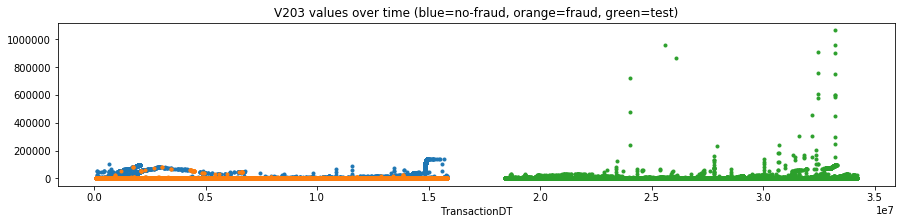

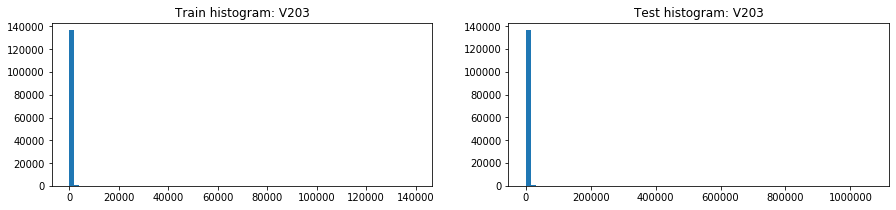

V203          Train   Train fraud  Train Not fraud          Test  \
0           count  139631.000000  11039.000000    128592.000000  1.367340e+05   
1            mean    1078.327538    458.577578      1131.530069  4.566458e+02   
2             std    9105.607991   3581.819720      9428.292395  9.358593e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000     47.585400         0.000000  0.000000e+00   
6             75%      30.924400    237.288399        19.757299  3.135480e+01   
7             max  139777.000000  81450.000000    139777.000000  1.065496e+06   
8   unique values   14952.000000   3960.000000     12478.000000  1.394100e+04   
9            NaNs  450909.000000   9624.000000    441285.000000  3.699570e+05   
10     NaNs share       0.763600      0.465800         0.774400  7.301000e-01   

     Test public  Test private  
0   17961.000000  1.187730e+05  
1     334.202050  4.751619e+02  
2    1967.238810  1.001199e+04  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      70.333099  2.742010e+01  
7   33360.000000  1.065496e+06  
8    3449.000000  1.208100e+04  
9   83378.000000  2.865800e+05  
10      0.822800  7.070000e-01

V203  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                  98207     0.044559        4376        93950.0
2  100.0                   2372     0.061130         145         1751.0
3  200.0                   1580     0.093038         147         1420.0
4   50.0                   1553     0.056665          88         1036.0
5  150.0                   1341     0.130500         175          935.0
6  300.0                   1104     0.165761         183          864.0
7  400.0                    646     0.153251          99          751.0
8   25.0                    593     0.032040          19          443.0
9   75.0                    541     0.053604          29          391.0

V203  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0           98207     0.044559               4376          93950
2  300.0            1104     0.165761                183            864
3  150.0            1341     0.130500                175            935
4  200.0            1580     0.093038                147           1420
5  100.0            2372     0.061130                145           1751
6  400.0             646     0.153251                 99            751
7  600.0             503     0.196819                 99            468
8   50.0            1553     0.056665                 88           1036
9  450.0             273     0.271062                 74            171

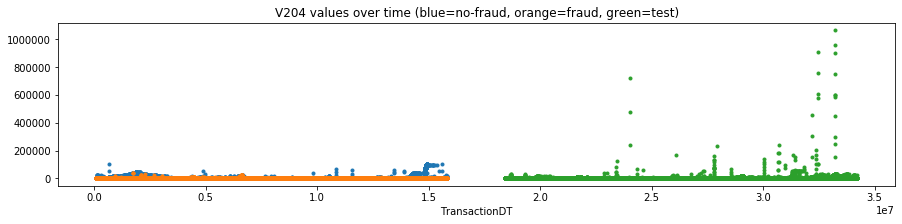

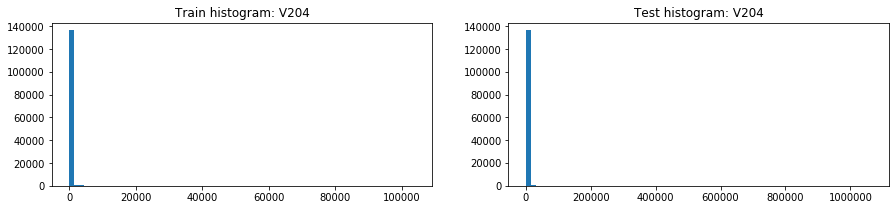

V204          Train   Train fraud  Train Not fraud          Test  \
0           count  139631.000000  11039.000000    128592.000000  1.367340e+05   
1            mean     686.956931    258.607617       723.728644  3.153237e+02   
2             std    6048.980716   1227.476243      6291.648851  8.145386e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000     38.011600         0.000000  0.000000e+00   
6             75%      20.000000    200.000000         0.000000  1.955060e+01   
7             max  104060.000000  37850.000000    104060.000000  1.065496e+06   
8   unique values   12859.000000   3708.000000     10581.000000  1.181900e+04   
9            NaNs  450909.000000   9624.000000    441285.000000  3.699570e+05   
10     NaNs share       0.763600      0.465800         0.774400  7.301000e-01   

     Test public  Test private  
0   17961.000000  1.187730e+05  
1     206.750770  3.317422e+02  
2    1173.023387  8.727566e+03  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      50.000000  1.530910e+01  
7   33360.000000  1.065496e+06  
8    3000.000000  1.024100e+04  
9   83378.000000  2.865800e+05  
10      0.822800  7.070000e-01

V204  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 101660     0.044806        4555        98083.0
2  100.0                   2289     0.063783         146         1654.0
3  200.0                   1541     0.099935         154         1342.0
4   50.0                   1507     0.062376          94          987.0
5  150.0                   1306     0.141654         185          889.0
6  300.0                   1078     0.174397         188          856.0
7  400.0                    626     0.154952          97          738.0
8   25.0                    599     0.036728          22          454.0
9   75.0                    523     0.074570          39          365.0

V204  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          101660     0.044806               4555          98083
2  300.0            1078     0.174397                188            856
3  150.0            1306     0.141654                185            889
4  200.0            1541     0.099935                154           1342
5  100.0            2289     0.063783                146           1654
6  600.0             484     0.202479                 98            452
7  400.0             626     0.154952                 97            738
8   50.0            1507     0.062376                 94            987
9  450.0             265     0.279245                 74            164

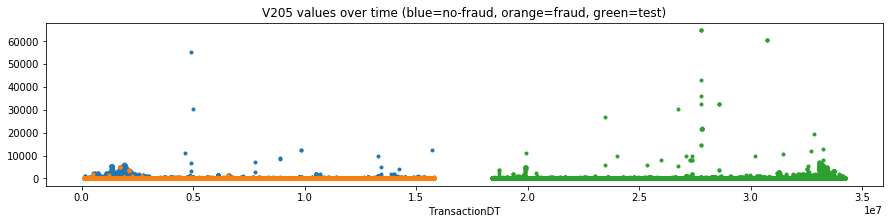

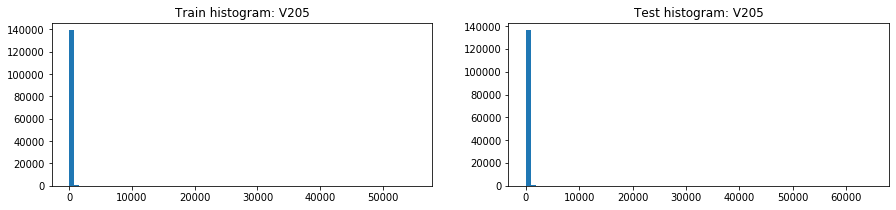

V205          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean      18.060417      9.057890        18.833240   
2             std     266.545451    116.047755       275.648287   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   5050.000000     55125.000000   
8   unique values    2241.000000    212.000000      2167.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1       21.513360     11.243137      23.066436  
2      552.490919    159.881073     589.510495  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  11000.000000   64800.000000  
8     1980.000000    438.000000    1817.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V205  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 128800     0.079604       10253       126250.0
2  100.0                    598     0.043478          26          341.0
3   50.0                    370     0.075676          28          280.0
4  150.0                    218     0.178899          39          157.0
5   25.0                    205     0.068293          14          182.0
6  265.0                    187     0.000000           0            NaN
7  106.0                    166     0.000000           0            NaN
8   20.0                    163     0.012270           2          143.0
9  200.0                    147     0.156463          23          183.0

V205  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          128800     0.079604              10253       126250.0
1 -999.000000          450909     0.021344               9624       369957.0
2  150.000000             218     0.178899                 39          157.0
3   50.000000             370     0.075676                 28          280.0
4  100.000000             598     0.043478                 26          341.0
5  200.000000             147     0.156463                 23          183.0
6   44.106602              26     0.730769                 19            NaN
7   86.317902              18     1.000000                 18            NaN
8    8.914600              19     0.947368                 18           19.0
9   40.179298              15     1.000000                 15            NaN

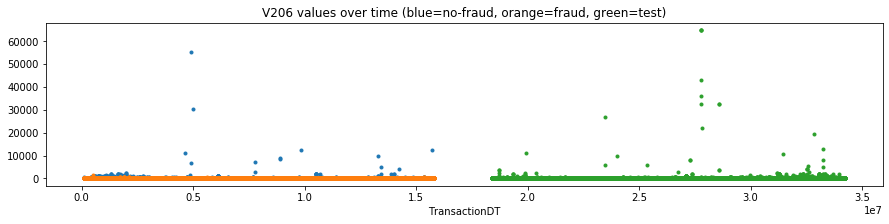

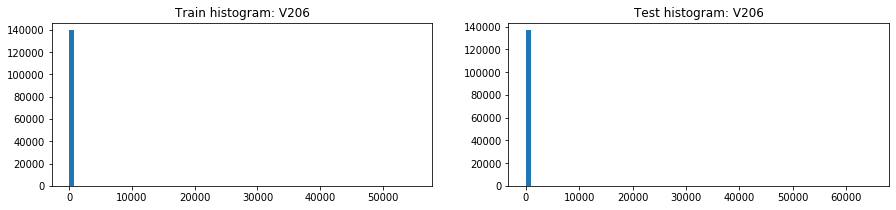

V206          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean       6.189360      2.467472         6.508866   
2             std     191.474014     25.255635       199.382949   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   1350.000000     55125.000000   
8   unique values    1781.000000    139.000000      1735.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1        9.213510      4.958772       9.856917  
2      399.602565    104.704310     426.812422  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  11000.000000   64800.000000  
8     1563.000000    339.000000    1422.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V206  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 450909     0.021344        9624       369957.0
1     0.0                 132868     0.080238       10661       129946.0
2   100.0                    288     0.031250           9          254.0
3    50.0                    253     0.043478          11          188.0
4   150.0                    171     0.111111          19          111.0
5    25.0                    120     0.075000           9          103.0
6   200.0                    112     0.026786           3          137.0
7   300.0                     69     0.043478           3           56.0
8   250.0                     69     0.014493           1           61.0
9  1000.0                     67     0.000000           0           39.0

V206  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          132868     0.080238              10661       129946.0
1 -999.000000          450909     0.021344               9624       369957.0
2  150.000000             171     0.111111                 19          111.0
3   44.106602              24     0.791667                 19            NaN
4   12.809000              18     0.833333                 15            NaN
5   50.000000             253     0.043478                 11          188.0
6   17.337400              14     0.785714                 11           10.0
7  125.000000              56     0.178571                 10           21.0
8  100.000000             288     0.031250                  9          254.0
9   25.000000             120     0.075000                  9          103.0

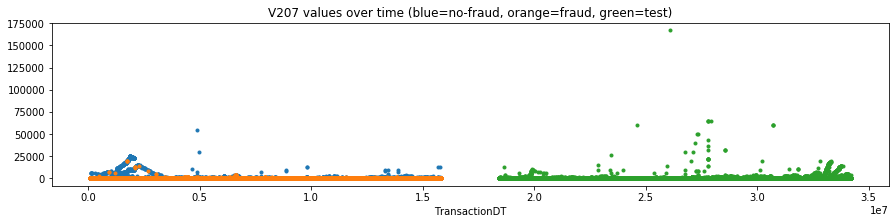

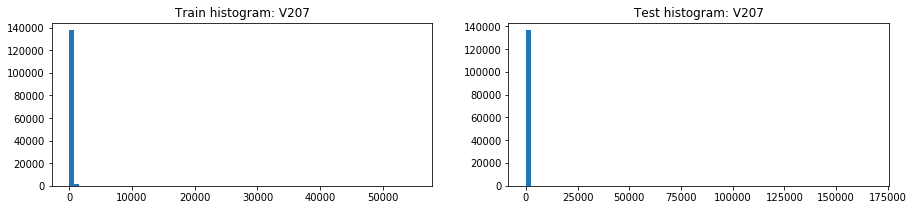

V207          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean      72.284098     33.052247        75.651962   
2             std     925.676660    476.216252       954.372372   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000  20075.000000     55125.000000   
8   unique values    3247.000000    316.000000      3148.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1       46.936743     30.227660      49.463511  
2      907.342401    336.006781     964.700194  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   167200.000000  12500.000000  167200.000000  
8     2892.000000    712.000000    2644.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V207  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 123086     0.078839        9704       119700.0
2  877.0                    914     0.000000           0            NaN
3   50.0                    552     0.085145          47          437.0
4  100.0                    483     0.055901          27          467.0
5  619.0                    342     0.000000           0            NaN
6   25.0                    318     0.088050          28          276.0
7  150.0                    253     0.166008          42          203.0
8   20.0                    235     0.021277           5          194.0
9   30.0                    209     0.062201          13          163.0

V207  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          123086     0.078839               9704       119700.0
1 -999.000000          450909     0.021344               9624       369957.0
2   50.000000             552     0.085145                 47          437.0
3   25.452700              46     0.934783                 43           13.0
4  150.000000             253     0.166008                 42          203.0
5  300.000000             134     0.261194                 35          127.0
6   25.000000             318     0.088050                 28          276.0
7  100.000000             483     0.055901                 27          467.0
8  200.000000             189     0.132275                 25          268.0
9   40.179298              23     1.000000                 23            NaN

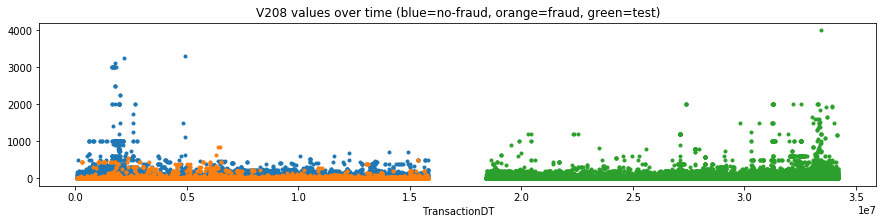

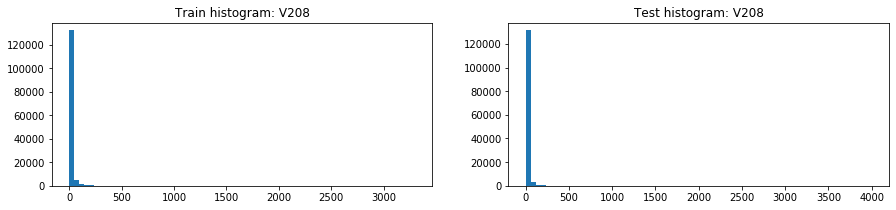

V208          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean       8.888193     10.730773         8.729766   
2             std      59.047125     46.177884        60.022465   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    3300.000000    835.000000      3300.000000   
8   unique values    2553.000000    248.000000      2483.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1        9.031152      6.969635       9.340839  
2       59.632571     36.444726      62.369809  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7     4000.000000   1200.000000    4000.000000  
8     2100.000000    497.000000    1933.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V208  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    0.0                 123863     0.077279        9572       119736.0
2   75.0                   1461     0.000000           0          160.0
3   50.0                    716     0.064246          46          579.0
4  100.0                    553     0.057866          32          604.0
5   25.0                    360     0.069444          25          473.0
6   20.0                    309     0.110032          34          163.0
7  150.0                    262     0.152672          40          257.0
8  200.0                    245     0.257143          63          243.0
9   15.0                    213     0.262911          56          129.0

V208  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0000          450721     0.021284               9593         370316
1    0.0000          123863     0.077279               9572         119736
2  200.0000             245     0.257143                 63            243
3   15.0000             213     0.262911                 56            129
4   25.4527              49     0.959184                 47             16
5   50.0000             716     0.064246                 46            579
6  150.0000             262     0.152672                 40            257
7   20.0000             309     0.110032                 34            163
8  450.0000              44     0.750000                 33             30
9    8.9146              36     0.916667                 33             18

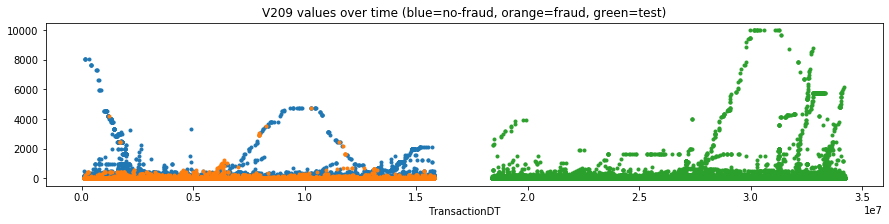

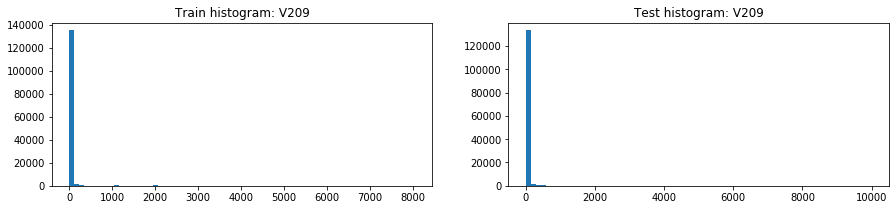

V209          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean      35.001872     18.897558        36.386541   
2             std     250.800822    127.469431       258.627612   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    8050.000000   4725.000000      8050.000000   
8   unique values    3452.000000    341.000000      3354.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1       28.002020     13.777167      30.138916  
2      305.990127    110.322738     325.318560  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    10000.000000   3925.000000   10000.000000  
8     3244.000000    700.000000    2984.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V209  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 450721     0.021284        9593       370316.0
1     0.0                 122714     0.077351        9492       118423.0
2  1961.0                    921     0.000000           0            NaN
3    50.0                    589     0.062818          37          528.0
4   100.0                    501     0.049900          25          507.0
5  1084.0                    339     0.000000           0            NaN
6    25.0                    305     0.052459          16          269.0
7   150.0                    285     0.143860          41          243.0
8   200.0                    271     0.239852          65          239.0
9    75.0                    166     0.018072           3          150.0

V209  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0000          450721     0.021284               9593         370316
1    0.0000          122714     0.077351               9492         118423
2  200.0000             271     0.239852                 65            239
3   25.4527              50     0.940000                 47             12
4  150.0000             285     0.143860                 41            243
5   50.0000             589     0.062818                 37            528
6  300.0000             148     0.243243                 36            117
7  450.0000              51     0.666667                 34             47
8    8.9146              35     0.942857                 33             19
9  100.0000             501     0.049900                 25            507

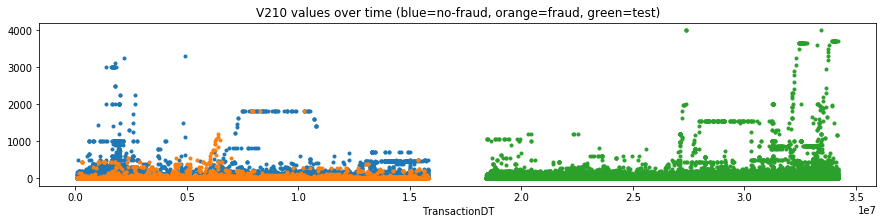

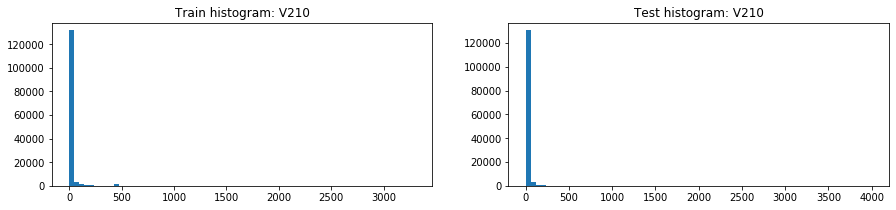

V210          Train   Train fraud  Train Not fraud  \
0           count  139819.000000  11070.000000    128749.000000   
1            mean      14.391835     14.199290        14.408390   
2             std      86.523724     73.466863        87.555739   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    3300.000000   1825.000000      3300.000000   
8   unique values    2837.000000    290.000000      2746.000000   
9            NaNs  450721.000000   9593.000000    441128.000000   
10     NaNs share       0.763200      0.464300         0.774100   

             Test   Test public   Test private  
0   136375.000000  17811.000000  118564.000000  
1       14.891453      8.842171      15.800192  
2      121.947914     51.011022     129.259876  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7     4000.000000   1200.000000    4000.000000  
8     2479.000000    563.000000    2282.000000  
9   370316.000000  83528.000000  286789.000000  
10       0.730900      0.824200       0.707500

V210  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450721     0.021284        9593       370316.0
1    0.0                 123575     0.077103        9528       119191.0
2  465.0                   1340     0.000000           0            NaN
3   50.0                    654     0.070336          46          573.0
4  100.0                    560     0.085714          48          506.0
5   25.0                    325     0.049231          16          349.0
6  150.0                    283     0.134276          38          231.0
7  200.0                    277     0.220217          61          230.0
8   20.0                    179     0.089385          16          134.0
9   75.0                    175     0.005714           1          173.0

V210  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0000          450721     0.021284               9593         370316
1    0.0000          123575     0.077103               9528         119191
2  200.0000             277     0.220217                 61            230
3  100.0000             560     0.085714                 48            506
4   25.4527              49     0.959184                 47             16
5   50.0000             654     0.070336                 46            573
6  150.0000             283     0.134276                 38            231
7  300.0000             120     0.300000                 36            113
8  450.0000              48     0.708333                 34             50
9    8.9146              35     0.942857                 33             19

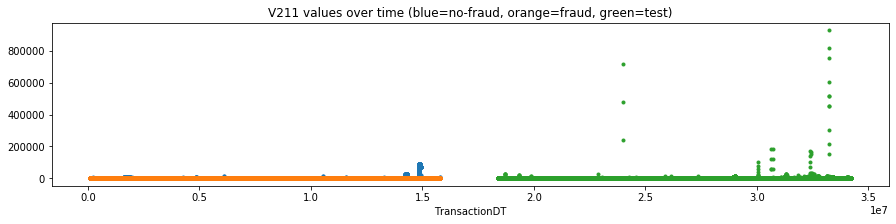

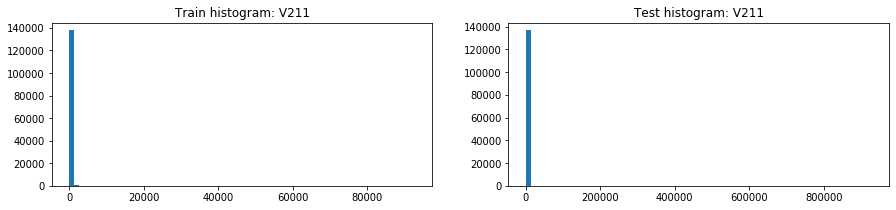

V211          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean     385.137037     97.236561       409.851898   
2             std    4541.837915    261.397582      4731.337313   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     86.883999         0.000000   
7             max   92888.000000   5450.000000     92888.000000   
8   unique values    7625.000000   2752.000000      5755.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1      138.294487     77.946879     147.420327  
2     5847.832059    678.599433    6268.831585  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  26400.000000  928882.000000  
8     6541.000000   1775.000000    5537.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V211  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 120997     0.053001        6413       119067.0
2  100.0                    981     0.111111         109          532.0
3  200.0                    681     0.174743         119          512.0
4  150.0                    642     0.196262         126          373.0
5   50.0                    633     0.083728          53          312.0
6  300.0                    557     0.220826         123          304.0
7   75.0                    244     0.122951          30          125.0
8  400.0                    236     0.216102          51          256.0
9  600.0                    212     0.202830          43          181.0

V211  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          120997     0.053001               6413         119067
2  150.0             642     0.196262                126            373
3  300.0             557     0.220826                123            304
4  200.0             681     0.174743                119            512
5  100.0             981     0.111111                109            532
6   50.0             633     0.083728                 53            312
7  400.0             236     0.216102                 51            256
8  450.0             146     0.315068                 46             67
9  600.0             212     0.202830                 43            181

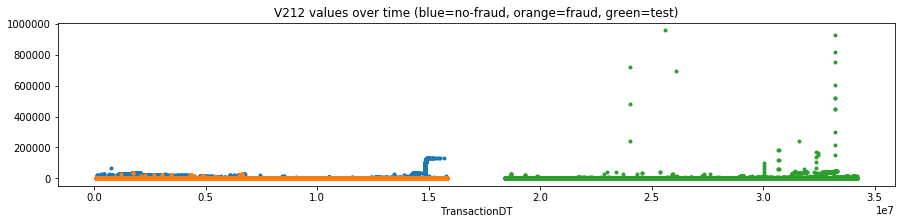

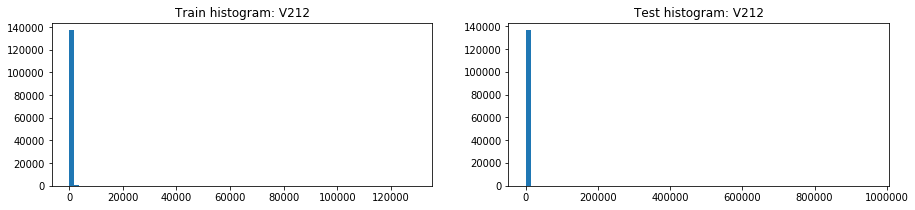

V212          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean     765.988339    225.179319       812.414172   
2             std    7496.120737   1385.125382      7798.955699   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    141.404007         0.000000   
7             max  129006.000000  34625.000000    129006.000000   
8   unique values    8869.000000   3245.000000      6518.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1      237.507053    119.402121     255.367027  
2     6889.655730    771.873713    7385.998157  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   958320.000000  26400.000000  958320.000000  
8     7977.000000   2095.000000    6745.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V212  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 118836     0.049943        5935       116464.0
2  100.0                    965     0.117098         113          570.0
3  200.0                    674     0.181009         122          501.0
4  150.0                    658     0.205167         135          385.0
5   50.0                    643     0.080871          52          363.0
6  300.0                    554     0.236462         131          299.0
7  400.0                    263     0.205323          54          264.0
8   75.0                    231     0.082251          19          147.0
9   25.0                    224     0.084821          19          110.0

V212  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          118836     0.049943               5935         116464
2  150.0             658     0.205167                135            385
3  300.0             554     0.236462                131            299
4  200.0             674     0.181009                122            501
5  100.0             965     0.117098                113            570
6  400.0             263     0.205323                 54            264
7   50.0             643     0.080871                 52            363
8  450.0             147     0.333333                 49             73
9  250.0             173     0.236994                 41            129

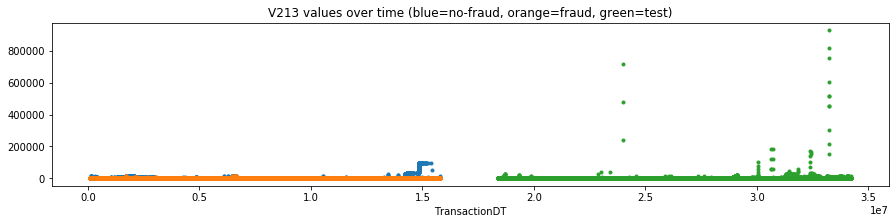

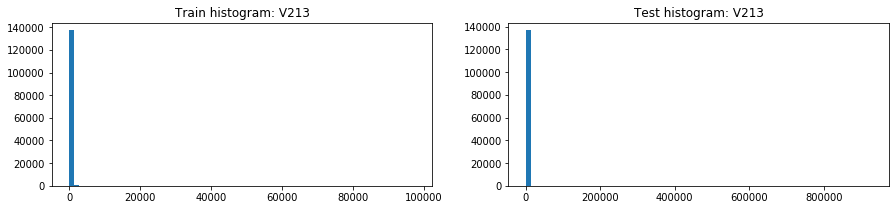

V213          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean     536.302802    151.573946       569.329910   
2             std    5471.664736    647.084991      5697.325996   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    119.103798         0.000000   
7             max   97628.000000  16950.000000     97628.000000   
8   unique values    8318.000000   3079.000000      6141.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1      165.117391     91.327816     176.275942  
2     5880.191811    697.521050    6303.245630  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  26400.000000  928882.000000  
8     7441.000000   1975.000000    6280.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V213  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 450909     0.021344        9624       369957.0
1    0.0                 119688     0.050732        6072       117611.0
2  100.0                    960     0.114583         110          558.0
3  200.0                    684     0.185673         127          498.0
4  150.0                    650     0.204615         133          386.0
5   50.0                    633     0.080569          51          337.0
6  300.0                    561     0.221034         124          337.0
7  400.0                    265     0.207547          55          263.0
8   75.0                    234     0.085470          20          130.0
9  600.0                    214     0.182243          39          232.0

V213  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          119688     0.050732               6072         117611
2  150.0             650     0.204615                133            386
3  200.0             684     0.185673                127            498
4  300.0             561     0.221034                124            337
5  100.0             960     0.114583                110            558
6  400.0             265     0.207547                 55            263
7   50.0             633     0.080569                 51            337
8  450.0             155     0.322581                 50             81
9  250.0             176     0.244318                 43            134

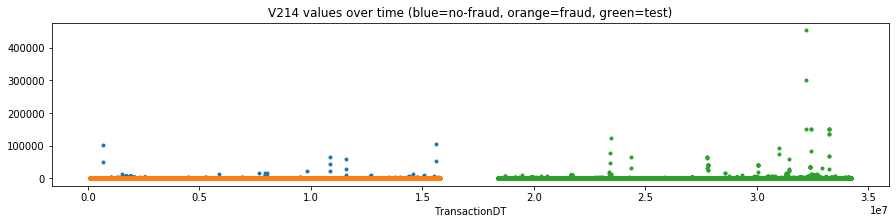

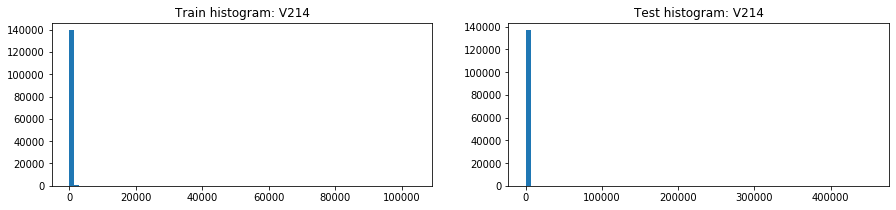

V214          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean      38.437547     47.904827        37.624827   
2             std     571.834283    198.676843       593.016828   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   4500.000000    104060.000000   
8   unique values    2283.000000    479.000000      2050.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1       63.859337     60.051108      64.435222  
2     2079.078198    499.382928    2222.278709  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   453750.000000  10950.000000  453750.000000  
8     2045.000000    508.000000    1823.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V214  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 450909     0.021344        9624       369957.0
1     0.0                 125518     0.071249        8943       123637.0
2   100.0                   1303     0.080583         105         1002.0
3   200.0                    930     0.119355         111          908.0
4  1165.0                    862     0.000000           0            NaN
5   150.0                    689     0.171263         118          530.0
6   300.0                    650     0.213846         139          561.0
7    50.0                    643     0.111975          72          491.0
8   400.0                    398     0.158291          63          516.0
9   250.0                    346     0.078035          27          391.0

V214  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          125518     0.071249               8943         123637
2  300.0             650     0.213846                139            561
3  150.0             689     0.171263                118            530
4  200.0             930     0.119355                111            908
5  100.0            1303     0.080583                105           1002
6   50.0             643     0.111975                 72            491
7  400.0             398     0.158291                 63            516
8  600.0             289     0.204152                 59            287
9  450.0             173     0.306358                 53            100

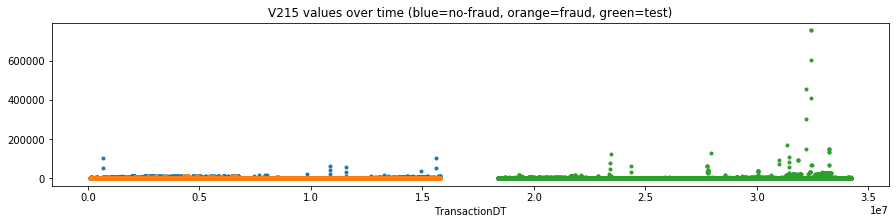

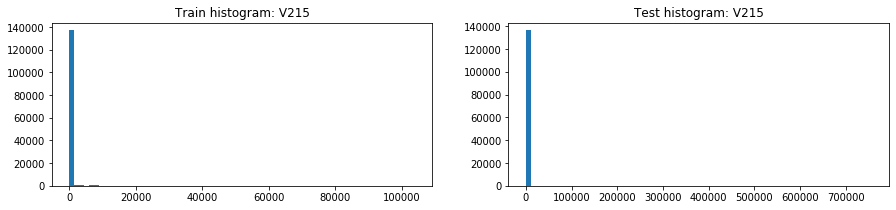

V215          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean     133.208217    116.159801       134.671741   
2             std    1040.453748    785.388033      1059.481445   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000  13725.000000    104060.000000   
8   unique values    2748.000000    568.000000      2480.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1      137.666738    119.382932     140.431638  
2     4229.761774    866.771767    4525.784443  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   756250.000000  19200.000000  756250.000000  
8     2509.000000    651.000000    2164.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V215  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 450909     0.021344        9624       369957.0
1     0.0                 123142     0.069570        8567       121029.0
2   100.0                   1330     0.087970         117         1036.0
3   200.0                    939     0.120341         113          885.0
4  6428.0                    863     0.000000           0            NaN
5    50.0                    720     0.104167          75          509.0
6   150.0                    703     0.170697         120          522.0
7   300.0                    647     0.217929         141          545.0
8   400.0                    346     0.193642          67          510.0
9   250.0                    322     0.086957          28          387.0

V215  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          123142     0.069570               8567         121029
2  300.0             647     0.217929                141            545
3  150.0             703     0.170697                120            522
4  100.0            1330     0.087970                117           1036
5  200.0             939     0.120341                113            885
6   50.0             720     0.104167                 75            509
7  600.0             286     0.241259                 69            296
8  400.0             346     0.193642                 67            510
9  450.0             167     0.311377                 52            111

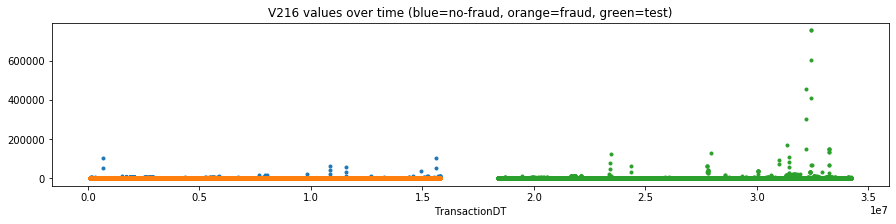

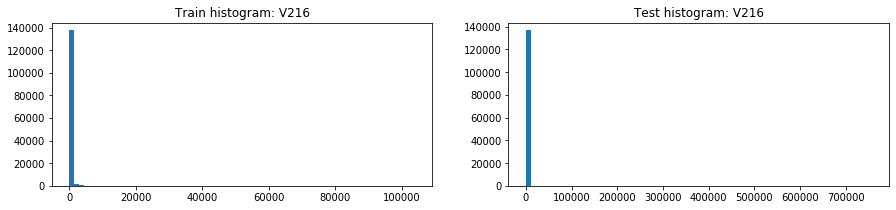

V216          Train   Train fraud  Train Not fraud  \
0           count  139631.000000  11039.000000    128592.000000   
1            mean      71.107143     69.686454        71.229102   
2             std     680.267625    306.143918       703.167916   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   6100.000000    104060.000000   
8   unique values    2533.000000    530.000000      2281.000000   
9            NaNs  450909.000000   9624.000000    441285.000000   
10     NaNs share       0.763600      0.465800         0.774400   

             Test   Test public   Test private  
0   136734.000000  17961.000000  118773.000000  
1       98.227713     72.224114     102.160010  
2     4107.166269    529.610903    4401.957276  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   756250.000000  10950.000000  756250.000000  
8     2252.000000    554.000000    2001.000000  
9   369957.000000  83378.000000  286580.000000  
10       0.730100      0.822800       0.707000

V216  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 450909     0.021344        9624       369957.0
1     0.0                 124108     0.070028        8691       122245.0
2   100.0                   1307     0.086458         113         1012.0
3   200.0                    942     0.121019         114          885.0
4   150.0                    695     0.171223         119          517.0
5    50.0                    679     0.113402          77          507.0
6   300.0                    640     0.225000         144          575.0
7  2932.0                    606     0.000000           0            NaN
8   400.0                    366     0.191257          70          504.0
9   250.0                    317     0.082019          26          387.0

V216  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          450909     0.021344               9624         369957
1    0.0          124108     0.070028               8691         122245
2  300.0             640     0.225000                144            575
3  150.0             695     0.171223                119            517
4  200.0             942     0.121019                114            885
5  100.0            1307     0.086458                113           1012
6   50.0             679     0.113402                 77            507
7  400.0             366     0.191257                 70            504
8  600.0             279     0.207885                 58            306
9  450.0             176     0.312500                 55            126

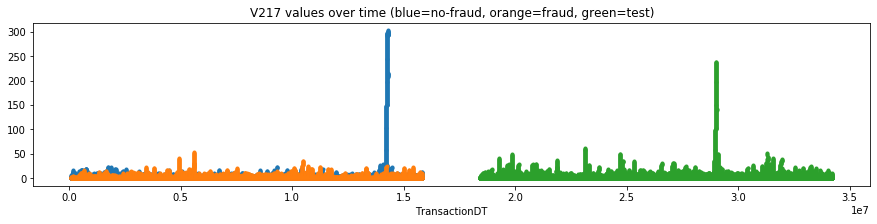

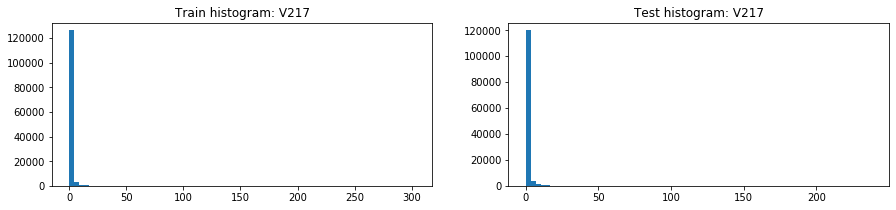

V217          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.054619      2.556024         0.927352   
2             std       9.547354      4.503774         9.846424   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      3.000000         0.000000   
7             max     303.000000     53.000000       303.000000   
8   unique values     305.000000     55.000000       305.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.987217      1.133670       0.965415  
2        6.486470      3.252485       6.838085  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       0.000000  
7      238.000000     49.000000     238.000000  
8      240.000000     51.000000     240.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V217  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                  98285     0.040179        3949        94140.0
2    1.0                  15372     0.132123        2031        15388.0
3    2.0                   6761     0.177636        1201         6599.0
4    3.0                   3552     0.219032         778         3534.0
5    4.0                   2068     0.262573         543         2072.0
6    5.0                   1083     0.311173         337         1171.0
7    6.0                    727     0.356259         259          763.0
8    7.0                    513     0.393762         202          522.0
9    8.0                    371     0.431267         160          400.0

V217  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0           98285     0.040179               3949          94140
2    1.0           15372     0.132123               2031          15388
3    2.0            6761     0.177636               1201           6599
4    3.0            3552     0.219032                778           3534
5    4.0            2068     0.262573                543           2072
6    5.0            1083     0.311173                337           1171
7    6.0             727     0.356259                259            763
8    7.0             513     0.393762                202            522
9    8.0             371     0.431267                160            400

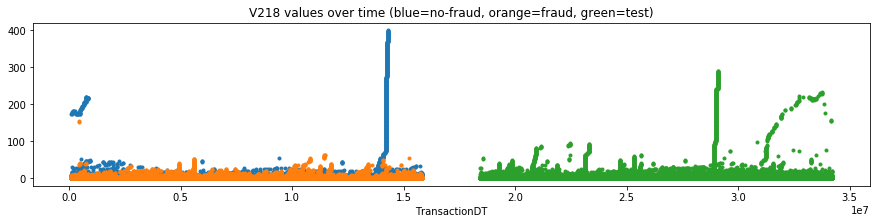

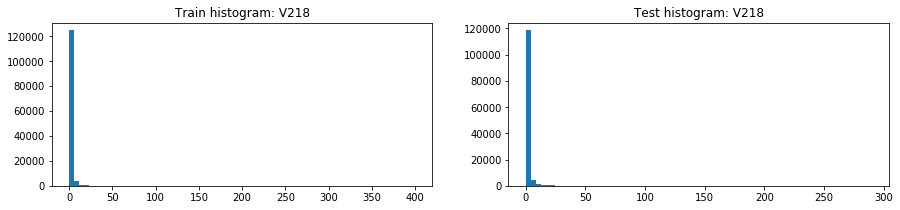

V218          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.725784      3.999902         1.533018   
2             std      13.919876      6.882425        14.342145   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      2.000000         0.000000   
6             75%       1.000000      5.000000         1.000000   
7             max     400.000000    154.000000       400.000000   
8   unique values     402.000000     68.000000       402.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.632899      1.760124       1.613959  
2       10.095978      5.215433      10.632537  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7      290.000000     87.000000     290.000000  
8      292.000000     89.000000     292.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V218  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                  90334     0.035081        3169        86000.0
2    1.0                  17257     0.103494        1786        17317.0
3    2.0                   7967     0.145475        1159         7874.0
4    3.0                   4494     0.182466         820         4429.0
5    4.0                   2779     0.224181         623         2764.0
6    5.0                   1672     0.256579         429         1758.0
7    6.0                   1150     0.299130         344         1219.0
8    7.0                    850     0.318824         271          863.0
9    8.0                    630     0.349206         220          675.0

V218  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0           90334     0.035081               3169          86000
2    1.0           17257     0.103494               1786          17317
3    2.0            7967     0.145475               1159           7874
4    3.0            4494     0.182466                820           4429
5    4.0            2779     0.224181                623           2764
6    5.0            1672     0.256579                429           1758
7    6.0            1150     0.299130                344           1219
8    7.0             850     0.318824                271            863
9    8.0             630     0.349206                220            675

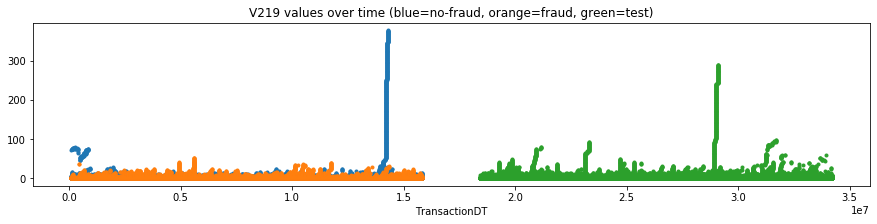

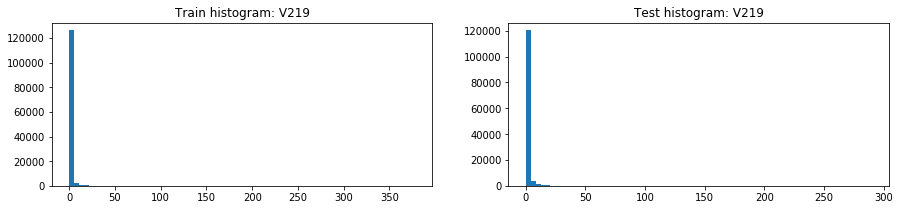

V219          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.367132      3.271782         1.205684   
2             std      12.044032      5.381539        12.432478   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       1.000000      4.000000         0.000000   
7             max     378.000000     53.000000       378.000000   
8   unique values     380.000000     55.000000       380.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.308811      1.476219       1.283890  
2        8.763826      4.706359       9.216094  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7      290.000000     80.000000     290.000000  
8      292.000000     82.000000     292.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V219  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                  94337     0.036529        3446        89956.0
2    1.0                  16438     0.114856        1888        16581.0
3    2.0                   7419     0.162421        1205         7273.0
4    3.0                   4045     0.207417         839         3997.0
5    4.0                   2435     0.252156         614         2456.0
6    5.0                   1393     0.292175         407         1500.0
7    6.0                    924     0.324675         300          999.0
8    7.0                    633     0.375987         238          665.0
9    8.0                    468     0.388889         182          520.0

V219  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0           94337     0.036529               3446          89956
2    1.0           16438     0.114856               1888          16581
3    2.0            7419     0.162421               1205           7273
4    3.0            4045     0.207417                839           3997
5    4.0            2435     0.252156                614           2456
6    5.0            1393     0.292175                407           1500
7    6.0             924     0.324675                300            999
8    7.0             633     0.375987                238            665
9    8.0             468     0.388889                182            520

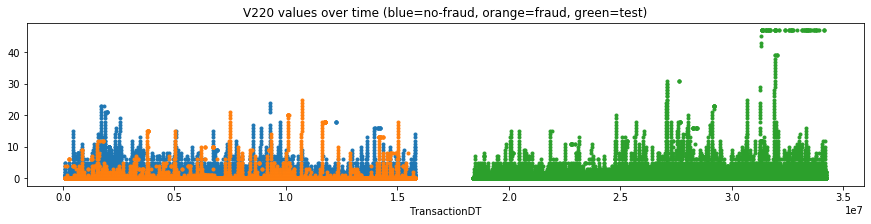

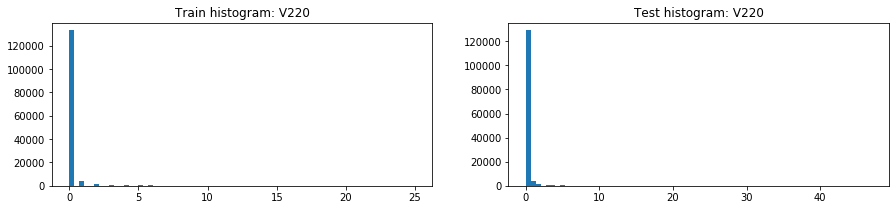

V220          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.169472      0.434165         0.147186   
2             std       1.002463      2.017091         0.860589   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      25.000000     25.000000        24.000000   
8   unique values      27.000000     27.000000        26.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.203720      0.126311       0.215200  
2        1.646167      0.732897       1.740996  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       47.000000     15.000000      47.000000  
8       45.000000     17.000000      45.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V220  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681         369375
1    0.0                 133047     0.075379       10029         129017
2    1.0                   3795     0.073254         278           4111
3    2.0                   1562     0.079385         124           1417
4    3.0                    980     0.106122         104            812
5    4.0                    615     0.149593          92            520
6    5.0                    380     0.155263          59            343
7    6.0                    290     0.189655          55            233
8    7.0                    173     0.167630          29            156
9    8.0                    124     0.241935          30            129

V220  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          133047     0.075379              10029         129017
1 -999.0          449124     0.021555               9681         369375
2    1.0            3795     0.073254                278           4111
3    2.0            1562     0.079385                124           1417
4    3.0             980     0.106122                104            812
5    4.0             615     0.149593                 92            520
6    5.0             380     0.155263                 59            343
7    6.0             290     0.189655                 55            233
8    8.0             124     0.241935                 30            129
9    7.0             173     0.167630                 29            156

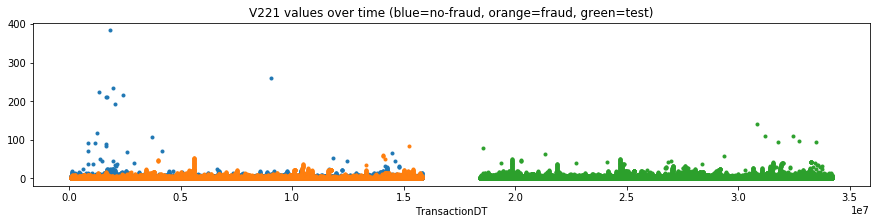

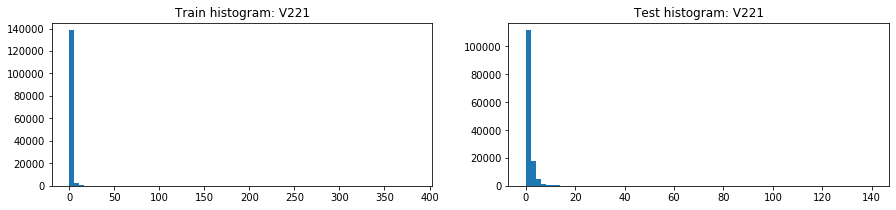

V221          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       1.274912      2.521399         1.169963   
2             std       2.728792      4.369119         2.514822   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max     384.000000     84.000000       384.000000   
8   unique values      78.000000     60.000000        61.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        1.286085      1.421056       1.266068  
2        2.272496      2.603597       2.218505  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      140.000000     80.000000     140.000000  
8       61.000000     54.000000      59.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V221  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                  82715     0.038760        3206        76462.0
2    0.0                  32341     0.093998        3040        34966.0
3    2.0                  12789     0.126828        1622        12283.0
4    3.0                   5615     0.158860         892         5431.0
5    4.0                   3064     0.202676         621         2884.0
6    5.0                   1716     0.236597         406         1767.0
7    6.0                    850     0.276471         235          881.0
8    7.0                    566     0.289753         164          591.0
9    8.0                    401     0.346633         139          397.0

V221  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    1.0           82715     0.038760               3206          76462
2    0.0           32341     0.093998               3040          34966
3    2.0           12789     0.126828               1622          12283
4    3.0            5615     0.158860                892           5431
5    4.0            3064     0.202676                621           2884
6    5.0            1716     0.236597                406           1767
7    6.0             850     0.276471                235            881
8    7.0             566     0.289753                164            591
9    8.0             401     0.346633                139            397

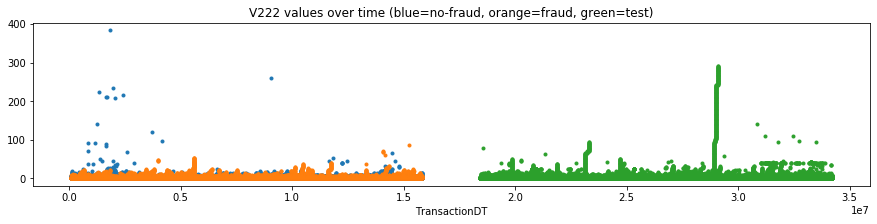

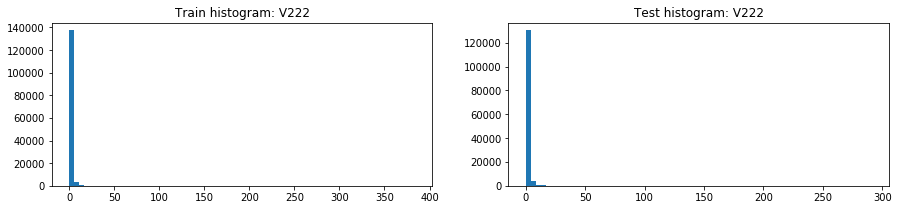

V222          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       1.359005      3.029776         1.218333   
2             std       2.913772      5.078343         2.603629   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      4.000000         1.000000   
7             max     384.000000     86.000000       384.000000   
8   unique values      77.000000     61.000000        63.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        1.758987      1.611537       1.780853  
2        8.293763      3.214567       8.800656  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      291.000000     80.000000     291.000000  
8      293.000000     54.000000     293.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V222  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                  80334     0.033597        2699        73617.0
2    0.0                  32264     0.093882        3029        34899.0
3    2.0                  13462     0.113430        1527        13040.0
4    3.0                   5985     0.153885         921         5632.0
5    4.0                   3313     0.198612         658         3127.0
6    5.0                   1943     0.258878         503         1884.0
7    6.0                   1173     0.276215         324         1197.0
8    7.0                    687     0.308588         212          774.0
9    8.0                    470     0.342553         161          519.0

V222  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    0.0           32264     0.093882               3029          34899
2    1.0           80334     0.033597               2699          73617
3    2.0           13462     0.113430               1527          13040
4    3.0            5985     0.153885                921           5632
5    4.0            3313     0.198612                658           3127
6    5.0            1943     0.258878                503           1884
7    6.0            1173     0.276215                324           1197
8    7.0             687     0.308588                212            774
9    9.0             409     0.501222                205            394

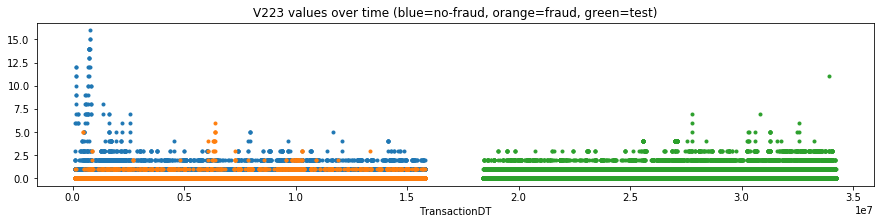

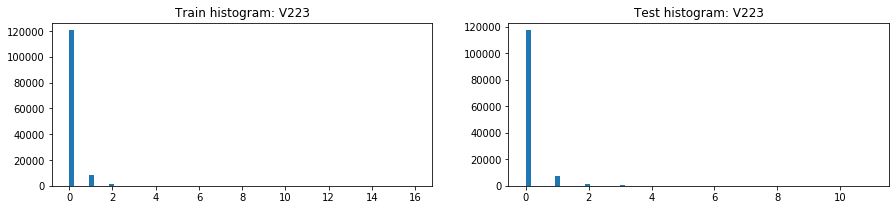

V223          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.093153      0.094682         0.093024   
2             std       0.402232      0.348206         0.406483   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      16.000000      6.000000        16.000000   
8   unique values      18.000000      8.000000        18.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.095922      0.081542       0.098063  
2        0.374674      0.317555       0.382403  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       11.000000      3.000000      11.000000  
8       10.000000      5.000000      10.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V223  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 120515     0.077492        9339       117163.0
2    1.0                   8495     0.092172         783         7602.0
3    2.0                   1114     0.042190          47         1459.0
4    3.0                    181     0.060773          11          408.0
5    4.0                     38     0.157895           6           80.0
6    5.0                     20     0.250000           5           11.0
7    7.0                     16     0.000000           0            2.0
8    6.0                     10     0.100000           1            2.0
9   14.0                      8     0.000000           0            NaN

V223  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471       379963.0
1    0.0          120515     0.077492               9339       117163.0
2    1.0            8495     0.092172                783         7602.0
3    2.0            1114     0.042190                 47         1459.0
4    3.0             181     0.060773                 11          408.0
5    4.0              38     0.157895                  6           80.0
6    5.0              20     0.250000                  5           11.0
7    6.0              10     0.100000                  1            2.0
8    9.0               5     0.000000                  0            NaN
9   15.0               2     0.000000                  0            NaN

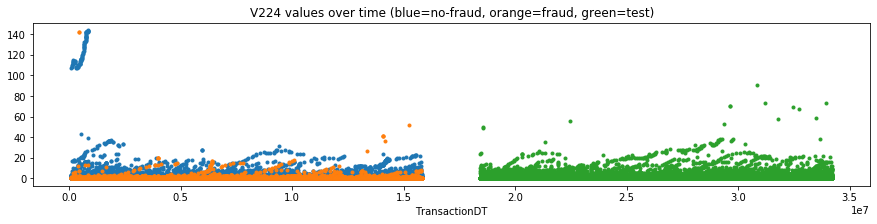

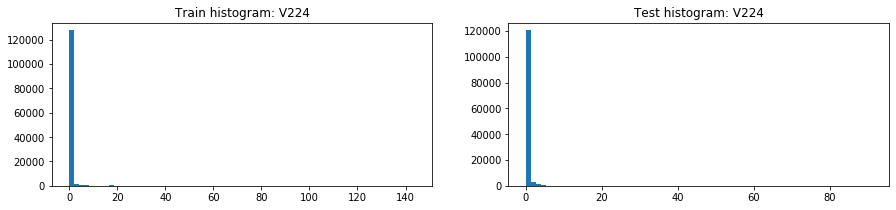

V224          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.394748      0.408359         0.393594   
2             std       3.443310      2.533156         3.509631   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max     144.000000    142.000000       144.000000   
8   unique values      80.000000     26.000000        78.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.307067      0.330065       0.303643  
2        1.492265      1.506038       1.490181  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       91.000000     50.000000      91.000000  
8       51.000000     32.000000      49.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V224  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 112053     0.073073        8188       108515.0
2    1.0                  12540     0.112679        1413        11803.0
3    2.0                   2808     0.125712         353         3180.0
4    3.0                    942     0.087049          82         1218.0
5    4.0                    428     0.044393          19          560.0
6   18.0                    340     0.002941           1           22.0
7    5.0                    222     0.058559          13          394.0
8    6.0                    194     0.118557          23          217.0
9    7.0                    159     0.188679          30          143.0

V224  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          112053     0.073073               8188         108515
2    1.0           12540     0.112679               1413          11803
3    2.0            2808     0.125712                353           3180
4    3.0             942     0.087049                 82           1218
5    7.0             159     0.188679                 30            143
6    6.0             194     0.118557                 23            217
7    4.0             428     0.044393                 19            560
8    5.0             222     0.058559                 13            394
9    8.0              97     0.103093                 10            118

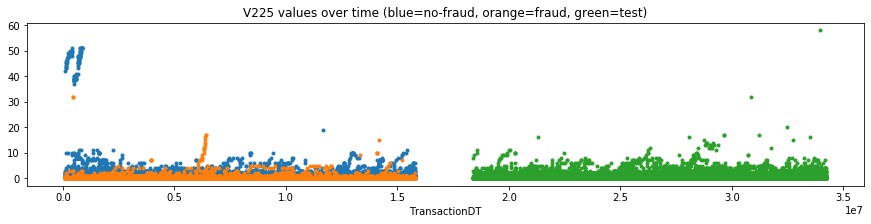

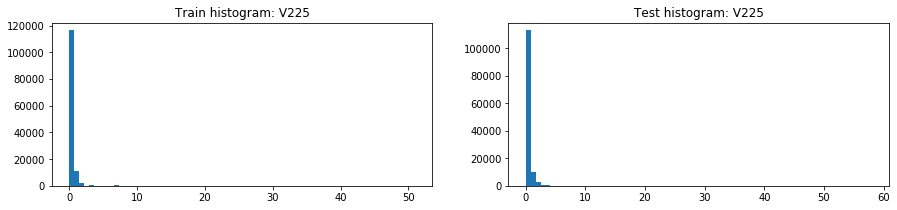

V225          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.191758      0.226943         0.188776   
2             std       1.290820      0.900620         1.318557   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      51.000000     32.000000        51.000000   
8   unique values      36.000000     20.000000        29.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.164620      0.154010       0.166200  
2        0.627715      0.589882       0.633141  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       58.000000     16.000000      58.000000  
8       22.000000     14.000000      22.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V225  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 116323     0.074448        8660       112754.0
2    1.0                  10798     0.112521        1215        10107.0
3    2.0                   1869     0.103799         194         2473.0
4    3.0                    526     0.076046          40          768.0
5    7.0                    377     0.023873           9           49.0
6    4.0                    180     0.177778          32          287.0
7    5.0                     99     0.191919          19          147.0
8    6.0                     71     0.028169           2           68.0
9    8.0                     39     0.051282           2           21.0

V225  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          116323     0.074448               8660         112754
2    1.0           10798     0.112521               1215          10107
3    2.0            1869     0.103799                194           2473
4    3.0             526     0.076046                 40            768
5    4.0             180     0.177778                 32            287
6    5.0              99     0.191919                 19            147
7    7.0             377     0.023873                  9             49
8   10.0              33     0.121212                  4             10
9   12.0               3     1.000000                  3              6

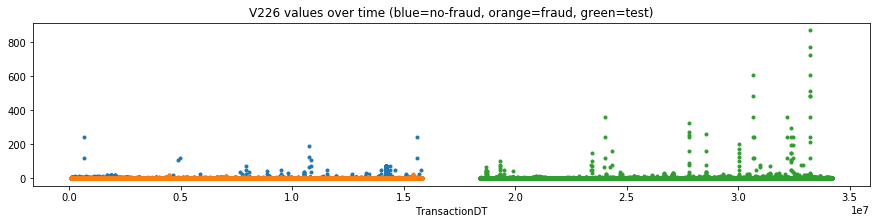

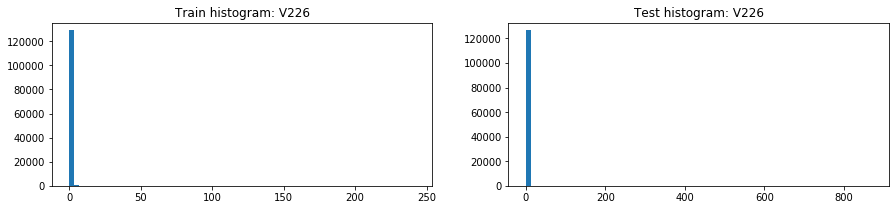

V226          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.247612      0.269133         0.245788   
2             std       2.756449      1.212436         2.849110   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max     242.000000     23.000000       242.000000   
8   unique values      82.000000     25.000000        82.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.267052      0.215943       0.274661  
2        6.734296      1.939026       7.179267  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      870.000000    100.000000     870.000000  
8       83.000000     31.000000      78.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V226  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 122371     0.075320        9217       119388.0
2    1.0                   4208     0.095532         402         3943.0
3    2.0                   1597     0.139011         222         1484.0
4    3.0                    728     0.167582         122          629.0
5    4.0                    474     0.154008          73          467.0
6    5.0                    215     0.227907          49          172.0
7    6.0                    136     0.205882          28          111.0
8    7.0                     84     0.250000          21           61.0
9    8.0                     72     0.208333          15           99.0

V226  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          122371     0.075320               9217         119388
2    1.0            4208     0.095532                402           3943
3    2.0            1597     0.139011                222           1484
4    3.0             728     0.167582                122            629
5    4.0             474     0.154008                 73            467
6    5.0             215     0.227907                 49            172
7    6.0             136     0.205882                 28            111
8    7.0              84     0.250000                 21             61
9    8.0              72     0.208333                 15             99

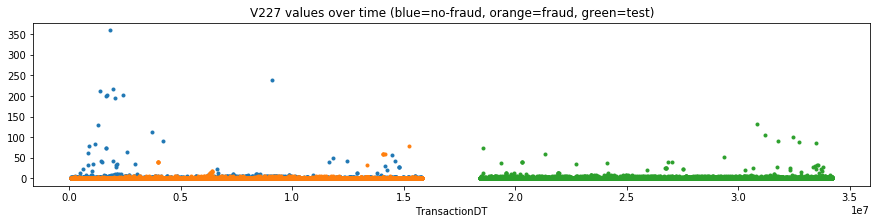

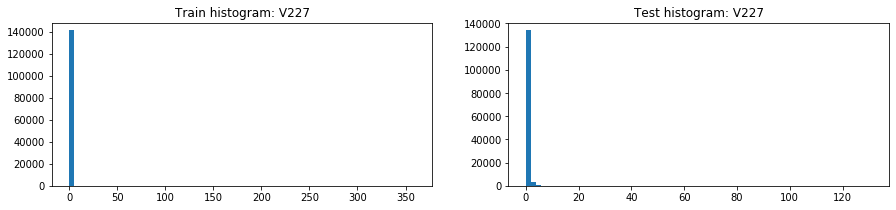

V227          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.147975      0.267984         0.137870   
2             std       2.049363      1.772261         2.070691   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max     360.000000     79.000000       360.000000   
8   unique values      51.000000     23.000000        46.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public  Test private  
0   137316.000000  17734.000000  119582.00000  
1        0.143246      0.145314       0.14294  
2        0.991485      1.086631       0.97659  
3        0.000000      0.000000       0.00000  
4        0.000000      0.000000       0.00000  
5        0.000000      0.000000       0.00000  
6        0.000000      0.000000       0.00000  
7      131.000000     75.000000     131.00000  
8       41.000000     16.000000      38.00000  
9   369375.000000  83605.000000  285771.00000  
10       0.729000      0.825000       0.70500

V227  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    0.0                 128436     0.072986        9374       124655.0
2    1.0                  10503     0.118918        1249         9278.0
3    2.0                   1659     0.101869         169         2267.0
4    3.0                    432     0.219907          95          643.0
5    4.0                    123     0.097561          12          219.0
6    6.0                     90     0.388889          35           50.0
7    5.0                     61     0.327869          20           79.0
8    7.0                     13     0.307692           4           45.0
9    9.0                     12     0.083333           1            7.0

V227  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    0.0          128436     0.072986               9374         124655
2    1.0           10503     0.118918               1249           9278
3    2.0            1659     0.101869                169           2267
4    3.0             432     0.219907                 95            643
5    6.0              90     0.388889                 35             50
6    5.0              61     0.327869                 20             79
7    4.0             123     0.097561                 12            219
8    7.0              13     0.307692                  4             45
9   40.0               5     0.800000                  4              1

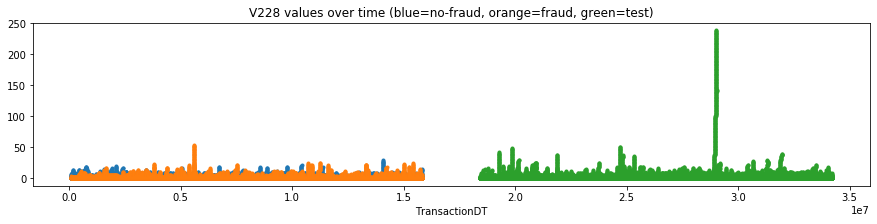

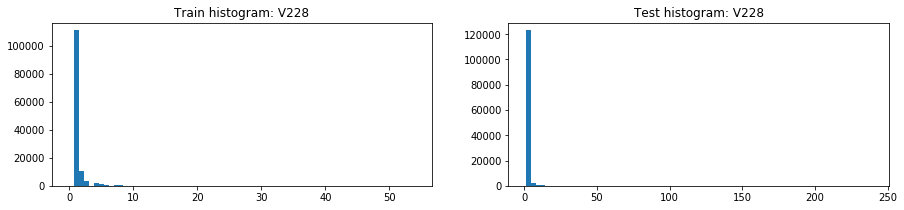

V228          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.351928      2.653748         1.241579   
2             std       1.409722      3.594541         0.951216   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      54.000000     54.000000        29.000000   
8   unique values      56.000000     56.000000        31.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.649770      1.670787       1.646641  
2        6.244667      2.674737       6.613324  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      239.000000     49.000000     239.000000  
8      240.000000     50.000000     240.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V228  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 111066     0.048863        5427       106429.0
2    2.0                  10750     0.176372        1896        10765.0
3    3.0                   3625     0.259862         942         3754.0
4    4.0                   1765     0.303683         536         1859.0
5    5.0                   1027     0.332035         341         1049.0
6    6.0                    625     0.356800         223          714.0
7    7.0                    420     0.440476         185          442.0
8    8.0                    288     0.468750         135          274.0
9    9.0                    190     0.473684          90          209.0

V228  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          111066     0.048863               5427         106429
2    2.0           10750     0.176372               1896          10765
3    3.0            3625     0.259862                942           3754
4    4.0            1765     0.303683                536           1859
5    5.0            1027     0.332035                341           1049
6    6.0             625     0.356800                223            714
7    7.0             420     0.440476                185            442
8    8.0             288     0.468750                135            274
9    9.0             190     0.473684                 90            209

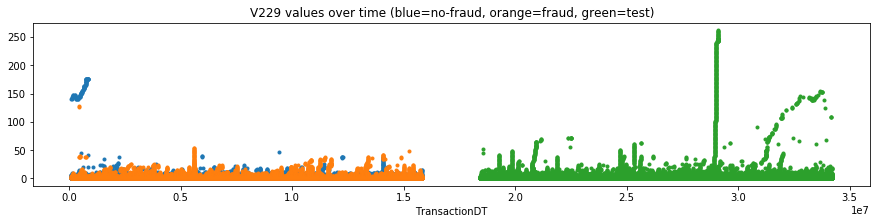

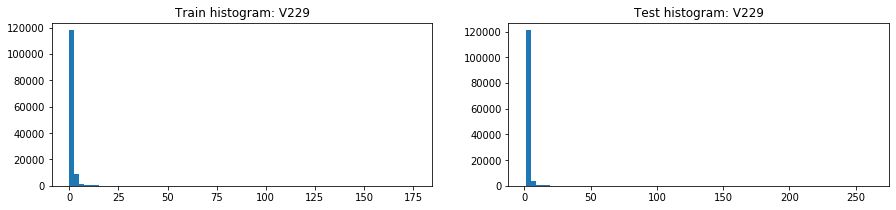

V229          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.638710      3.672979         1.466275   
2             std       4.316026      5.426587         4.163011   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      4.000000         1.000000   
7             max     176.000000    128.000000       176.000000   
8   unique values      92.000000     58.000000        79.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        2.061510      2.002192       2.070340  
2        8.781379      4.004504       9.284637  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      2.000000       1.000000  
7      262.000000     70.000000     262.000000  
8      263.000000     71.000000     263.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V229  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 104007     0.042680        4439        99024.0
2    2.0                  13775     0.136189        1876        14028.0
3    3.0                   5042     0.214399        1081         5213.0
4    4.0                   2521     0.259421         654         2580.0
5    5.0                   1480     0.290541         430         1506.0
6    6.0                    890     0.348315         310          955.0
7    7.0                    635     0.395276         251          655.0
8    8.0                    429     0.442890         190          408.0
9    9.0                    290     0.444828         129          315.0

V229  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          104007     0.042680               4439          99024
2    2.0           13775     0.136189               1876          14028
3    3.0            5042     0.214399               1081           5213
4    4.0            2521     0.259421                654           2580
5    5.0            1480     0.290541                430           1506
6    6.0             890     0.348315                310            955
7    7.0             635     0.395276                251            655
8    8.0             429     0.442890                190            408
9    9.0             290     0.444828                129            315

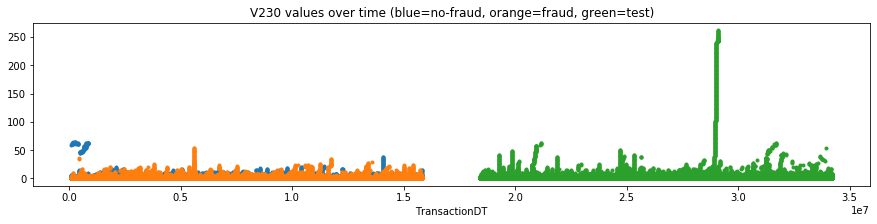

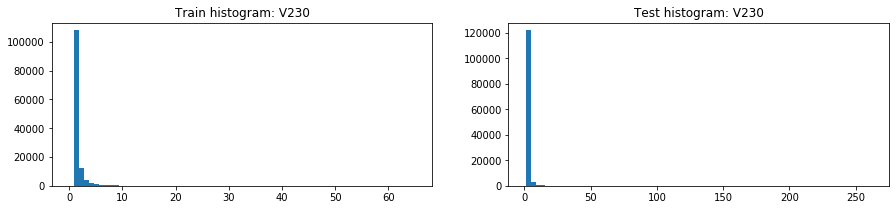

V230          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.465476      3.155122         1.322253   
2             std       2.122783      4.257576         1.757632   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      65.000000     54.000000        65.000000   
8   unique values      67.000000     56.000000        61.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.878488      1.869435       1.879835  
2        8.129952      3.659087       8.598990  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      262.000000     63.000000     262.000000  
8      263.000000     64.000000     263.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V230  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 107849     0.044748        4826       102917.0
2    2.0                  12241     0.157095        1923        12438.0
3    3.0                   4206     0.240609        1012         4361.0
4    4.0                   2078     0.290664         604         2133.0
5    5.0                   1193     0.343671         410         1224.0
6    6.0                    733     0.368349         270          819.0
7    7.0                    493     0.436105         215          544.0
8    8.0                    362     0.477901         173          348.0
9    9.0                    240     0.470833         113          259.0

V230  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          107849     0.044748               4826         102917
2    2.0           12241     0.157095               1923          12438
3    3.0            4206     0.240609               1012           4361
4    4.0            2078     0.290664                604           2133
5    5.0            1193     0.343671                410           1224
6    6.0             733     0.368349                270            819
7    7.0             493     0.436105                215            544
8    8.0             362     0.477901                173            348
9    9.0             240     0.470833                113            259

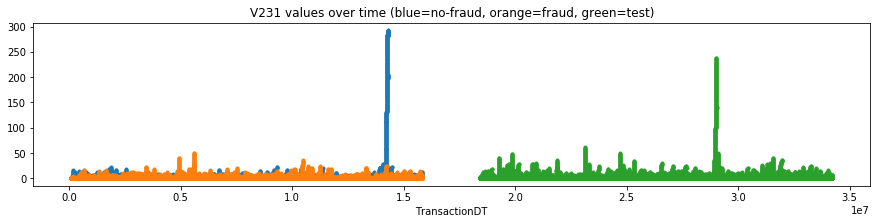

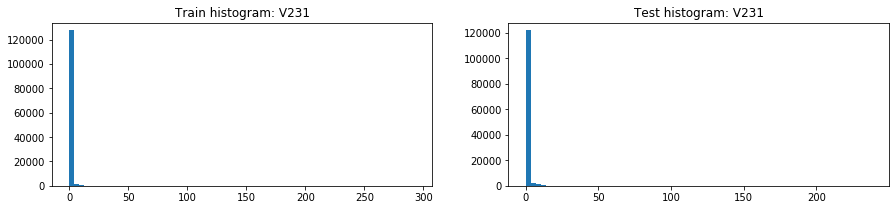

V231          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.765506      2.024431         0.658793   
2             std       8.877119      4.267971         9.153875   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max     293.000000     51.000000       293.000000   
8   unique values     295.000000     53.000000       295.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.719320      0.864929       0.697644  
2        6.400332      3.155708       6.751035  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      238.000000     49.000000     238.000000  
8      240.000000     51.000000     240.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V231  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 112885     0.047101        5317       109490.0
2    1.0                   7478     0.227868        1704         6593.0
3    2.0                   3785     0.235139         890         3655.0
4    3.0                   2057     0.264949         545         2070.0
5    4.0                   1198     0.310518         372         1252.0
6    5.0                    691     0.395080         273          765.0
7    6.0                    478     0.428870         205          520.0
8    7.0                    358     0.458101         164          365.0
9    8.0                    248     0.508065         126          275.0

V231  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          112885     0.047101               5317         109490
2    1.0            7478     0.227868               1704           6593
3    2.0            3785     0.235139                890           3655
4    3.0            2057     0.264949                545           2070
5    4.0            1198     0.310518                372           1252
6    5.0             691     0.395080                273            765
7    6.0             478     0.428870                205            520
8    7.0             358     0.458101                164            365
9    8.0             248     0.508065                126            275

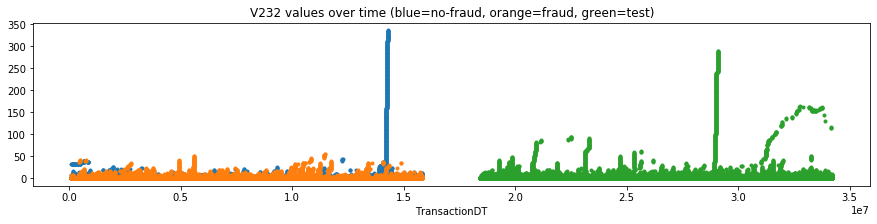

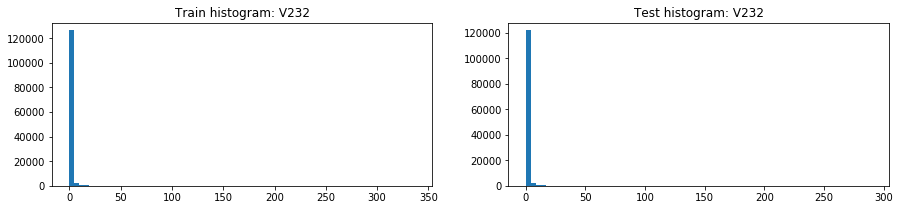

V232          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.005597      2.967327         0.839310   
2             std      10.460253      5.975140        10.738334   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      3.000000         0.000000   
7             max     337.000000     56.000000       337.000000   
8   unique values     339.000000     58.000000       339.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.080929      1.185433       1.065372  
2        9.335726      4.876866       9.827928  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      290.000000     87.000000     290.000000  
8      292.000000     89.000000     292.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V232  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 110617     0.043257        4785       107458.0
2    1.0                   7593     0.209272        1589         6725.0
3    2.0                   4087     0.221678         906         3903.0
4    3.0                   2352     0.239796         564         2304.0
5    4.0                   1479     0.290061         429         1466.0
6    5.0                    896     0.348214         312          944.0
7    6.0                    640     0.384375         246          661.0
8    7.0                    474     0.426160         202          477.0
9    8.0                    332     0.463855         154          376.0

V232  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          110617     0.043257               4785         107458
2    1.0            7593     0.209272               1589           6725
3    2.0            4087     0.221678                906           3903
4    3.0            2352     0.239796                564           2304
5    4.0            1479     0.290061                429           1466
6    5.0             896     0.348214                312            944
7    6.0             640     0.384375                246            661
8    7.0             474     0.426160                202            477
9    8.0             332     0.463855                154            376

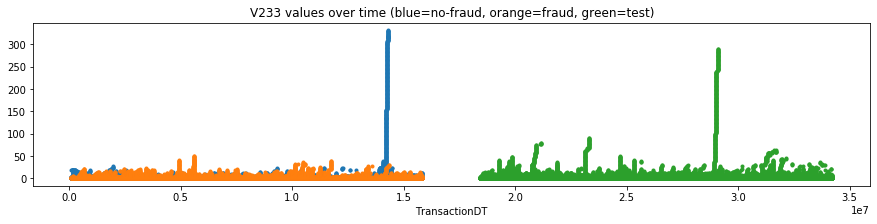

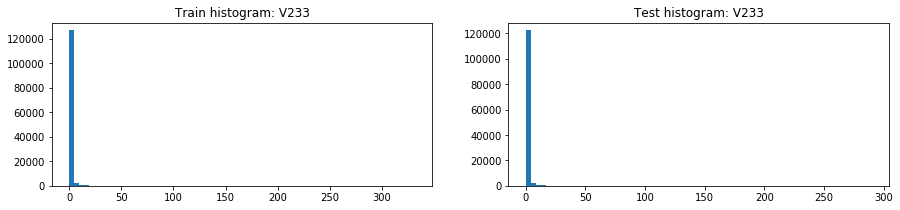

V233          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.908388      2.519918         0.771786   
2             std      10.149884      5.047551        10.457271   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      3.000000         0.000000   
7             max     332.000000     51.000000       332.000000   
8   unique values     334.000000     53.000000       334.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.944046      1.110955       0.919198  
2        8.592558      4.600746       9.037014  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      290.000000     80.000000     290.000000  
8      292.000000     82.000000     292.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V233  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 111756     0.044839        5011       108466.0
2    1.0                   7439     0.218443        1625         6565.0
3    2.0                   3940     0.228173         899         3749.0
4    3.0                   2206     0.253853         560         2207.0
5    4.0                   1350     0.297778         402         1382.0
6    5.0                    800     0.365000         292          856.0
7    6.0                    558     0.397849         222          585.0
8    7.0                    451     0.427938         193          423.0
9    8.0                    287     0.491289         141          328.0

V233  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          111756     0.044839               5011         108466
2    1.0            7439     0.218443               1625           6565
3    2.0            3940     0.228173                899           3749
4    3.0            2206     0.253853                560           2207
5    4.0            1350     0.297778                402           1382
6    5.0             800     0.365000                292            856
7    6.0             558     0.397849                222            585
8    7.0             451     0.427938                193            423
9    8.0             287     0.491289                141            328

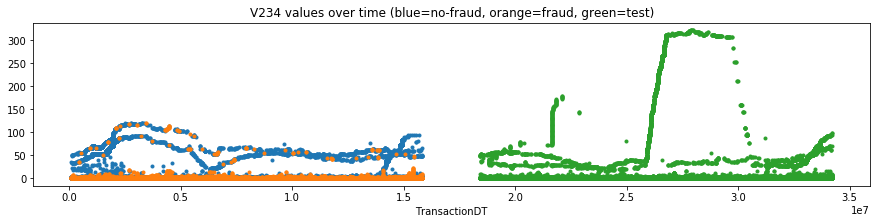

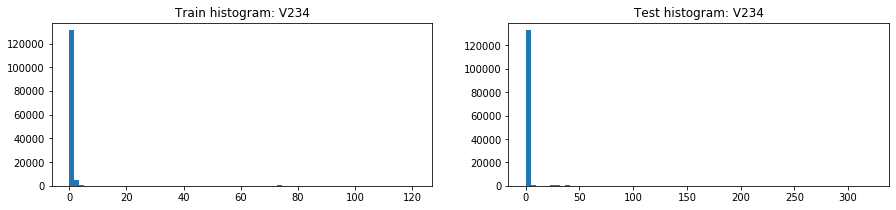

V234          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       2.092847      1.337461         2.156447   
2             std      11.323036      7.735587        11.572216   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     121.000000    120.000000       121.000000   
8   unique values     123.000000     72.000000       122.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        3.112951      1.823052       3.304243  
2       22.768146     10.782597      24.036255  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      322.000000    158.000000     322.000000  
8      309.000000    151.000000     303.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V234  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681         369375
1    0.0                 120416     0.064609        7780         115444
2    1.0                  10620     0.152448        1619          11400
3    2.0                   3670     0.203815         748           3937
4    3.0                   1168     0.239726         280           1326
5   73.0                    885     0.001130           1             28
6    4.0                    612     0.254902         156            706
7    5.0                    217     0.373272          81            304
8    6.0                    210     0.328571          69            165
9   38.0                    197     0.000000           0             77

V234  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    0.0          120416     0.064609               7780         115444
2    1.0           10620     0.152448               1619          11400
3    2.0            3670     0.203815                748           3937
4    3.0            1168     0.239726                280           1326
5    4.0             612     0.254902                156            706
6    5.0             217     0.373272                 81            304
7    6.0             210     0.328571                 69            165
8    8.0              79     0.379747                 30             62
9    7.0              79     0.367089                 29             76

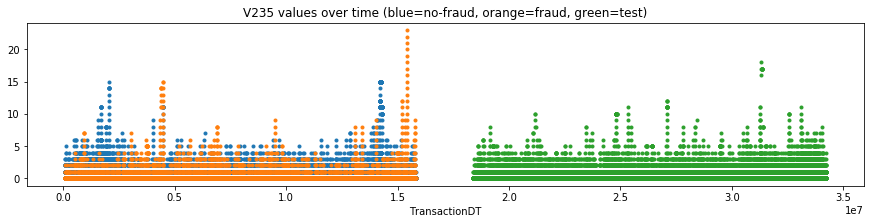

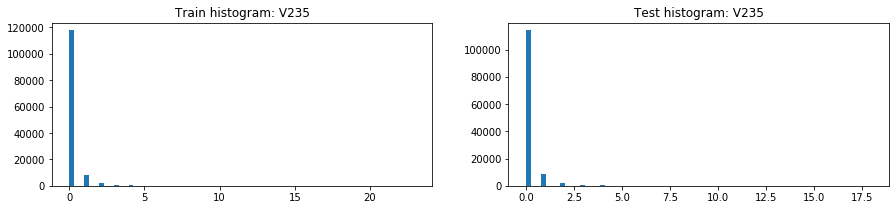

V235          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.184106      0.420330         0.164083   
2             std       0.902639      1.237212         0.865420   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      23.000000     23.000000        15.000000   
8   unique values      25.000000     25.000000        17.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.156887      0.169417       0.155022  
2        0.610037      0.600278       0.611457  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       18.000000     10.000000      18.000000  
8       17.000000     12.000000      17.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V235  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 117724     0.067854        7988       114010.0
2    1.0                   8389     0.154726        1298         8769.0
3    2.0                   2431     0.206499         502         2393.0
4    3.0                    865     0.217341         188          884.0
5    4.0                    362     0.245856          89          333.0
6   15.0                    175     0.017143           3            NaN
7    5.0                    128     0.296875          38          156.0
8   11.0                     97     0.051546           5           13.0
9    6.0                     70     0.257143          18           53.0

V235  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          117724     0.067854               7988         114010
2    1.0            8389     0.154726               1298           8769
3    2.0            2431     0.206499                502           2393
4    3.0             865     0.217341                188            884
5    4.0             362     0.245856                 89            333
6    5.0             128     0.296875                 38            156
7    6.0              70     0.257143                 18             53
8    7.0              36     0.472222                 17             30
9    8.0              31     0.419355                 13             25

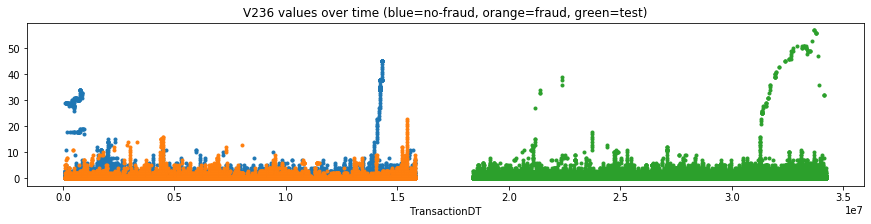

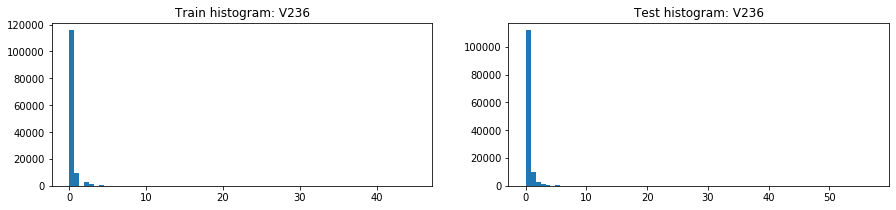

V236          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.307667      0.603218         0.282614   
2             std       2.152332      1.502342         2.196789   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      45.000000     23.000000        45.000000   
8   unique values      47.000000     25.000000        47.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.226351      0.222581       0.226912  
2        1.346758      0.910738       1.400106  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       57.000000     34.000000      57.000000  
8       49.000000     20.000000      49.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V236  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 115566     0.063842        7378       111713.0
2    1.0                   9302     0.158246        1472         9820.0
3    2.0                   2927     0.225487         660         2996.0
4    3.0                   1111     0.257426         286         1081.0
5    4.0                    468     0.311966         146          447.0
6    5.0                    204     0.397059          81          246.0
7   38.0                    182     0.000000           0            1.0
8    6.0                    133     0.413534          55          102.0
9    7.0                     81     0.345679          28           68.0

V236  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          115566     0.063842               7378         111713
2    1.0            9302     0.158246               1472           9820
3    2.0            2927     0.225487                660           2996
4    3.0            1111     0.257426                286           1081
5    4.0             468     0.311966                146            447
6    5.0             204     0.397059                 81            246
7    6.0             133     0.413534                 55            102
8    7.0              81     0.345679                 28             68
9    8.0              54     0.370370                 20             39

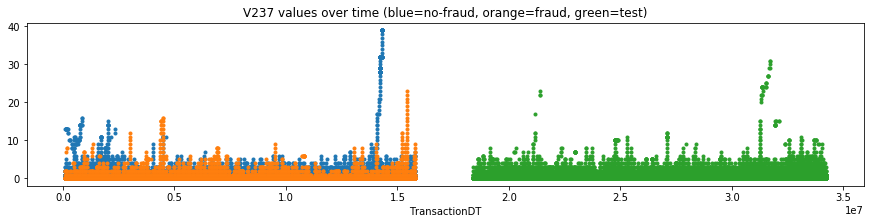

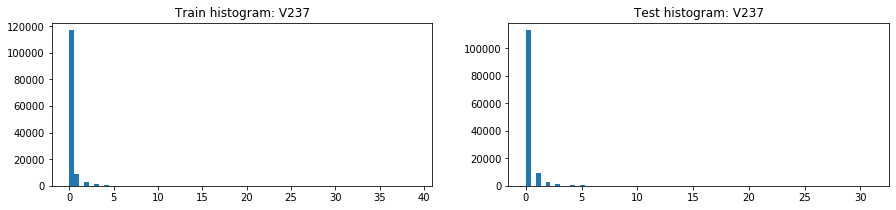

V237          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.253500      0.505396         0.232148   
2             std       1.716634      1.360593         1.741805   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      39.000000     23.000000        39.000000   
8   unique values      41.000000     25.000000        41.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.183630      0.192315       0.182337  
2        0.780026      0.735421       0.786444  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       31.000000     23.000000      31.000000  
8       28.000000     17.000000      27.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V237  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 116709     0.065813        7681       112917.0
2    1.0                   8789     0.159290        1400         9201.0
3    2.0                   2693     0.213888         576         2721.0
4    3.0                    999     0.247247         247          976.0
5    4.0                    394     0.261421         103          398.0
6   32.0                    182     0.000000           0            NaN
7    5.0                    167     0.365269          61          228.0
8    6.0                     96     0.375000          36           75.0
9   28.0                     59     0.000000           0            NaN

V237  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          116709     0.065813               7681         112917
2    1.0            8789     0.159290               1400           9201
3    2.0            2693     0.213888                576           2721
4    3.0             999     0.247247                247            976
5    4.0             394     0.261421                103            398
6    5.0             167     0.365269                 61            228
7    6.0              96     0.375000                 36             75
8    7.0              43     0.511628                 22             49
9    8.0              42     0.428571                 18             23

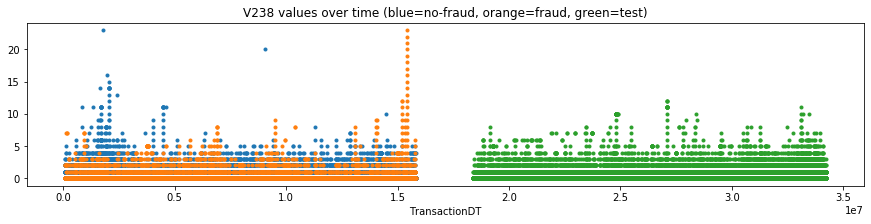

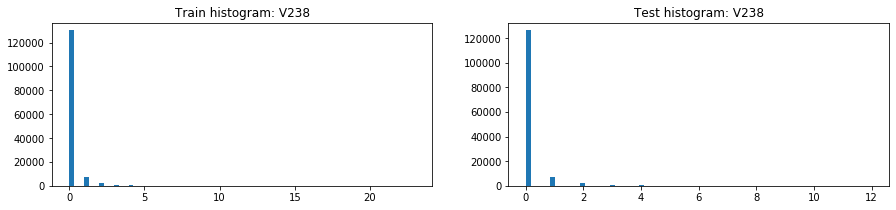

V238          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.127956      0.360681         0.108361   
2             std       0.574657      1.086645         0.503668   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      23.000000     23.000000        23.000000   
8   unique values      25.000000     25.000000        20.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.127319      0.126424       0.127452  
2        0.541831      0.531560       0.543340  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       12.000000      8.000000      12.000000  
8       14.000000     10.000000      14.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V238  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    0.0                 130158     0.068317        8892       126234.0
2    1.0                   7471     0.158479        1184         7457.0
3    2.0                   2368     0.219595         520         2251.0
4    3.0                    796     0.257538         205          763.0
5    4.0                    328     0.225610          74          293.0
6    5.0                    110     0.372727          41          144.0
7    6.0                     59     0.254237          15           63.0
8    7.0                     30     0.500000          15           39.0
9    8.0                     28     0.428571          12           19.0

V238  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    0.0          130158     0.068317               8892         126234
2    1.0            7471     0.158479               1184           7457
3    2.0            2368     0.219595                520           2251
4    3.0             796     0.257538                205            763
5    4.0             328     0.225610                 74            293
6    5.0             110     0.372727                 41            144
7    6.0              59     0.254237                 15             63
8    7.0              30     0.500000                 15             39
9    8.0              28     0.428571                 12             19

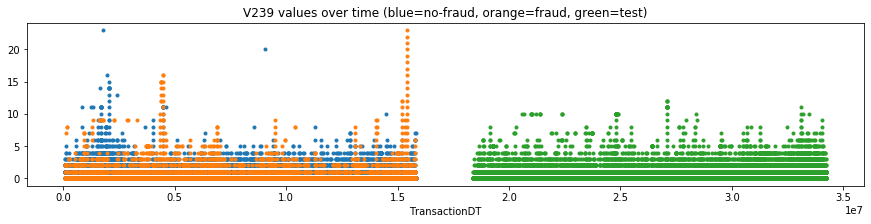

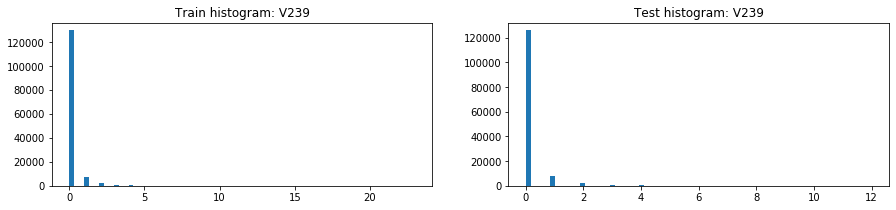

V239          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.136965      0.437261         0.111681   
2             std       0.616260      1.293764         0.512448   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      23.000000     23.000000        23.000000   
8   unique values      25.000000     25.000000        20.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.137275      0.135446       0.137546  
2        0.578917      0.591327       0.577056  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       12.000000     10.000000      12.000000  
8       14.000000     11.000000      14.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V239  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    0.0                 129713     0.066824        8668       125810.0
2    1.0                   7645     0.163506        1250         7564.0
3    2.0                   2483     0.233588         580         2315.0
4    3.0                    863     0.265353         229          795.0
5    4.0                    349     0.257880          90          461.0
6    5.0                    125     0.432000          54          167.0
7    6.0                     69     0.289855          20           70.0
8    7.0                     34     0.529412          18           45.0
9    8.0                     34     0.500000          17           21.0

V239  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    0.0          129713     0.066824               8668         125810
2    1.0            7645     0.163506               1250           7564
3    2.0            2483     0.233588                580           2315
4    3.0             863     0.265353                229            795
5    4.0             349     0.257880                 90            461
6    5.0             125     0.432000                 54            167
7    9.0              29     0.724138                 21              7
8    6.0              69     0.289855                 20             70
9    7.0              34     0.529412                 18             45

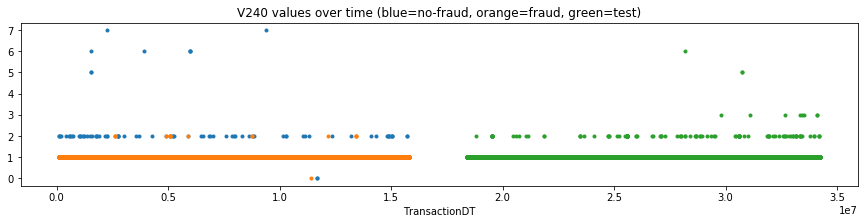

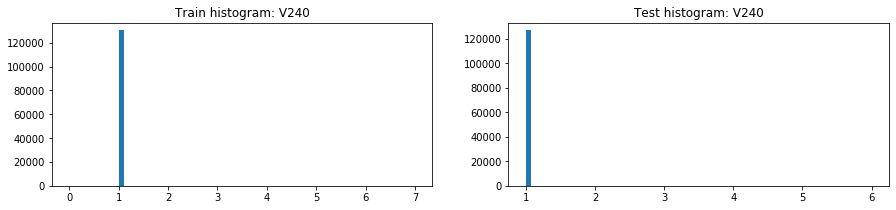

V240          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.000997      1.001472         1.000956   
2             std       0.049522      0.040816         0.050191   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      2.000000         7.000000   
8   unique values       7.000000      4.000000         7.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.001160      1.000853       1.001206  
2        0.040399      0.029187       0.041812  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        6.000000      2.000000       6.000000  
8        6.000000      3.000000       6.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V240  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 130330     0.078071       10175       126599.0
2    2.0                     88     0.181818          16          118.0
3    6.0                      5     0.000000           0            1.0
4    0.0                      3     0.333333           1            NaN
5    5.0                      2     0.000000           0            2.0
6    7.0                      2     0.000000           0            NaN

V240  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471       379963.0
1    1.0          130330     0.078071              10175       126599.0
2    2.0              88     0.181818                 16          118.0
3    0.0               3     0.333333                  1            NaN
4    6.0               5     0.000000                  0            1.0
5    5.0               2     0.000000                  0            2.0
6    7.0               2     0.000000                  0            NaN

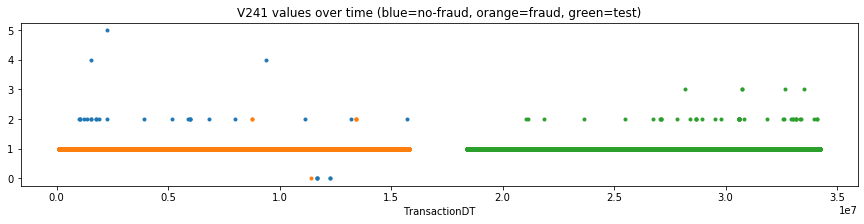

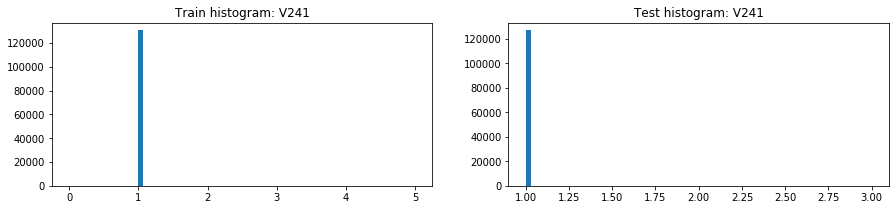

V241          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.000238      1.000392         1.000225   
2             std       0.022663      0.024261         0.022523   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       5.000000      2.000000         5.000000   
8   unique values       6.000000      4.000000         6.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.000402      1.000122       1.000444  
2        0.021936      0.011036       0.023123  
3        1.000000      1.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        3.000000      2.000000       3.000000  
8        4.000000      3.000000       4.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V241  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 130394     0.078117       10186       126682.0
2    2.0                     27     0.185185           5           41.0
3    0.0                      6     0.166667           1            NaN
4    4.0                      2     0.000000           0            NaN
5    5.0                      1     0.000000           0            NaN

V241  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471       379963.0
1    1.0          130394     0.078117              10186       126682.0
2    2.0              27     0.185185                  5           41.0
3    0.0               6     0.166667                  1            NaN
4    4.0               2     0.000000                  0            NaN
5    5.0               1     0.000000                  0            NaN

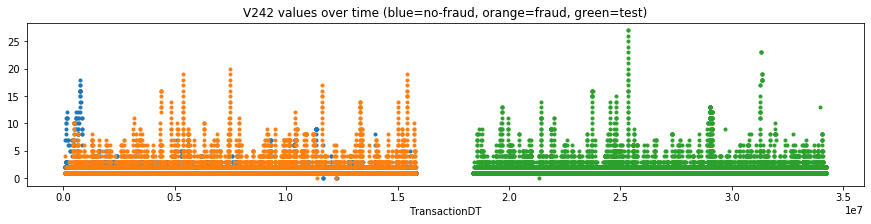

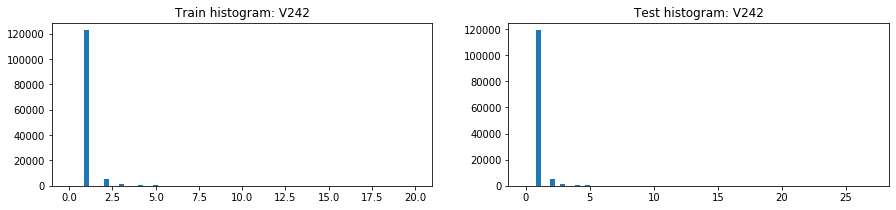

V242          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.113463      1.931024         1.044162   
2             std       0.660110      1.854551         0.345990   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      20.000000     20.000000        18.000000   
8   unique values      22.000000     22.000000        20.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.115050      1.171914       1.106584  
2        0.694536      0.736457       0.687678  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       27.000000     14.000000      27.000000  
8       29.000000     16.000000      28.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V242  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 122640     0.051729        6344         119011
2    2.0                   5218     0.350709        1830           5274
3    3.0                   1164     0.699313         814           1144
4    4.0                    480     0.895833         430            480
5    5.0                    281     0.886121         249            270
6    6.0                    195     0.871795         170            144
7    7.0                    150     0.873333         131             85
8    8.0                     89     0.876404          78             69
9    9.0                     60     0.666667          40             65

V242  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          122640     0.051729               6344         119011
2    2.0            5218     0.350709               1830           5274
3    3.0            1164     0.699313                814           1144
4    4.0             480     0.895833                430            480
5    5.0             281     0.886121                249            270
6    6.0             195     0.871795                170            144
7    7.0             150     0.873333                131             85
8    8.0              89     0.876404                 78             69
9    9.0              60     0.666667                 40             65

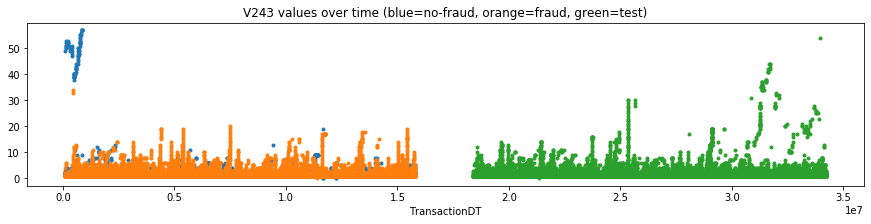

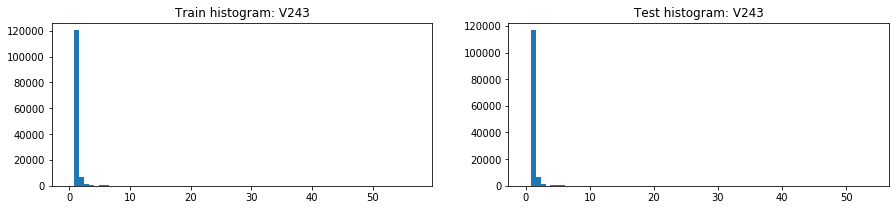

V243          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.178387      2.188579         1.092758   
2             std       1.398953      2.292076         1.258508   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      57.000000     34.000000        57.000000   
8   unique values      44.000000     24.000000        36.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.181278      1.243408       1.172029  
2        1.190253      0.961757       1.220350  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       54.000000     14.000000      54.000000  
8       45.000000     16.000000      44.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V243  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 120245     0.048376        5817       116549.0
2    2.0                   6719     0.285757        1920         6782.0
3    3.0                   1536     0.608073         934         1470.0
4    4.0                    669     0.766816         513          646.0
5    5.0                    351     0.846154         297          354.0
6    6.0                    235     0.817021         192          227.0
7    7.0                    168     0.892857         150          142.0
8    8.0                    124     0.870968         108           79.0
9    9.0                     80     0.737500          59           73.0

V243  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          120245     0.048376               5817         116549
2    2.0            6719     0.285757               1920           6782
3    3.0            1536     0.608073                934           1470
4    4.0             669     0.766816                513            646
5    5.0             351     0.846154                297            354
6    6.0             235     0.817021                192            227
7    7.0             168     0.892857                150            142
8    8.0             124     0.870968                108             79
9    9.0              80     0.737500                 59             73

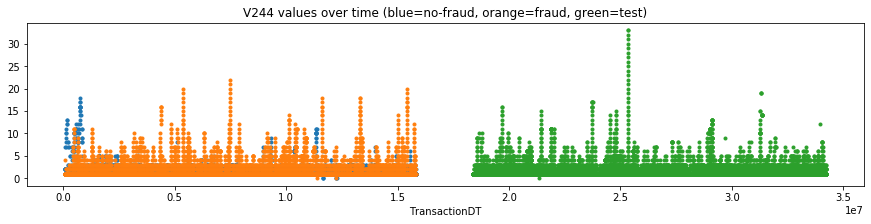

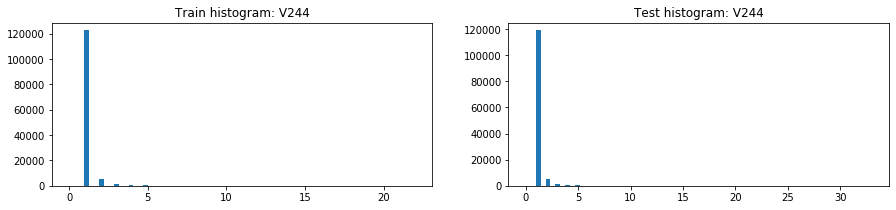

V244          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.118562      1.992543         1.044478   
2             std       0.698807      1.987337         0.353183   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      22.000000     22.000000        18.000000   
8   unique values      24.000000     24.000000        20.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.119082      1.192254       1.108189  
2        0.719554      0.804148       0.705450  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       33.000000     16.000000      33.000000  
8       35.000000     18.000000      34.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V244  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 122583     0.051035        6256         118930
2    2.0                   5139     0.350846        1803           5161
3    3.0                   1223     0.706460         864           1240
4    4.0                    481     0.885655         426            525
5    5.0                    305     0.878689         268            298
6    6.0                    219     0.890411         195            158
7    7.0                    146     0.883562         129             99
8    8.0                     74     0.797297          59             60
9    9.0                     66     0.833333          55             40

V244  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          122583     0.051035               6256         118930
2    2.0            5139     0.350846               1803           5161
3    3.0            1223     0.706460                864           1240
4    4.0             481     0.885655                426            525
5    5.0             305     0.878689                268            298
6    6.0             219     0.890411                195            158
7    7.0             146     0.883562                129             99
8    8.0              74     0.797297                 59             60
9    9.0              66     0.833333                 55             40

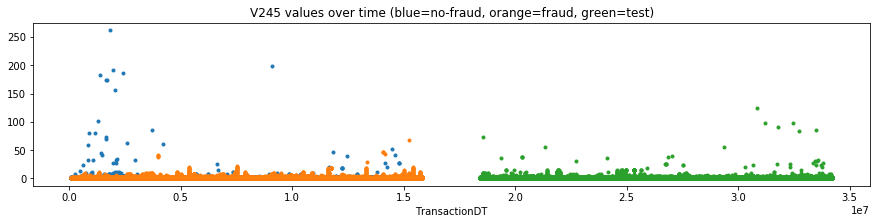

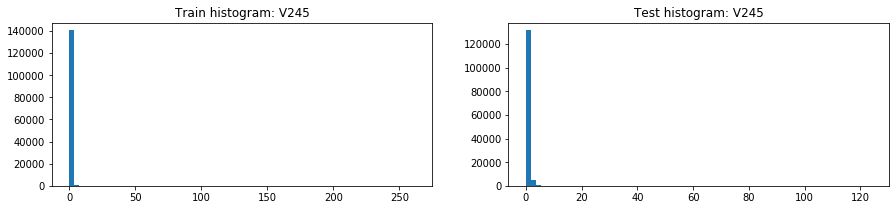

V245          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.876619      1.449736         0.828365   
2             std       1.821065      2.369050         1.758696   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max     262.000000     67.000000       262.000000   
8   unique values      59.000000     33.000000        47.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.830253      0.837036       0.829247  
2        1.067050      1.185331       1.048375  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      124.000000     74.000000     124.000000  
8       38.000000     21.000000      37.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V245  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                 102995     0.048779        5024        96484.0
2    0.0                  32341     0.093998        3040        34967.0
3    2.0                   4036     0.334737        1351         3982.0
4    3.0                    971     0.715757         695         1088.0
5    4.0                    347     0.824207         286          288.0
6    5.0                    203     0.837438         170          186.0
7    6.0                    134     0.873134         117           76.0
8    7.0                    116     0.810345          94           36.0
9    8.0                     49     0.816327          40           31.0

V245  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    1.0          102995     0.048779               5024          96484
2    0.0           32341     0.093998               3040          34967
3    2.0            4036     0.334737               1351           3982
4    3.0             971     0.715757                695           1088
5    4.0             347     0.824207                286            288
6    5.0             203     0.837438                170            186
7    6.0             134     0.873134                117             76
8    7.0             116     0.810345                 94             36
9    9.0              47     0.893617                 42             18

In [4]:
for col in list(tr.columns.values[150:300]):
    proc(col)